# MACHINE LEARNING I
# 
# LAB ASSIGNMENT II: TIME SERIES

## Authors:

- **Alberto García Martín**: 202309188@alu.comillas.edu

- **Jorge Peralta Fernández-Revuelta**: jperalta@alu.comillas.edu

- **Juan López Segura**: juanls@alu.comillas.edu

In this lab assignment, we will analyze the UnemploymentSpain.dat dataset and extract conclusions, performing several time series methods properly explained.

---

In [1]:
# For more information, check https://www.machinelearningplus.com/time-series/time-series-analysis-python/ 
### Load libraries ###
# interactive plotting
#%matplotlib inline
#%config InlineBackend.figure_format = 'svg' # ‘png’, ‘retina’, ‘jpeg’, ‘svg’, ‘pdf’

# plotting libraries
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
sns.set()
#Define figure sizes
plt.rcParams.update({'figure.figsize': (8, 5), 'figure.dpi': 120})

# Data management libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from dateutil.parser import parse 
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.neural_network import MLPRegressor
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV

# Machine Learning libraries
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_predict
import scipy as sp

# Others
import math
from mltools import forecast_tools as FT
import scipy.stats as st
from mltools import model_tools as MT
from neuralsens import partial_derivatives as ns
from mltools import regression_tools as RT

---
## 1. Read the dataset

In [2]:
# Import data
df = pd.read_csv('UnemploymentSpain.dat', parse_dates=['DATE'], dayfirst=True, sep='\t', index_col='DATE')
df

TOTAL
DATE               
2001-01-01  2017389
2001-02-01  1993273
2001-03-01  1981006
2001-04-01  1910453
2001-05-01  1898285
...             ...
2023-06-01  2688842
2023-07-01  2677874
2023-08-01  2702700
2023-09-01  2722468
2023-10-01  2759404

[274 rows x 1 columns]

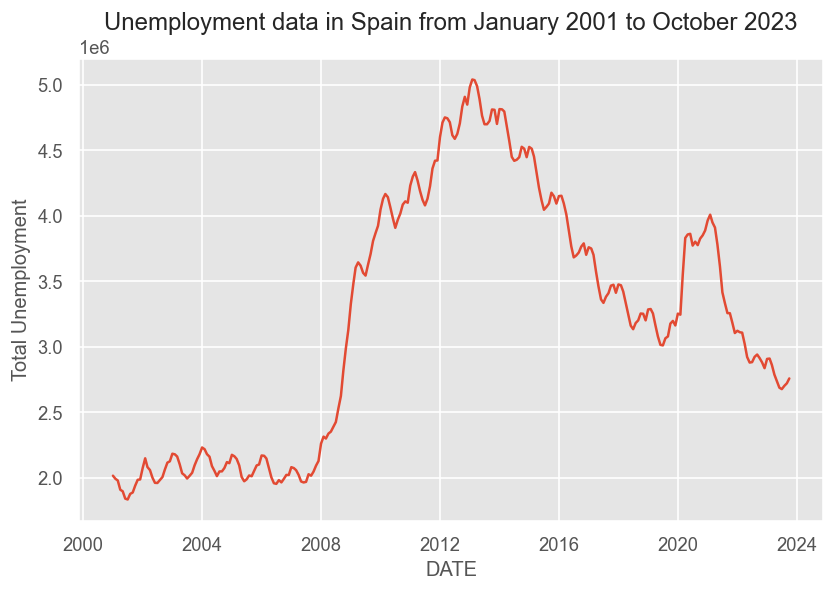

In [3]:
# Plotting a time series
fig, ax = plt.subplots()

ax.plot('TOTAL', data=df)
ax.set(title='Unemployment data in Spain from January 2001 to October 2023', xlabel='DATE', ylabel='Total Unemployment')


plt.show()

In [4]:
y = df
prop_train=0.88

## Divide the data into training and test sets SEQUENTIALY -------------------------------------
y_train = y.iloc[0:round(0.64*y.shape[0])]
y_test = y.iloc[round(0.64*y.shape[0])+1:round(0.8*y.shape[0])]

y_train2 = y.iloc[0:round(prop_train*y.shape[0])] #Si funciona mal, cambiar por 0.9
y_test2 = y.iloc[round(prop_train*y.shape[0])+1:round(y.shape[0])]

y_train.head()

TOTAL
DATE               
2001-01-01  2017389
2001-02-01  1993273
2001-03-01  1981006
2001-04-01  1910453
2001-05-01  1898285

Se divide el dataset en dos subconjuntos de entrenaimento y test. Esto es debido a que el último 20% corresponde al COVID, y si se utilizase un 80/20 sería el conjunto de test el del COVID, dando una sensación falsa de que el modelo es malo, y sin poder captar el verdadero comportamiento de la pandemia. Por ello, si se quieren entrenar modelos, se usan primero los datos sin COVID con una proporción aproximada de 80/20 (en el total, una relación 64/16). Con ello, se pretende conseguir un modelo que ajuste bien la serie temporal sin comportamientos anómalos y con menos riesgo de sobreajuste que si únicamente se utilizase entrenamiento, ya que se puede comprobar su comportamiento en el test.

Tras eso, se estudia de nuevo la serie en una proporción 88/12 (para que el test no sea prácticamente del COVID, pero haya algún comportamiento raro en el test para observar diferencias entre modelos) y, basándonos en un modelo que sabemos que no tiene un gran sobreajuste y es decente en predicciones y métricas, se realizan los reajustes necesarios para estos nuevos datos, con la intención de que sea un modelo decente en sus predicciones y sin que peque de sobreajuste.

---
### Identification process

Se comienza trabajando únicamente con el subconjunto de entrenamiento.

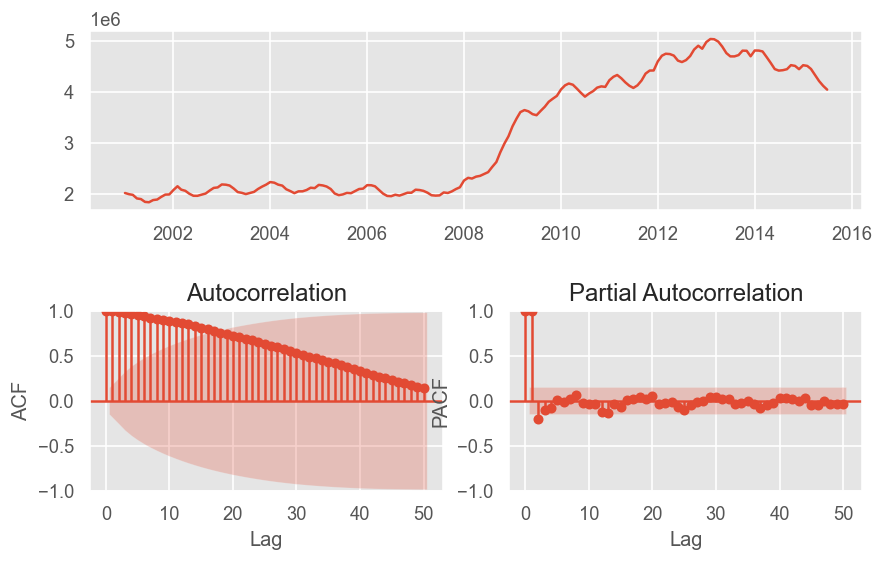

In [5]:
# ACF and PACF of the time series -> identify significant lags and order
FT.ts_display(y_train,lags=50)

#### 2. Stabilize the variance (if needed)

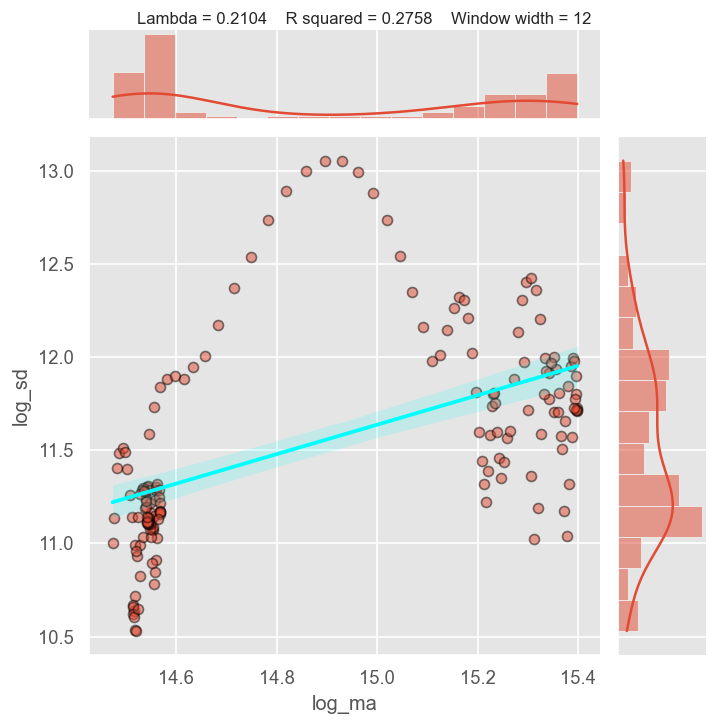

In [6]:
# Box-Cox transformation
lmbda = FT.boxcox_lambda_plot(y_train, window_width=12)

En este caso se aprecia una relación entre ambas, pero una no lineal. Por ello, ambas opciones podrían ser correctas, pero decidimos aplicar Box-Cox ya que creemos que puede ayudar ligeramente, y en los modelos no se observan cambios muy relevantes.

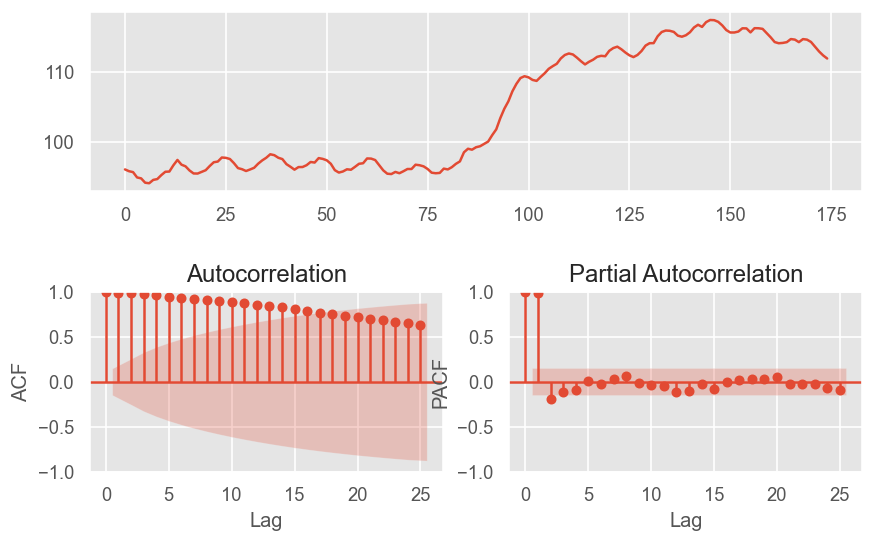

In [7]:
# Compute Box CoxPlot transformed data
BOX_COX = True
if BOX_COX:
    z = st.boxcox(y_train.values[:,0],   lmbda = lmbda) #Convert series to positive if neccesary
    #z,lmbda = st.boxcox(df.values[:,0] - min(df.values) + 1) #Convert to positive and automatic selection of lmbda
    z = pd.DataFrame(z, columns=y_train.columns.values.tolist())
else:
    z = y_train

# Plot transformed data
FT.ts_display(z)

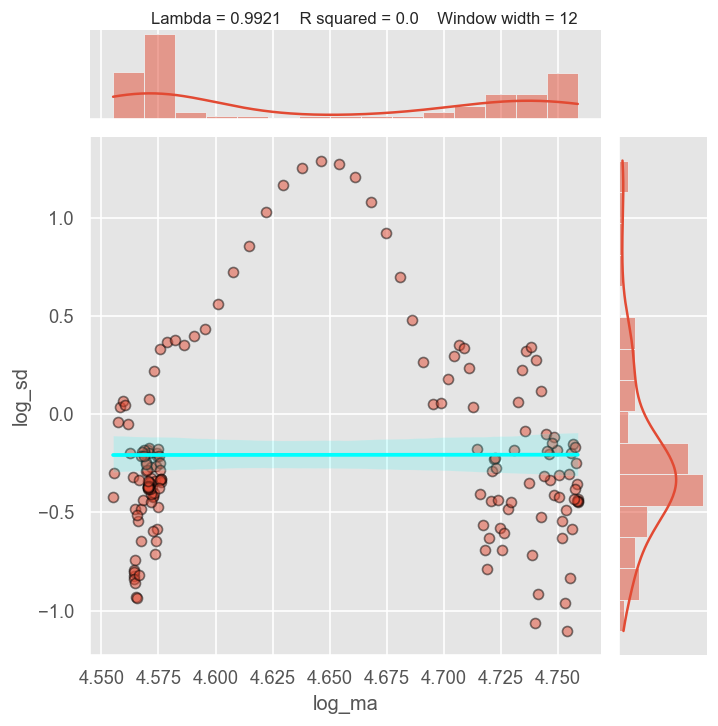

0.9921306069970893

In [8]:
#Check Box Cox of transformed series
FT.boxcox_lambda_plot(z, window_width=12)

#### 3. Analyze stationarity 

In [9]:
# Alternative test - Augmented Dickey Fuller Test
result = adfuller(z.values)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.391117
p-value: 0.586527
Critical Values:
	1%: -3.472
	5%: -2.880
	10%: -2.576


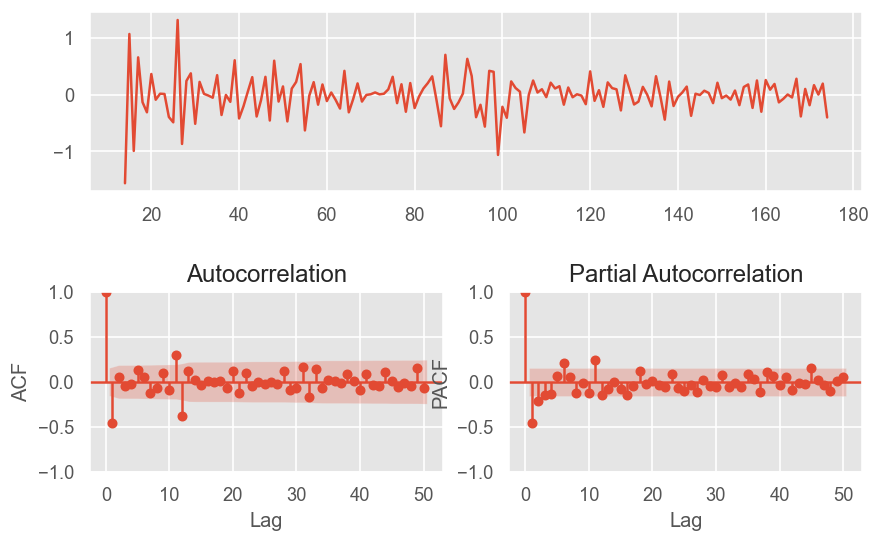

In [10]:
# Difference of the time series
d = 2
D = 1
S = 12 # Seasonality of 12 months

Bz = z
for diff in range(d):
    Bz = Bz.diff().dropna() # drop first NA value
for seas_diff in range(D):
    Bz = Bz.diff(S).dropna() # drop first NA values
FT.ts_display(Bz,lags=50)

Se podría plantear usar solo una diferenciación y aplicar modelos ARMA (se ha comprobado que esto último da ligeramente mejores resultados en entrenamiento, pero peores en test en la predicción y principales métricas).

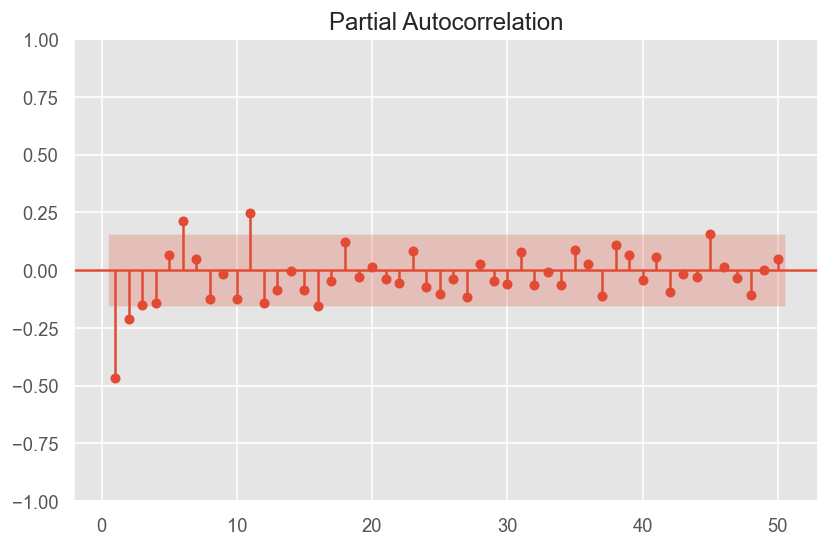

<Figure size 960x600 with 0 Axes>

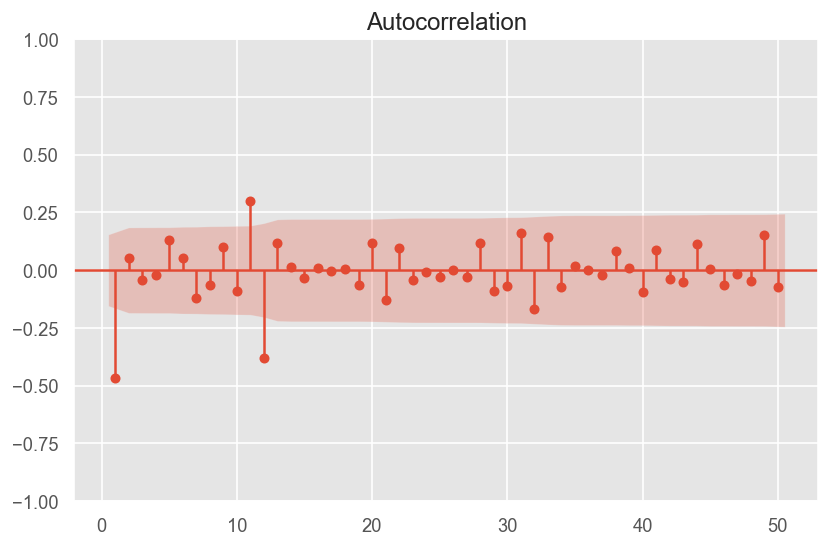

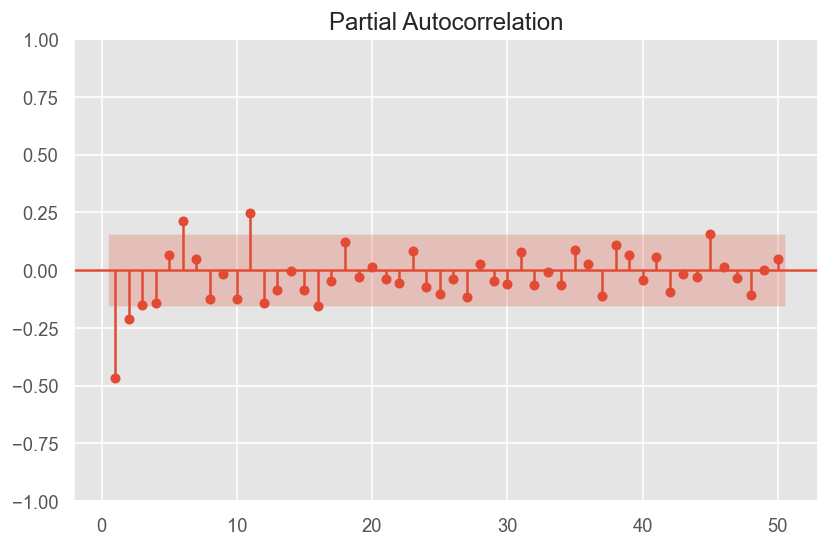

In [11]:
#Bigger plots
plt.figure()
plot_acf(Bz, lags=50,zero=False)
plot_pacf(Bz, lags=50,zero=False)

It seems necessary a moving average model (0,2,1) or an ARMA (1,1,1) for the regular terms, and a mix in the seasonal terms, or a moving average (0,1,1).

#### 5. Fit ARIMA model and check significance of the coefficients

In [12]:
# Fit model with estimated order
sarima_fit = SARIMAX(z, 
                    order=(0,2,1), # Regular components
                    seasonal_order=(0, 1, 1, 12), # Seasonal components
                    trend= 'n', # Type of trend: ['c','t','n','ct'] --> [constant, linear, no trend, constant and linear]
                    enforce_invertibility=True, 
                    enforce_stationarity=True).fit()

print(sarima_fit.summary())

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.96781D-02    |proj g|=  3.02762D-01

At iterate    5    f=  2.23011D-02    |proj g|=  1.45201D-02

At iterate   10    f=  2.16961D-02    |proj g|=  6.89094D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     12     22      1     0     0   4.666D-04   2.170D-02
  F =   2.1695984602812586E-002

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
                                     SARIMAX Results                  

#### 6. Analyze residuals

Se comienzan los residuos en 20 al ser 262 datos, puesto que si se empieza desde 100 sería casi la mitad del conjunto de datos de los que no se estudian los residuos.

Ljung-Box test of residuals:
      lb_stat  lb_pvalue
25  31.821279   0.163249


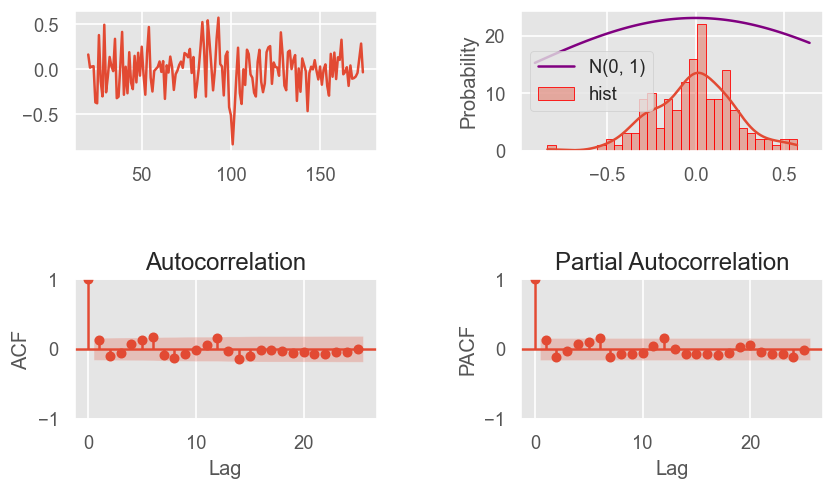

In [13]:
# Plot residual error
FT.check_residuals(pd.DataFrame(sarima_fit.resid.loc[20:]))

Este modelo es válido, siendo el mejor en términos de AIC, BIC, relación entre el número de coeficientes y precisión, etc. No obstante, se puede crear otro modelo incluyendo variables no significativas a costa de unos mejores resultados de residuos, debido a que el sexto residuo parece algo significativo en el anterior gráfico (Puede ser debido a que no se capte de forma perfecta el efecto estacional).

In [14]:
# Fit model with estimated order
sarima_fit2 = SARIMAX(z, 
                    order=(6,2,0), # Regular components
                    seasonal_order=(0, 1, 1, 12), # Seasonal components
                    trend= 'n', # Type of trend: ['c','t','n','ct'] --> [constant, linear, no trend, constant and linear]
                    enforce_invertibility=True, 
                    enforce_stationarity=True).fit()

print(sarima_fit2.summary())

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.56040D-02    |proj g|=  2.14281D-01

At iterate    5    f= -2.75878D-03    |proj g|=  1.87792D-02

At iterate   10    f= -4.13943D-03    |proj g|=  2.77801D-03

At iterate   15    f= -4.14326D-03    |proj g|=  4.01438D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     16     24      1     0     0   1.491D-04  -4.143D-03
  F =  -4.1432576371934820E-003

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
        

#### 6. Analyze residuals

Ljung-Box test of residuals:
      lb_stat  lb_pvalue
25  18.334214   0.827878


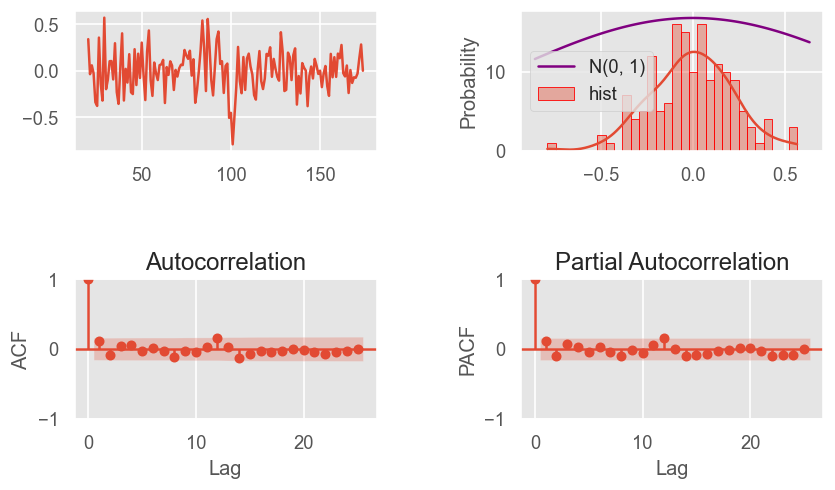

In [15]:
# Plot residual error
FT.check_residuals(pd.DataFrame(sarima_fit2.resid.loc[20:]))

Es mejor en términos de error, pero a grandes rasgos parece más correcto el primero. Observamos a continuación su desempeño en test.

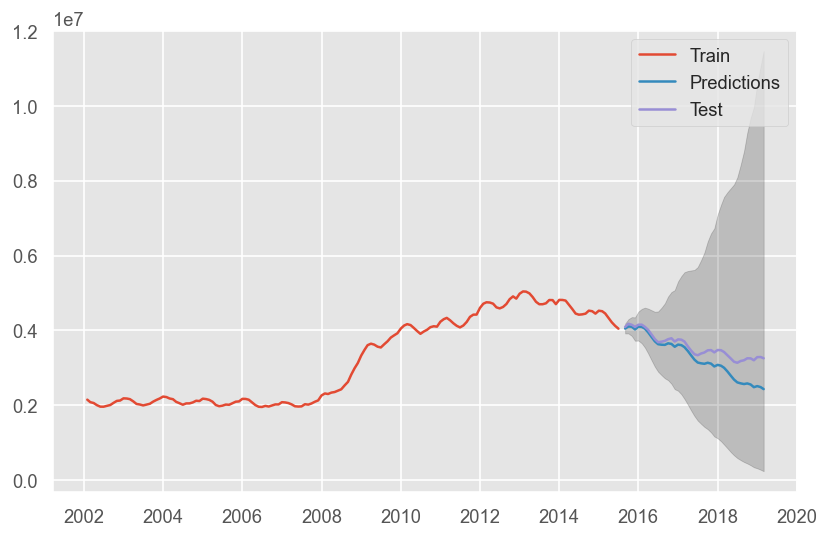

In [16]:
#Obtain forecasts for in-sample and out-of-sample
start = round(0.64*y.shape[0])
end = round(0.8*y.shape[0])
horizon = end - round(0.64*y.shape[0])

pred = sarima_fit.get_prediction(start=start+1, end= end-1, dynamic=False)
yhat = pred.predicted_mean
yhat_conf_int = pred.conf_int(alpha=0.05)

#Undo Box-cox transform if necessary
if BOX_COX:
    yhat = sp.special.inv_boxcox(yhat, lmbda)
    yhat_conf_int = sp.special.inv_boxcox(yhat_conf_int, lmbda)

yhat.index = y.index[start+1:end]

# Asegurarse de que los índices de yhat_conf_int coincidan con y_train
yhat_conf_int.index = y.index[start+1:end]

plt.figure()
plt.fill_between(yhat_conf_int.index,
                yhat_conf_int.iloc[:, 0],
                yhat_conf_int.iloc[:, 1], color='k', alpha=.2)
plt.plot(y_train['2002-02-01':], label = 'Train')
plt.plot(yhat, label = 'Predictions')
plt.plot(y_test, label = 'Test')
plt.legend()
plt.show()

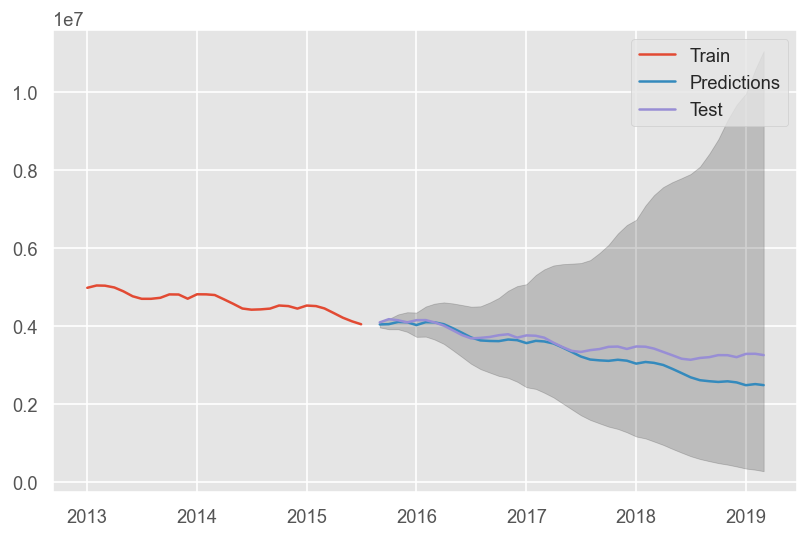

In [17]:
#Obtain forecasts for in-sample and out-of-sample
start = round(0.64*y.shape[0]) + 1
end = round(0.8*y.shape[0])
horizon = end - start

pred = sarima_fit.get_forecast(steps=horizon, dynamic=False)
yhat = pred.predicted_mean
yhat_conf_int = pred.conf_int(alpha=0.05)

#Undo Box-cox transform if necessary
if BOX_COX:
    yhat = sp.special.inv_boxcox(yhat, lmbda)
    yhat_conf_int = sp.special.inv_boxcox(yhat_conf_int, lmbda)

yhat.index = y.index[start:end]

# Asegurarse de que los índices de yhat_conf_int coincidan con y_train
yhat_conf_int.index = y.index[start:end]

plt.figure()
plt.fill_between(yhat_conf_int.index,
                yhat_conf_int.iloc[:, 0],
                yhat_conf_int.iloc[:, 1], color='k', alpha=.2)
plt.plot(y_train['2013-01-01':], label = 'Train')
plt.plot(yhat, label = 'Predictions')
plt.plot(y_test, label = 'Test')
plt.legend()
plt.show()

Resultados de BIC y AIC para los modelos en test:

In [18]:
pred = sarima_fit.get_forecast(steps=horizon, dynamic=False)
yhat = pred.predicted_mean
if BOX_COX:
    yhat = sp.special.inv_boxcox(yhat, lmbda)
    yhat_conf_int = sp.special.inv_boxcox(yhat_conf_int, lmbda)

#Test MAE - Mean Absolute error
print('Test MAE SARIMA 1 d = 2:',mean_absolute_error(y_test, yhat))
#Test RMSE - Root Mean Square Error
print('Test RMSE SARIMA 1 d = 2:',math.sqrt(mean_squared_error(y_test, yhat)))

Test MAE SARIMA 1 d = 2: 266711.98550756724
Test RMSE SARIMA 1 d = 2: 360965.2032924141


In [19]:
# Fit model with estimated order
sarima_fit_aux = SARIMAX(z, 
                    order=(1,1,1), # Regular components
                    seasonal_order=(0, 1, 1, 12), # Seasonal components
                    trend= 'n', # Type of trend: ['c','t','n','ct'] --> [constant, linear, no trend, constant and linear]
                    enforce_invertibility=True, 
                    enforce_stationarity=True).fit()

pred = sarima_fit_aux.get_forecast(steps=horizon, dynamic=False)
yhat = pred.predicted_mean
if BOX_COX:
    yhat = sp.special.inv_boxcox(yhat, lmbda)
    yhat_conf_int = sp.special.inv_boxcox(yhat_conf_int, lmbda)

#Test MAE - Mean Absolute error
print('Test MAE SARIMA 1 d = 1:',mean_absolute_error(y_test, yhat))
#Test RMSE - Root Mean Square Error
print('Test RMSE SARIMA 1 d = 1:',math.sqrt(mean_squared_error(y_test, yhat)))

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.66354D-02    |proj g|=  3.19505D-01

At iterate    5    f=  1.03942D-02    |proj g|=  2.64534D-02


 This problem is unconstrained.



At iterate   10    f=  7.04179D-03    |proj g|=  1.92878D-02

At iterate   15    f=  5.55684D-03    |proj g|=  9.19188D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     26      1     0     0   5.786D-04   5.557D-03
  F =   5.5565166031774993E-003

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Test MAE SARIMA 1 d = 1: 210196.1379714429
Test RMSE SARIMA 1 d = 1: 240055.36278097206


In [20]:
pred = sarima_fit2.get_forecast(steps=horizon, dynamic=False)
yhat = pred.predicted_mean
if BOX_COX:
    yhat = sp.special.inv_boxcox(yhat, lmbda)
    yhat_conf_int = sp.special.inv_boxcox(yhat_conf_int, lmbda)

#Test MAE - Mean Absolute error
print('Test MAE SARIMA 2:',mean_absolute_error(y_test, yhat))
#Test RMSE - Root Mean Square Error
print('Test RMSE SARIMA 2:',math.sqrt(mean_squared_error(y_test, yhat)))

Test MAE SARIMA 2: 234966.39563792147
Test RMSE SARIMA 2: 320135.67674780625


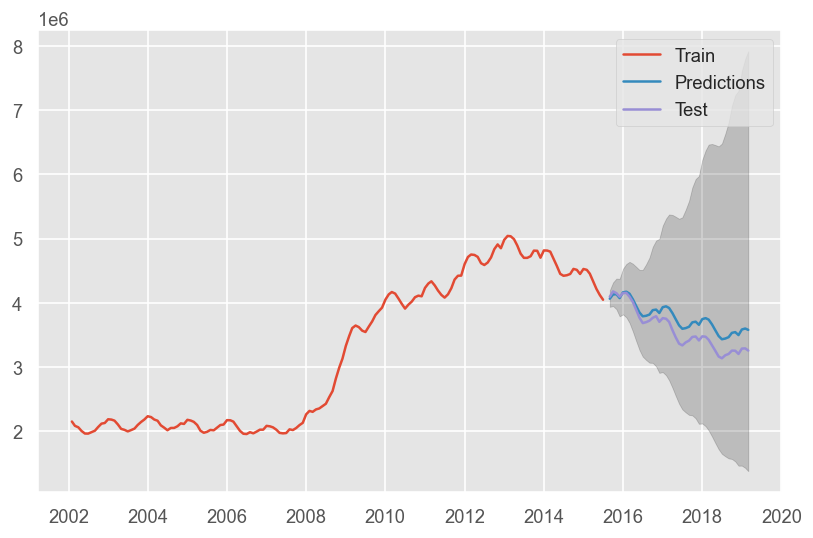

In [21]:
#Obtain forecasts for in-sample and out-of-sample
start = round(0.64*y.shape[0])
end = round(0.8*y.shape[0])
horizon = end - round(0.64*y.shape[0])

pred = sarima_fit_aux.get_prediction(start=start+1, end= end-1, dynamic=False)
yhat = pred.predicted_mean
yhat_conf_int = pred.conf_int(alpha=0.05)

#Undo Box-cox transform if necessary
if BOX_COX:
    yhat = sp.special.inv_boxcox(yhat, lmbda)
    yhat_conf_int = sp.special.inv_boxcox(yhat_conf_int, lmbda)

yhat.index = y.index[start+1:end]

# Asegurarse de que los índices de yhat_conf_int coincidan con y_train
yhat_conf_int.index = y.index[start+1:end]

plt.figure()
plt.fill_between(yhat_conf_int.index,
                yhat_conf_int.iloc[:, 0],
                yhat_conf_int.iloc[:, 1], color='k', alpha=.2)
plt.plot(y_train['2002-02-01':], label = 'Train')
plt.plot(yhat, label = 'Predictions')
plt.plot(y_test, label = 'Test')
plt.legend()
plt.show()

A pesar de lo esperado, el mejor modelo es `sarima_fit_aux` en términos de métricas y simplicidad (con unas predicciones similares), por lo que se usará este modelo a continuación en el conjunto de entrenamiento con prácticamente la totalidad de los datos para reajustar los parámetros sabiendo que es el mejor posible, aplicando los mismos pasos que anteriormente y observando los resultados finales.

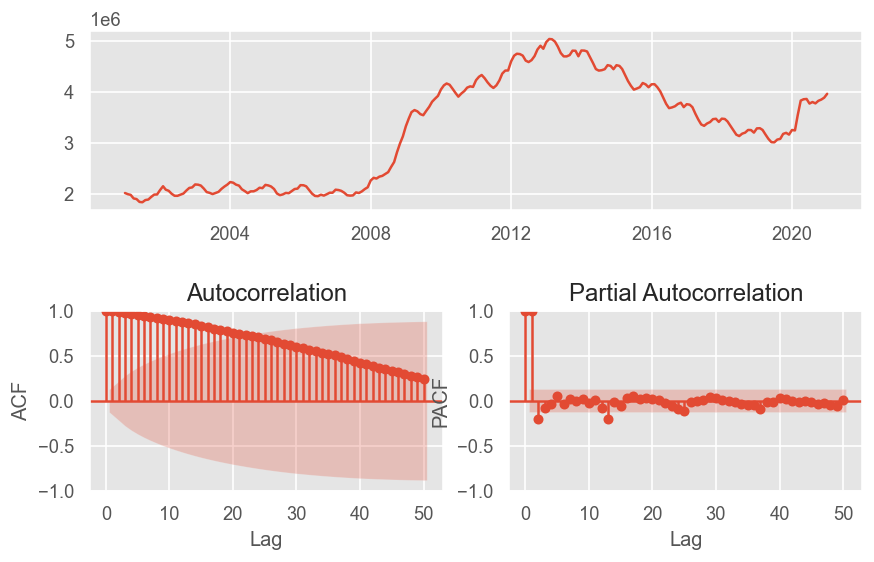

In [22]:
# ACF and PACF of the time series -> identify significant lags and order
FT.ts_display(y_train2,lags=50)

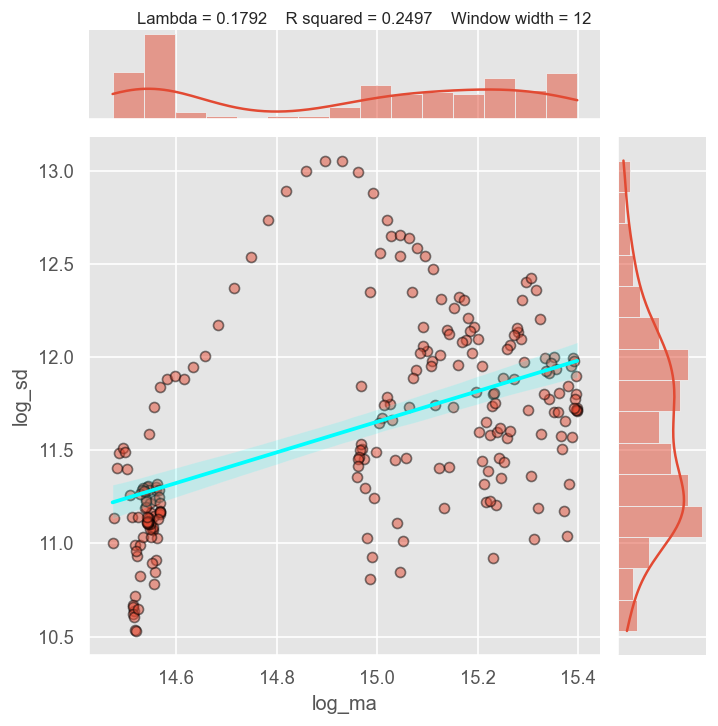

In [23]:
# Box-Cox transformation
lmbda = FT.boxcox_lambda_plot(y_train2, window_width=12)

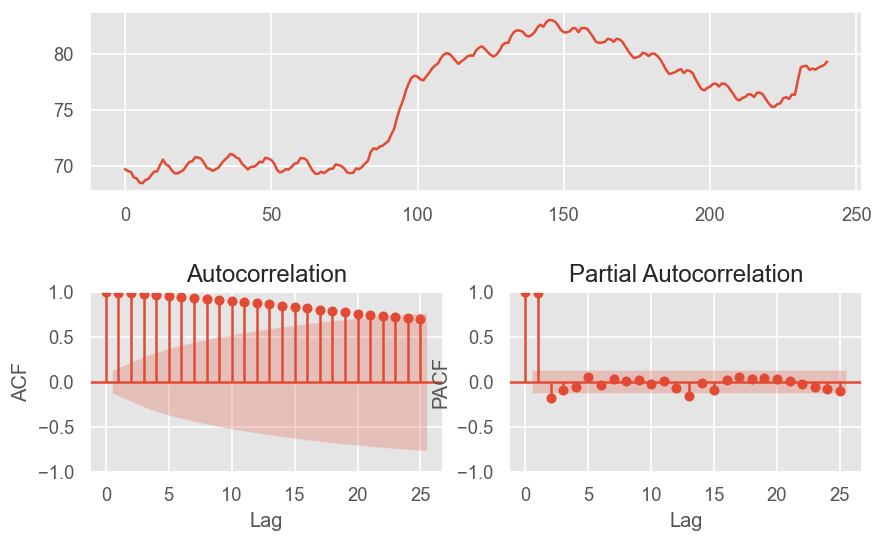

In [24]:
# Compute Box CoxPlot transformed data
BOX_COX = True
if BOX_COX:
    z = st.boxcox(y_train2.values[:,0],   lmbda = lmbda) #Convert series to positive if neccesary
    #z,lmbda = st.boxcox(df.values[:,0] - min(df.values) + 1) #Convert to positive and automatic selection of lmbda
    z = pd.DataFrame(z, columns=y_train2.columns.values.tolist())
else:
    z = y_train2

# Plot transformed data
FT.ts_display(z)

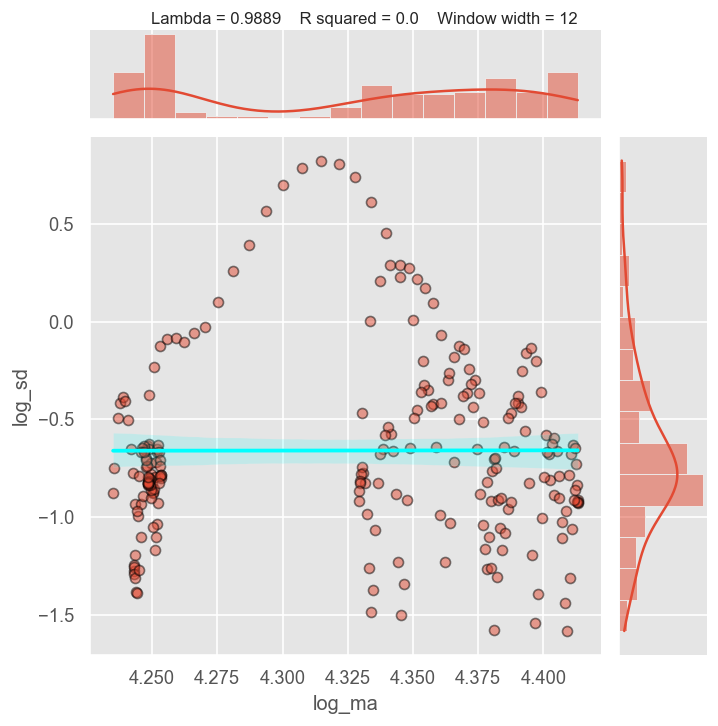

0.9889334090138504

In [25]:
#Check Box Cox of transformed series
FT.boxcox_lambda_plot(z, window_width=12)

In [26]:
# Alternative test - Augmented Dickey Fuller Test
result = adfuller(z.values)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.593455
p-value: 0.486880
Critical Values:
	1%: -3.459
	5%: -2.874
	10%: -2.574


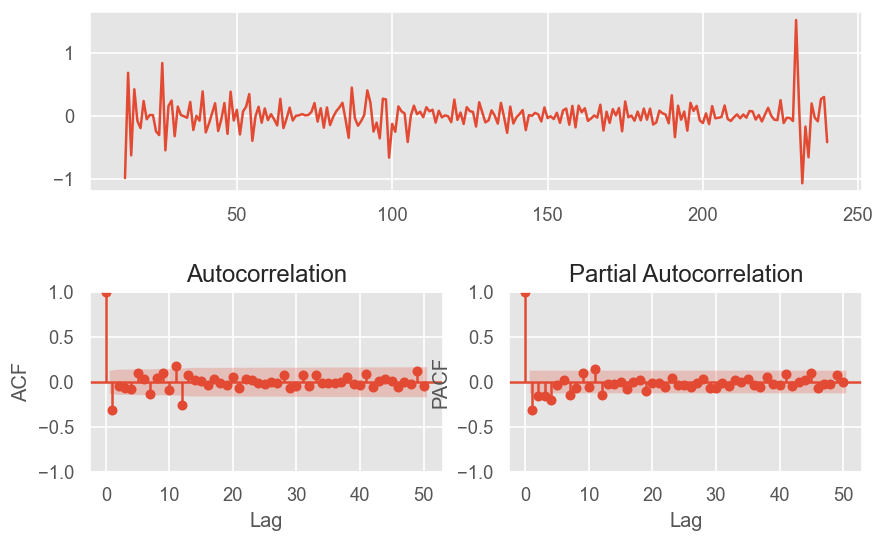

In [27]:
# Difference of the time series
d = 2
D = 1
S = 12 # Seasonality of 12 months

Bz = z
for diff in range(d):
    Bz = Bz.diff().dropna() # drop first NA value
for seas_diff in range(D):
    Bz = Bz.diff(S).dropna() # drop first NA values
FT.ts_display(Bz,lags=50)

Parece que nos lleva a resultados similares, aunque al final de la serie se observa un cambio muy grande en la serie debido a lo anteriormente comentado: el COVID.

In [28]:
# Fit model with estimated order
sarima_fit = SARIMAX(z, 
                    order=(1,2,1), # Regular components
                    seasonal_order=(0, 1, 1, 12), # Seasonal components
                    trend= 'n', # Type of trend: ['c','t','n','ct'] --> [constant, linear, no trend, constant and linear]
                    enforce_invertibility=True, 
                    enforce_stationarity=True).fit()

print(sarima_fit.summary())

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.93995D-01    |proj g|=  4.34538D-01

At iterate    5    f= -2.13073D-01    |proj g|=  1.56355D-01

At iterate   10    f= -2.19584D-01    |proj g|=  4.35490D-01

At iterate   15    f= -2.25959D-01    |proj g|=  7.67286D-03

At iterate   20    f= -2.26892D-01    |proj g|=  2.44331D-02

At iterate   25    f= -2.27217D-01    |proj g|=  1.64591D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     28     42      1     0     0   

Observamos que en este caso admite también un término autorregresivo, siendo éste un pequeño reajuste como los que hablábamos.

Ljung-Box test of residuals:
     lb_stat  lb_pvalue
25  9.946319   0.996794


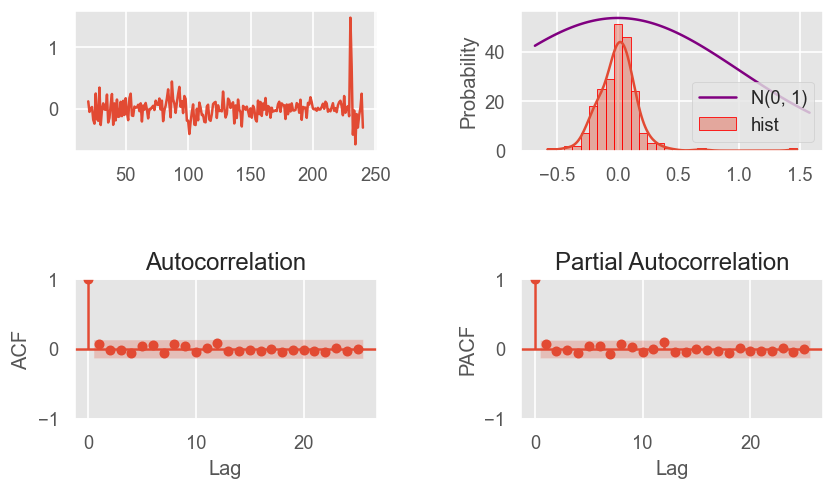

In [29]:
# Plot residual error
FT.check_residuals(pd.DataFrame(sarima_fit.resid.loc[20:]))

El error es bastante bueno, se observan a continuación diversas métricas y la predicción.

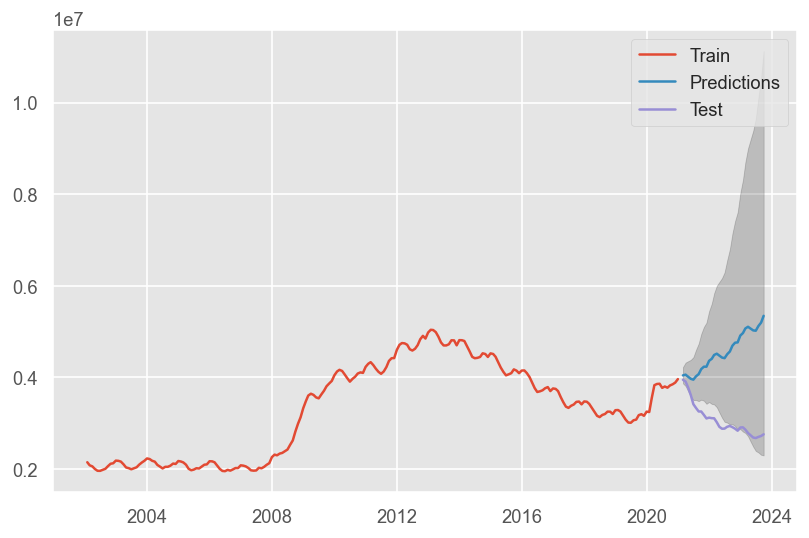

In [30]:
#Obtain forecasts for in-sample and out-of-sample
start = round(prop_train*y.shape[0])
end = round(y.shape[0])
horizon = end - round(prop_train*y.shape[0])

pred = sarima_fit.get_prediction(start=start+1, end= end-1, dynamic=False)
yhat = pred.predicted_mean
yhat_conf_int = pred.conf_int(alpha=0.05)

#Undo Box-cox transform if necessary
if BOX_COX:
    yhat = sp.special.inv_boxcox(yhat, lmbda)
    yhat_conf_int = sp.special.inv_boxcox(yhat_conf_int, lmbda)

yhat.index = y.index[start+1:end]

# Asegurarse de que los índices de yhat_conf_int coincidan con y_train
yhat_conf_int.index = y.index[start+1:end]

plt.figure()
plt.fill_between(yhat_conf_int.index,
                yhat_conf_int.iloc[:, 0],
                yhat_conf_int.iloc[:, 1], color='k', alpha=.2)
plt.plot(y_train2['2002-02-01':], label = 'Train')
plt.plot(yhat, label = 'Predictions')
plt.plot(y_test2, label = 'Test')
plt.legend()
plt.show()

Como se puede observar, la predicción es bastante mala, no captando en absoluto la bajada. Por tanto, se pueden probar otros modelos como el inicial (0,2,1) o el otro posible comentado al comienzo con una diferenciación (1,1,1). El primero mejora algo los errores, pero sigue sin captar la tendencia. El segundo, sin embargo, además de ser más sencillo, sus resultados son mejores, pero tiene una explicación.

In [31]:
#Test MAE - Mean Absolute error
print('Test MAE SARIMA 1 d = 2:',mean_absolute_error(y_test2, yhat))
#Test RMSE - Root Mean Square Error
print('Test RMSE SARIMA 1 d = 2:',math.sqrt(mean_squared_error(y_test2, yhat)))

Test MAE SARIMA 1 d = 2: 1497247.6631776781
Test RMSE SARIMA 1 d = 2: 1663251.3686611715


In [32]:
# Fit model with estimated order
sarima_fit2 = SARIMAX(z, 
                    order=(1,1,1), # Regular components
                    seasonal_order=(0, 1, 1, 12), # Seasonal components
                    trend= 'n', # Type of trend: ['c','t','n','ct'] --> [constant, linear, no trend, constant and linear]
                    enforce_invertibility=True, 
                    enforce_stationarity=True).fit()

print(sarima_fit2.summary())

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.88543D-01    |proj g|=  1.44166D-01

At iterate    5    f= -2.32282D-01    |proj g|=  2.27931D-02


 This problem is unconstrained.



At iterate   10    f= -2.33557D-01    |proj g|=  3.13827D-03

At iterate   15    f= -2.33641D-01    |proj g|=  1.83527D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     17     25      1     0     0   5.812D-04  -2.336D-01
  F = -0.23364088519840137     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
                                     SARIMAX Results                                      
Dep. Variable:                              TOTAL   No. Observations:                  241
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood                  56.307
Date:                     

Ljung-Box test of residuals:
      lb_stat  lb_pvalue
25  15.480245    0.92943


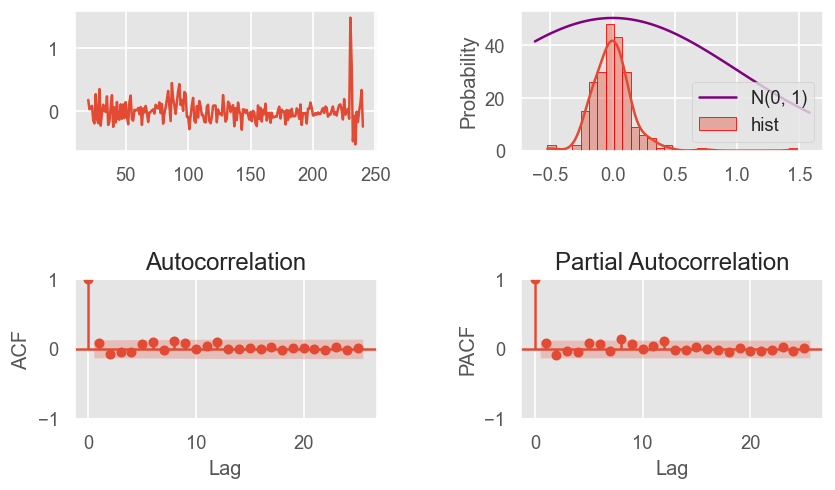

In [33]:
# Plot residual error
FT.check_residuals(pd.DataFrame(sarima_fit2.resid.loc[20:]))

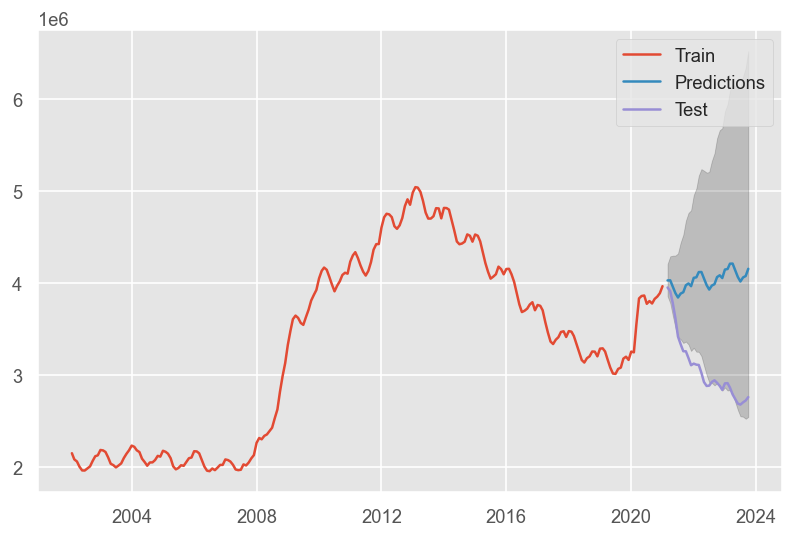

In [34]:
#Obtain forecasts for in-sample and out-of-sample
start = round(prop_train*y.shape[0])
end = round(y.shape[0])
horizon = end - round(prop_train*y.shape[0])

pred = sarima_fit2.get_prediction(start=start+1, end= end-1, dynamic=False)
yhat = pred.predicted_mean
yhat_conf_int = pred.conf_int(alpha=0.05)

#Undo Box-cox transform if necessary
if BOX_COX:
    yhat = sp.special.inv_boxcox(yhat, lmbda)
    yhat_conf_int = sp.special.inv_boxcox(yhat_conf_int, lmbda)

yhat.index = y.index[start+1:end]

# Asegurarse de que los índices de yhat_conf_int coincidan con y_train
yhat_conf_int.index = y.index[start+1:end]

plt.figure()
plt.fill_between(yhat_conf_int.index,
                yhat_conf_int.iloc[:, 0],
                yhat_conf_int.iloc[:, 1], color='k', alpha=.2)
plt.plot(y_train2['2002-02-01':], label = 'Train')
plt.plot(yhat, label = 'Predictions')
plt.plot(y_test2, label = 'Test')
plt.legend()
plt.show()

In [35]:
#Test MAE - Mean Absolute error
print('Test MAE SARIMA 1 d = 1:',mean_absolute_error(y_test2, yhat))
#Test RMSE - Root Mean Square Error
print('Test RMSE SARIMA 1 d = 1:',math.sqrt(mean_squared_error(y_test2, yhat)))

Test MAE SARIMA 1 d = 1: 969152.2836484313
Test RMSE SARIMA 1 d = 1: 1046467.7978979676


Como se puede observar, este modelo menos complejo simplemente sigue con mayor exactitud los últimos datos reales, por lo que su menor error es pura coincidencia, fruto de la bajada repentina, pero no quiere decir que en general sea un mejor modelo o sobreajuste menos que los anteriores (aún así, su intervalo de confianza es menor, lo cual es bueno). De hecho, parecen modelos más precisos los previos, pero claramente ninguno es capaz de capturar esa gran bajada, como es lógico.

No obstante, los residuos son claramente independientes en todos los casos, y no se observa ningún retardo significativo. No obstante, se puede ver un gran outlier que, junto con lo comentado anteriormente, nos indica de la gran necesidad de añadir algún tipo de tendencia o parámetro para modelar los efectos del COVID como, por ejemplo, una variable de intervención. Por tanto, ése será el siguiente paso.

# **SARIMAX**

Se procede a incluir una variable de intervención que palie el efecto provocado por el COVID en nuestra serie temporal.

Esta variable simplemente será una binaria que tome el valor 1 para observaciones en fechas dentro del periodo en que el COVID tuvo un efecto en la serie, y 0 para las fechas fuera de dicho periodo.

In [36]:
df['COVID']=0

# Definir el período de COVID-19 (por ejemplo, desde marzo de 2020 hasta la fecha final)
periodo_covid_inicio = pd.to_datetime('2020-03-01')
periodo_covid_fin_1 = pd.to_datetime('2021-07-01') #Parece que aquí termina su influencia en nuestra serie
# Establecer los valores de la columna 'Periodo_Covid' a 1 durante el periodo de COVID-19
df.loc[periodo_covid_inicio:periodo_covid_fin_1, 'COVID'] = 1


df['COVID'].describe()#únicamente el COVID afecta a un 11% de nuestras observaciones

count    274.000000
mean       0.062044
std        0.241676
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        1.000000
Name: COVID, dtype: float64

In [37]:
INPUTS_SARMAX = ['COVID']
OUTPUT = 'TOTAL'

# We have categorical inputs with many classes. We will create dummy variables automatically after
X = df[INPUTS_SARMAX]
y = df[OUTPUT]

## Divide the data into training and test sets SEQUENTIALY -------------------------------------
# Create random 80/20 % split
X_train2 = X.iloc[0:round(prop_train*X.shape[0])]
X_test2 = X.iloc[round(prop_train*X.shape[0])+1:X.shape[0]]
y_train2 = y.iloc[0:round(prop_train*X.shape[0])]#Esto creo que está hecho arriba, luego lo cambio
y_test2 = y.iloc[round(prop_train*X.shape[0])+1:X.shape[0]]



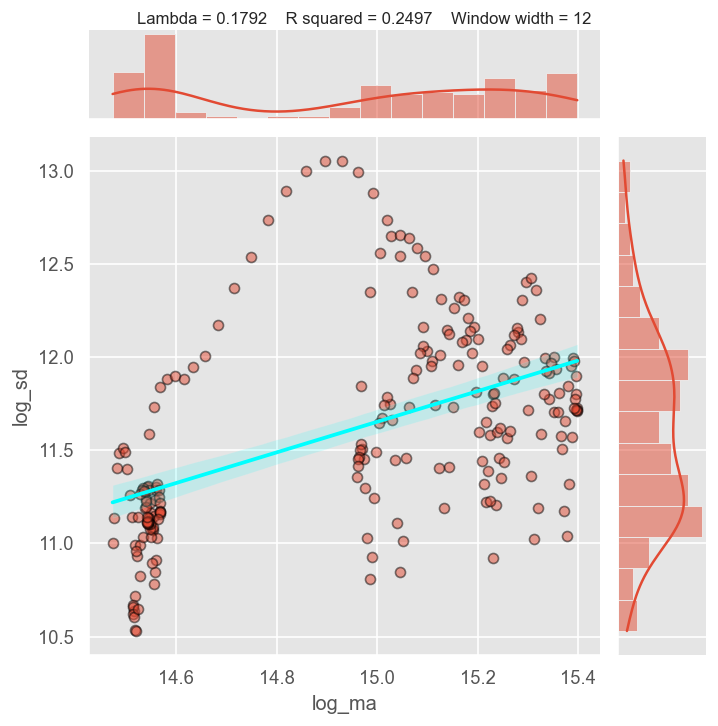

In [38]:
lmbda = FT.boxcox_lambda_plot(y_train2, window_width=12)

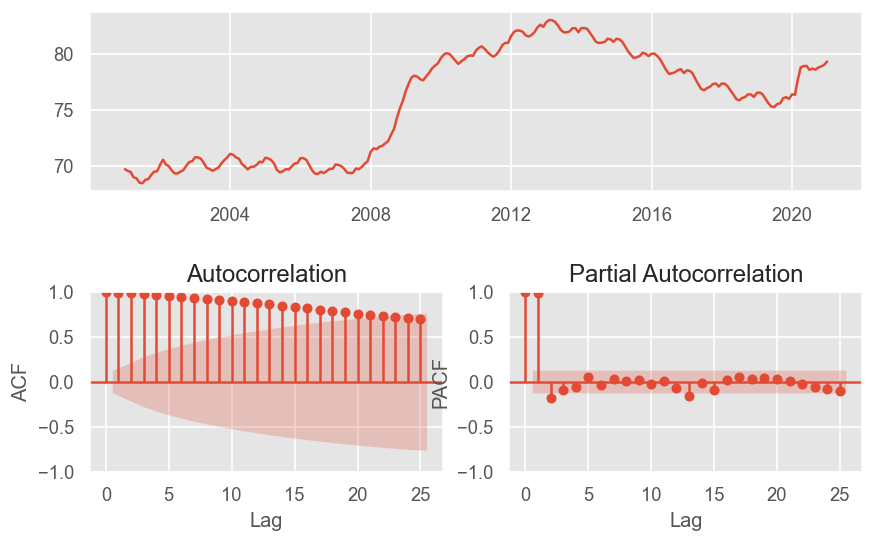

In [39]:
#!!!!!Revisar si hace falta o con lo hecho por Juan vale
# Compute Box CoxPlot transformed data
BOX_COX = True
if BOX_COX:
    z = st.boxcox(y_train2.values,   lmbda = lmbda) #Convert series to positive if neccesary
    #z,lmbda = st.boxcox(df.values[:,0] - min(df.values) + 1) #Convert to positive and automatic selection of lmbda
    z = pd.DataFrame(z, columns=y_train.columns.values.tolist())
else:
    z = y_train2

# Plot transformed data
z.index=y_train2.index
FT.ts_display(z)

In [40]:
#time_varying_regression
# We could also fit a more complicated model with ARMA with seasonal components.
mod_sarimax = sm.tsa.SARIMAX(endog = z, 
                            order=(1,1,1),
                            seasonal_order=(0,1,1,12),
                            exog = X_train2[INPUTS_SARMAX],
                            trend='n',
                            enforce_invertibility=True, 
                            enforce_stationarity=True,
                            time_varying_regression=False,
                            mle_regression=True)
res_sarimax = mod_sarimax.fit()

# Show the summary of results
print(res_sarimax.summary())

/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.37476D-01    |proj g|=  1.46473D-01

At iterate    5    f= -2.89958D-01    |proj g|=  1.27752D-01

At iterate   10    f= -3.03543D-01    |proj g|=  7.12624D-03

At iterate   15    f= -3.03760D-01    |proj g|=  1.74526D-02

At iterate   20    f= -3.03787D-01    |proj g|=  2.37057D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     22     26      1     0     0   1.339D-04  -3.038D-01
  F = -0.30378660857651790     

CONVERG

Ljung-Box test of residuals:
      lb_stat  lb_pvalue
50  35.537563   0.939045


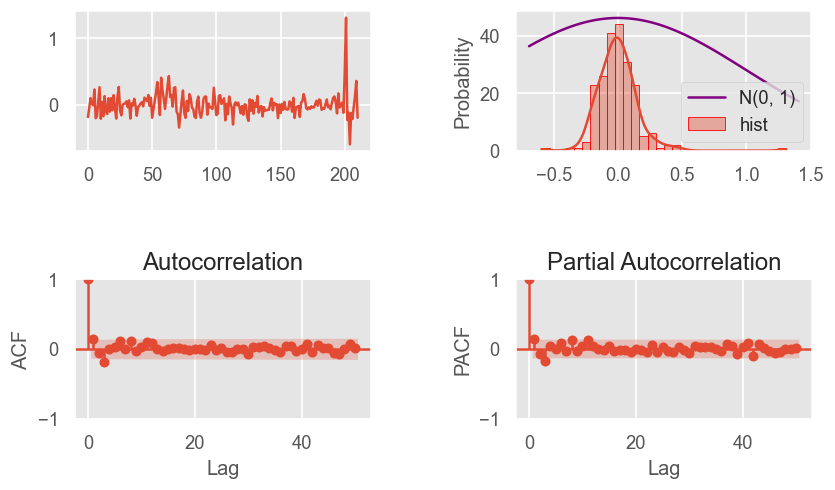

In [41]:
# Plot residual error
plt.rcParams.update({'figure.figsize': (8, 5), 'figure.dpi': 120})
FT.check_residuals(pd.DataFrame(res_sarimax.resid.values[30:]),lags=50)
 

Se ha iniciando probando el modelo óptimo obtenido en el SARIMA(1,2,1)x(0,1,1,12) obteniendo resultados muy malos para los residuos, tras ello se han seguido probando modelos incluyendo diferenciación tanto regular como estacional en los modelos, siempre observando correlaciones parciales muy altas entre los residuos de la serie y sus retardos estacionales(E(12),E(24),E(36,...)).Cambiar los parámetros del sarimax en el código para ver este fenómeno.

Por último, se decidió eliminar la diferenciación estacional para ver si de esta manera se conseguía eliminar este efecto, y se consiguió, llegando al modelo óptimo mostrado arriba, en que prácticamenete con un 100% de confianza se afirma que los residuos del modelo son ruido blanco(Ver p-valor del test de Ljung-Box).

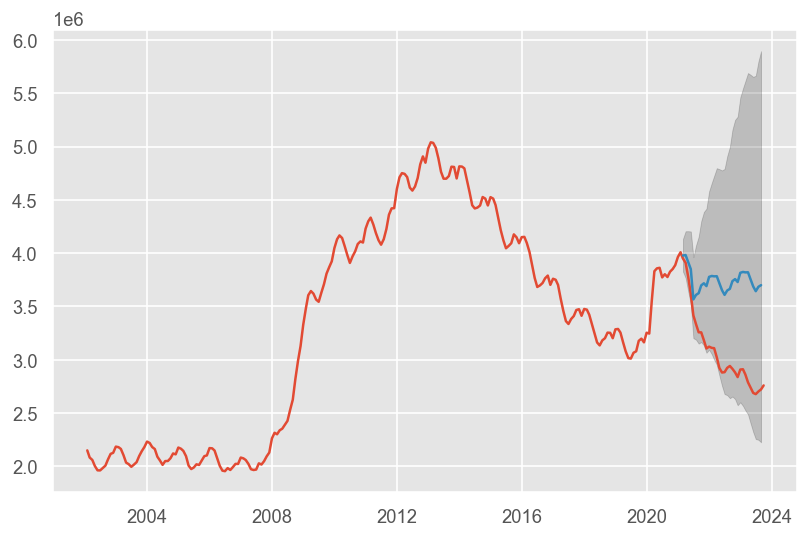

In [42]:
#Obtain forecasts for in-sample and out-of-sample
start = round(prop_train*y.shape[0])
end = round(y.shape[0])
horizon = end - start

pred = res_sarimax.get_prediction(start=start+1, 
                                    end= end-2, 
                                    exog = X_test2[INPUTS_SARMAX],
                                    dynamic=False)
yhat = pred.predicted_mean
yhat_conf_int = pred.conf_int(alpha=0.05)

#Undo Box-cox transform if necessary
if BOX_COX:
    yhat = sp.special.inv_boxcox(yhat, lmbda)
    yhat_conf_int = sp.special.inv_boxcox(yhat_conf_int, lmbda)

yhat.index = y.index[start+1:end-1]


plt.figure()
plt.fill_between(yhat_conf_int.index,
                yhat_conf_int.iloc[:, 0],
                yhat_conf_int.iloc[:, 1], color='k', alpha=.2)
plt.plot(y['2002-02-01':])
plt.plot(yhat['2002-02-01':])
plt.show()

In [43]:
 #Test MAE - Mean Absolute error
y_test2=y_test2[:'2023-09-01']
print('Test MAE SARIMA 1 d = 2:',mean_absolute_error(y_test2, yhat))
#Test RMSE - Root Mean Square Error
print('Test RMSE SARIMA 1 d = 2:',math.sqrt(mean_squared_error(y_test2, yhat)))

Test MAE SARIMA 1 d = 2: 666925.6499398679
Test RMSE SARIMA 1 d = 2: 732273.4485180117


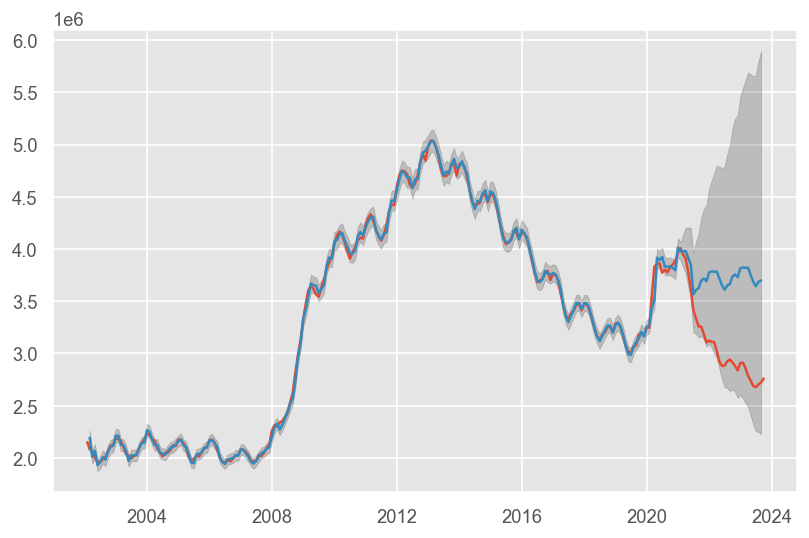

In [44]:
#Obtain forecasts for in-sample and out-of-sample
start = 13
end = round(y.shape[0])

pred = res_sarimax.get_prediction(start=start+1, 
                                    end= end-2, 
                                    exog = X_test2[INPUTS_SARMAX],
                                    dynamic=False)
yhat = pred.predicted_mean
yhat_conf_int = pred.conf_int(alpha=0.05)

#Undo Box-cox transform if necessary
if BOX_COX:
    yhat = sp.special.inv_boxcox(yhat, lmbda)
    yhat_conf_int = sp.special.inv_boxcox(yhat_conf_int, lmbda)

yhat.index = y.index[start+1:end-1]

plt.figure()
plt.fill_between(yhat_conf_int.index,
                yhat_conf_int.iloc[:, 0],
                yhat_conf_int.iloc[:, 1], color='k', alpha=.2)
plt.plot(y['2002-02-01':])
plt.plot(yhat['2002-02-01':])
plt.show()

# MLP_SIN_COVID

In [92]:
###Include lagged variables
dfT = df[['TOTAL']].copy()
dfT['TOTAL_lag1'] = dfT['TOTAL'].shift()
dfT['TOTAL_lag2'] = dfT['TOTAL'].shift(2)
dfT['TOTAL_lag3'] = dfT['TOTAL'].shift(3)
dfT['TOTAL_lag4'] = dfT['TOTAL'].shift(12)
#dfT['TOTAL_lag5'] = dfT['TOTAL'].shift(13)

dfT.head()

TOTAL  TOTAL_lag1  TOTAL_lag2  TOTAL_lag3  TOTAL_lag4
DATE                                                               
2001-01-01  2017389         NaN         NaN         NaN         NaN
2001-02-01  1993273   2017389.0         NaN         NaN         NaN
2001-03-01  1981006   1993273.0   2017389.0         NaN         NaN
2001-04-01  1910453   1981006.0   1993273.0   2017389.0         NaN
2001-05-01  1898285   1910453.0   1981006.0   1993273.0         NaN

In [93]:
# Remove missing
dfT.dropna(inplace=True)
dfT.head()

TOTAL  TOTAL_lag1  TOTAL_lag2  TOTAL_lag3  TOTAL_lag4
DATE                                                               
2002-01-01  2075022   1988716.0   1985857.0   1940910.0   2017389.0
2002-02-01  2149907   2075022.0   1988716.0   1985857.0   1993273.0
2002-03-01  2083103   2149907.0   2075022.0   1988716.0   1981006.0
2002-04-01  2060069   2083103.0   2149907.0   2075022.0   1910453.0
2002-05-01  2002923   2060069.0   2083103.0   2149907.0   1898285.0

In [94]:
# Define input and output matrices
INPUTS = ['TOTAL_lag1','TOTAL_lag2','TOTAL_lag3','TOTAL_lag4']
OUTPUT = 'TOTAL'

# We have categorical inputs with many classes. We will create dummy variables automatically after
X = dfT[INPUTS]
y = dfT[OUTPUT]

## Divide the data into training and test sets SEQUENTIALY -------------------------------------
# Create random 80/20 % split
X_train = X.iloc[0:round(0.64*y.shape[0])]
X_test = X.iloc[round(0.64*y.shape[0])+1:round(0.8*y.shape[0])]
y_train = y.iloc[0:round(0.64*y.shape[0])]
y_test = y.iloc[round(0.64*y.shape[0])+1:round(0.8*y.shape[0])]

## Create dataset to store model predictions
dfTR_eval = X_train.copy()
dfTR_eval['TOTAL'] = y_train # We will call Y as output variable for simplicity
dfTS_eval = X_test.copy()
dfTS_eval['TOTAL'] = y_test # We will call Y as output variable for simplicity

X_train.head()

TOTAL_lag1  TOTAL_lag2  TOTAL_lag3  TOTAL_lag4
DATE                                                      
2002-01-01   1988716.0   1985857.0   1940910.0   2017389.0
2002-02-01   2075022.0   1988716.0   1985857.0   1993273.0
2002-03-01   2149907.0   2075022.0   1988716.0   1981006.0
2002-04-01   2083103.0   2149907.0   2075022.0   1910453.0
2002-05-01   2060069.0   2083103.0   2149907.0   1898285.0

In [137]:
#------------------------------- MLP Regression MODEL -------------------------------------------------
## Inputs of the model. Change accordingly to perform variable selection
INPUTS_MLP_NUM = ['TOTAL_lag1','TOTAL_lag2','TOTAL_lag3','TOTAL_lag4']
INPUTS_MLP_CAT = [] #Weekday is numerical in this case - Intervention variables
INPUTS_MLP = INPUTS_MLP_NUM + INPUTS_MLP_CAT

numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

# Create a preprocessor to perform the steps defined above
preprocessor = ColumnTransformer(transformers=[
        ('num', numeric_transformer, INPUTS_MLP_NUM)
        ])

param = {'MLP__alpha': [0.0001,0.001,0.01,0.1,1], # Initial value of regularization
         'MLP__hidden_layer_sizes':[(5,),(13,),(20,),(25,),(30,)]} # Number of neurons in each hidden layer, enters as tuples

pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('MLP', MLPRegressor(solver='lbfgs', # Update function
                activation='logistic', # Logistic sigmoid activation function
                max_iter=450, # Maximum number of iterations
                tol=1e-4, # Tolerance for the optimization
                random_state=150,
                verbose = True))]) # For replication

# We use Grid Search Cross Validation to find the best parameter for the model in the grid defined 
nFolds = 10
MLP_fit = GridSearchCV(estimator=pipe, # Structure of the model to use
                       param_grid=param, # Defined grid to search in
                       n_jobs=-1, # Number of cores to use (parallelize)
                       scoring='neg_mean_squared_error', # RMSE https://scikit-learn.org/stable/modules/model_evaluation.html
                       cv=nFolds) # Number of Folds 
MLP_fit.fit(X_train[INPUTS_MLP], y_train) # Search in grid
print("MLP Trained")

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           31     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.30761D+12    |proj g|=  3.36520D+06

At iterate    1    f=  6.30605D+12    |proj g|=  6.35355D+07
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           31     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.30262D+12    |proj g|=  3.36282D+06

At iterate    2    f=  4.25231D+12    |proj g|=  2.64216D+06

At iterate    3    f=  1.35478D+12    |proj g|=  8.60456D+05

At iterate    4    f=  2.36375D+11    |proj g|=  4.14883D+05

At iterate    1    f=  6.30105D+12    |proj g|=  6.33721D+07

At iterate    5    f=  7.28660D+10    |proj g|=  9.40540D+04

At iterate    6    f=  6.71477D+10    |proj g|=  4.92047D+04

At iterate    7    f=  6.52856D+10    |proj g|=  2.96927D+04

At iterate    2    f=  4.24617D+12    |proj g

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Nonpositive definiteness in Cholesky factorization in formt;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This probl


At iterate    9    f=  5.76824D+10    |proj g|=  4.71155D+04

At iterate   10    f=  5.44508D+10    |proj g|=  1.08353D+04

At iterate   11    f=  5.43982D+10    |proj g|=  4.31247D+03

At iterate   12    f=  5.43632D+10    |proj g|=  1.04182D+03

At iterate   13    f=  5.43605D+10    |proj g|=  4.01229D+02

At iterate   14    f=  5.43590D+10    |proj g|=  5.48212D+02

At iterate   15    f=  5.43544D+10    |proj g|=  1.03704D+03

At iterate   16    f=  5.43445D+10    |proj g|=  1.52448D+03

At iterate   17    f=  5.43413D+10    |proj g|=  2.64683D+03

At iterate   18    f=  5.43360D+10    |proj g|=  7.12684D+02

At iterate   19    f=  5.43351D+10    |proj g|=  2.13122D+02

At iterate   20    f=  5.43350D+10    |proj g|=  3.04587D+01

At iterate   21    f=  5.43350D+10    |proj g|=  2.48265D+00

At iterate   22    f=  5.43350D+10    |proj g|=  4.36185D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments 

 This problem is unconstrained.


 g|=  1.45465D+05

At iterate   81    f=  2.85602D+10    |proj g|=  1.16683D+06

At iterate   30    f=  2.38156D+10    |proj g|=  5.65906D+03

At iterate   70    f=  7.61697D+10    |proj g|=  6.97271D+04

At iterate   31    f=  2.37329D+10    |proj g|=  2.84457D+03

At iterate   71    f=  7.61697D+10    |proj g|=  2.31110D+05

At iterate   32    f=  2.36862D+10    |proj g|=  1.00901D+03

At iterate   72    f=  7.61696D+10    |proj g|=  5.30847D+05

At iterate   33    f=  2.36529D+10    |proj g|=  2.28516D+03

At iterate   82    f=  2.85441D+10    |proj g|=  2.45811D+06

At iterate   73    f=  7.61696D+10    |proj g|=  4.20953D+06

At iterate   34    f=  2.36127D+10    |proj g|=  2.73484D+03

At iterate   83    f=  2.84958D+10    |proj g|=  4.53818D+06

At iterate   35    f=  2.36020D+10    |proj g|=  2.64786D+03

At iterate   36    f=  2.35883D+10    |proj g|=  1.10145D+03

At iterate   84    f=  2.84884D+10    |proj g|=  2.44357D+06

At iterate   37    f=  2.35843D+10    |proj g|=  4.


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.



At iterate   37    f=  1.02837D+10    |proj g|=  6.50652D+07

At iterate  201    f=  1.29280D+10    |proj g|=  1.89484D+03

At iterate  164    f=  2.76996D+10    |proj g|=  2.98421D+07

At iterate  117    f=  1.80820D+10    |proj g|=  8.36131D+07

At iterate  202    f=  1.28249D+10    |proj g|=  3.54843D+03

At iterate   38    f=  1.02614D+10    |proj g|=  4.40142D+07

At iterate  203    f=  1.27068D+10    |proj g|=  4.81190D+03

At iterate   39    f=  1.02547D+10    |proj g|=  2.29479D+07


At iterate  165    f=  2.76912D+10    |proj g|=  3.82490D+07
At iterate  118    f=  1.80707D+10    |proj g|=  7.35717D+07

At iterate  204    f=  1.25118D+10    |proj g|=  5.44340D+03

At iterate   40    f=  1.02458D+10    |proj g|=  8.28153D+06

At iterate  205    f=  1.21182D+10    |proj g|=  7.44123D+03

At iterate   41    f=  1.02359D+10    |proj g|=  1.67728D+07

At iterate  206    f=  1.18139D+10    |proj g|=  4.09228D+03

At iterate   42    f=  1.02144D+10    |proj g|=  1.11264D+07

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.



At iterate  123    f=  2.97980D+10    |proj g|=  3.24879D+04

At iterate   84    f=  9.77763D+09    |proj g|=  1.00351D+06

At iterate   40    f=  1.50045D+10    |proj g|=  2.22921D+07

At iterate  314    f=  1.65055D+10    |proj g|=  4.06542D+06

At iterate   85    f=  9.77756D+09    |proj g|=  1.27909D+05

At iterate   86    f=  9.77754D+09    |proj g|=  2.91628D+05

At iterate  315    f=  1.65050D+10    |proj g|=  2.33965D+06

At iterate   87    f=  9.77752D+09    |proj g|=  3.19528D+05

At iterate   41    f=  1.50030D+10    |proj g|=  7.94009D+06

At iterate  316    f=  1.65041D+10    |proj g|=  1.25742D+06

At iterate   88    f=  9.77741D+09    |proj g|=  6.39638D+05

At iterate   42    f=  1.50020D+10    |proj g|=  4.90748D+06

At iterate  317    f=  1.65037D+10    |proj g|=  2.91072D+06

At iterate   89    f=  9.77718D+09    |proj g|=  7.89307D+05

At iterate   43    f=  1.50019D+10    |proj g|=  2.44298D+06

At iterate   90    f=  9.77616D+09    |proj g|=  8.34212D+05

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate  118    f=  1.68829D+10    |proj g|=  5.07301D+04

At iterate  190    f=  2.38407D+10    |proj g|=  1.43426D+03

At iterate  119    f=  1.68828D+10    |proj g|=  3.76847D+04

At iterate  191    f=  2.38259D+10    |proj g|=  1.08473D+03

At iterate  120    f=  1.68828D+10    |proj g|=  3.05933D+05

At iterate  192    f=  2.38139D+10    |proj g|=  6.25372D+03

At iterate  121    f=  1.68828D+10    |proj g|=  4.55126D+05

At iterate  193    f=  2.37843D+10    |proj g|=  2.09602D+03

At iterate  122    f=  1.68828D+10    |proj g|=  4.86163D+05

At iterate  117    f=  1.82749D+10    |proj g|=  1.09073D+07

At iterate  118    f=  1.82712D+10    |proj g|=  1.38893D+07
At iterate   21    f=  2.98124D+10    |proj g|=  2.22925D+06

At iterate  123    f=  1.68828D+10    |proj g|=  4.12692D+05

At iterate  119    f=  1.82683D+10    |proj g|=  1.12629D+07

At iterate  124    f=  1.68828D+10    |proj g|=  2.09765D+05

At iterate  120    f=  1.82625D+10    |proj g|=  1.19611D+07

At itera


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.
 This problem is unconstrained.


ate  161    f=  9.59051D+09    |proj g|=  1.76240D+06

At iterate  100    f=  1.81454D+10    |proj g|=  7.10265D+06

At iterate  162    f=  9.59049D+09    |proj g|=  5.63627D+05

At iterate  101    f=  1.81295D+10    |proj g|=  7.69946D+06

At iterate  163    f=  9.59047D+09    |proj g|=  3.29575D+05

At iterate  164    f=  9.59046D+09    |proj g|=  6.66755D+05

At iterate  159    f=  2.13563D+10    |proj g|=  1.15256D+07

At iterate  165    f=  9.59045D+09    |proj g|=  6.67231D+05

At iterate  160    f=  2.13546D+10    |proj g|=  6.56717D+05

At iterate  166    f=  9.59040D+09    |proj g|=  9.29053D+05

At iterate  161    f=  2.13545D+10    |proj g|=  6.32250D+05

At iterate  162    f=  2.13542D+10    |proj g|=  8.14583D+05

At iterate  167    f=  9.59039D+09    |proj g|=  1.12346D+06

At iterate  163    f=  2.13504D+10    |proj g|=  4.50196D+06

At iterate  168    f=  9.59033D+09    |proj g|=  9.41194D+05

At iterate  164    f=  2.13432D+10    |proj g|=  8.65280D+06

At iterate  169

 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memor

te   39    f=  3.28584D+10    |proj g|=  1.02941D+02


At iterate   46    f=  5.67511D+10    |proj g|=  1.41723D+02
At iterate   53    f=  5.89061D+10    |proj g|=  3.83171D+05

At iterate  111    f=  8.96244D+09    |proj g|=  8.71308D+05

At iterate   47    f=  5.67510D+10    |proj g|=  6.17440D+01

At iterate   54    f=  5.89058D+10    |proj g|=  3.28362D+06


At iterate   48    f=  5.67510D+10    |proj g|=  1.92524D+01
At iterate  112    f=  8.96213D+09    |proj g|=  1.76554D+06

At iterate   55    f=  5.88776D+10    |proj g|=  1.27693D+07

At iterate   49    f=  5.67510D+10    |proj g|=  6.36556D+00

At iterate  113    f=  8.96190D+09    |proj g|=  1.00725D+06

At iterate   56    f=  5.88678D+10    |proj g|=  1.65970D+06

At iterate   50    f=  5.67510D+10    |proj g|=  6.36507D+00

At iterate  114    f=  8.96182D+09    |proj g|=  2.08293D+06

At iterate  115    f=  8.96160D+09    |proj g|=  8.18357D+05

At iterate  116    f=  8.96148D+09    |proj g|=  1.53062D+06

At iterate   51 

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


ate   37    f=  3.45534D+10    |proj g|=  9.53688D+02

At iterate   40    f=  2.82663D+10    |proj g|=  5.30440D+06
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           31     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.53436D+12    |proj g|=  3.12296D+06

At iterate   41    f=  2.82646D+10    |proj g|=  4.36599D+06


At iterate    1    f=  5.53400D+12    |proj g|=  2.17452D+07
At iterate   42    f=  2.82545D+10    |proj g|=  5.64310D+05

At iterate   38    f=  3.45532D+10    |proj g|=  9.43660D+02

At iterate   43    f=  2.82544D+10    |proj g|=  1.61058D+06

At iterate   40    f=  4.98648D+10    |proj g|=  2.14288D+07

At iterate   44    f=  2.82524D+10    |proj g|=  5.22442D+06

At iterate    2    f=  3.64317D+12    |proj g|=  2.46308D+06

At iterate    3    f=  2.49345D+12    |proj g|=  2.06691D+06

At iterate    4    f=  7.06035D+11    |proj g|=  6.08583D+05

At iterate    5    f=  2.98633D+11

 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.


At iterate   62    f=  2.00203D+10    |proj g|=  3.12298D+07

At iterate  196    f=  2.77198D+10    |proj g|=  1.75512D+06

At iterate   79    f=  3.49659D+10    |proj g|=  2.73428D+06

At iterate   84    f=  2.98626D+10    |proj g|=  1.39202D+04

At iterate  197    f=  2.77198D+10    |proj g|=  2.81977D+05

At iterate   80    f=  3.49645D+10    |proj g|=  8.89434D+05

At iterate   63    f=  2.00190D+10    |proj g|=  1.74118D+07

At iterate  198    f=  2.77198D+10    |proj g|=  3.17200D+05


At iterate  199    f=  2.77198D+10    |proj g|=  4.47241D+05
At iterate   64    f=  2.00146D+10    |proj g|=  5.20507D+06

At iterate   65    f=  2.00137D+10    |proj g|=  1.32696D+07

At iterate  200    f=  2.77198D+10    |proj g|=  4.45847D+05

At iterate   81    f=  3.49635D+10    |proj g|=  4.36029D+05

At iterate   82    f=  3.49631D+10    |proj g|=  9.18264D+05

At iterate   83    f=  3.49622D+10    |proj g|=  4.08651D+06

At iterate   84    f=  3.49604D+10    |proj g|=  8.13628D+06

At itera


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


 f=  1.09578D+10    |proj g|=  1.19640D+05

At iterate   60    f=  1.06200D+11    |proj g|=  1.67635D+06

At iterate   89    f=  1.09577D+10    |proj g|=  6.14839D+04

At iterate   61    f=  1.06200D+11    |proj g|=  2.67427D+06

At iterate   90    f=  1.09574D+10    |proj g|=  5.03799D+04

At iterate   82    f=  1.82952D+10    |proj g|=  8.01063D+06
  ys=-2.163E+08  -gs= 1.079E+07 BFGS update SKIPPED

At iterate   62    f=  1.06200D+11    |proj g|=  4.43592D+06

At iterate   91    f=  1.09566D+10    |proj g|=  2.15131D+05




At iterate  144    f=  4.68916D+10    |proj g|=  8.17770D+06
At iterate   83    f=  1.82886D+10    |proj g|=  2.71919D+06
At iterate   92    f=  1.09561D+10    |proj g|=  2.52323D+05
At iterate   63    f=  1.06198D+11    |proj g|=  9.72320D+06
  ys=-7.792E+05  -gs= 3.470E+05 BFGS update SKIPPED

At iterate   64    f=  1.06198D+11    |proj g|=  1.09345D+07

At iterate   65    f=  1.06197D+11    |proj g|=  7.08924D+06

At iterate   93    f=  1.09561D+10    |proj g|

 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


te  220    f=  1.00646D+11    |proj g|=  1.88601D+07

At iterate  221    f=  1.00575D+11    |proj g|=  2.03478D+07

At iterate  222    f=  9.97200D+10    |proj g|=  1.32121D+06

At iterate  223    f=  9.96224D+10    |proj g|=  1.89737D+07

At iterate  224    f=  9.79994D+10    |proj g|=  8.15301D+08
  ys=-1.526E+10  -gs= 5.669E+08 BFGS update SKIPPED

At iterate  187    f=  1.04562D+10    |proj g|=  4.31787D+03

At iterate  188    f=  1.01307D+10    |proj g|=  7.58740D+03

At iterate  225    f=  9.76639D+10    |proj g|=  9.70970D+08

At iterate  189    f=  1.00204D+10    |proj g|=  1.67256D+04

At iterate  226    f=  9.76454D+10    |proj g|=  9.91211D+08

At iterate  227    f=  9.51493D+10    |proj g|=  6.26751D+08

At iterate  190    f=  1.00118D+10    |proj g|=  1.63330D+04

At iterate  228    f=  9.44362D+10    |proj g|=  3.10761D+07

At iterate   21    f=  2.75223D+10    |proj g|=  9.21729D+02

At iterate  229    f=  9.41279D+10    |proj g|=  1.12541D+07

At iterate   22    f=  2.7

 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


4D+10    |proj g|=  1.24878D+08

At iterate  103    f=  1.92182D+10    |proj g|=  9.83959D+07

At iterate  104    f=  1.91434D+10    |proj g|=  4.29144D+07

At iterate  105    f=  1.91091D+10    |proj g|=  1.09036D+07

At iterate   74    f=  1.30646D+10    |proj g|=  2.45185D+06

At iterate  106    f=  1.91009D+10    |proj g|=  1.99044D+07

At iterate   75    f=  1.29530D+10    |proj g|=  7.88563D+06

At iterate  107    f=  1.90997D+10    |proj g|=  3.65468D+06

At iterate  108    f=  1.90992D+10    |proj g|=  2.35397D+06


At iterate   76    f=  1.29318D+10    |proj g|=  6.78554D+05
At iterate  109    f=  1.90980D+10    |proj g|=  4.94822D+06

At iterate  110    f=  1.90971D+10    |proj g|=  6.39237D+06

At iterate  111    f=  1.90961D+10    |proj g|=  5.36540D+06

At iterate  112    f=  1.90958D+10    |proj g|=  5.57864D+06

At iterate  113    f=  1.90948D+10    |proj g|=  6.02085D+06

At iterate   37    f=  3.28976D+10    |proj g|=  1.45696D+05

At iterate  114    f=  1.90916D+10   


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
 This problem is unconstrained.
 This problem is unconstrained.



 iterate  171    f=  1.01655D+10    |proj g|=  4.93517D+04

At iterate   55    f=  4.76189D+10    |proj g|=  6.37594D+02

At iterate  172    f=  1.01655D+10    |proj g|=  1.07941D+05

At iterate  173    f=  1.01655D+10    |proj g|=  2.93567D+05


At iterate  174    f=  1.01655D+10    |proj g|=  5.67941D+05
At iterate   56    f=  4.76179D+10    |proj g|=  2.29375D+02

At iterate  175    f=  1.01655D+10    |proj g|=  1.22958D+06

At iterate   57    f=  4.76178D+10    |proj g|=  2.35100D+02


At iterate  176    f=  1.01655D+10    |proj g|=  2.06650D+06
At iterate  172    f=  6.09361D+09    |proj g|=  2.50670D+05

At iterate  173    f=  6.09360D+09    |proj g|=  2.69233D+05

At iterate   58    f=  4.76178D+10    |proj g|=  3.96439D+01

At iterate   59    f=  4.76178D+10    |proj g|=  1.93181D+01

At iterate  174    f=  6.09359D+09    |proj g|=  6.96967D+05

At iterate  175    f=  6.09354D+09    |proj g|=  4.71129D+05

At iterate   60    f=  4.76178D+10    |proj g|=  1.50720D+01

At iterate

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


  176    f=  6.09318D+09    |proj g|=  4.59929D+05

At iterate  177    f=  6.09269D+09    |proj g|=  9.21896D+05

At iterate  169    f=  1.08893D+10    |proj g|=  4.99626D+06
  ys=-3.331E+07  -gs= 1.266E+06 BFGS update SKIPPED

At iterate  178    f=  6.09269D+09    |proj g|=  1.74072D+06

At iterate  179    f=  6.09267D+09    |proj g|=  1.20969D+06

At iterate  180    f=  6.09265D+09    |proj g|=  1.66241D+05

At iterate  177    f=  1.01653D+10    |proj g|=  3.23136D+06

At iterate  178    f=  1.01647D+10    |proj g|=  4.61201D+06

At iterate   61    f=  4.76178D+10    |proj g|=  7.79321D+00

At iterate  179    f=  1.01641D+10    |proj g|=  7.83516D+06

At iterate   62    f=  4.76178D+10    |proj g|=  2.56742D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = 

 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction 

    |proj g|=  7.06297D+07

At iterate   51    f=  1.23862D+10    |proj g|=  2.09885D+07

At iterate  237    f=  1.49900D+10    |proj g|=  1.81542D+07

At iterate   88    f=  1.23972D+10    |proj g|=  3.37811D+07

At iterate   52    f=  1.23589D+10    |proj g|=  1.11629D+07

At iterate   53    f=  1.23079D+10    |proj g|=  1.83718D+07

At iterate  238    f=  1.49840D+10    |proj g|=  2.17102D+07

At iterate   54    f=  1.22969D+10    |proj g|=  2.39697D+07

At iterate  239    f=  1.49341D+10    |proj g|=  2.16170D+06




At iterate   89    f=  1.23837D+10    |proj g|=  1.88257D+07
At iterate   55    f=  1.22920D+10    |proj g|=  2.41408D+07
At iterate  240    f=  1.49115D+10    |proj g|=  3.64464D+06
At iterate   80    f=  2.53728D+10    |proj g|=  5.88802D+06

At iterate   90    f=  1.23807D+10    |proj g|=  4.77281D+06

At iterate  241    f=  1.48171D+10    |proj g|=  6.50023D+06

At iterate   81    f=  2.53703D+10    |proj g|=  6.37570D+06

At iterate   56    f=  1.22809D+10    |pro


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


 1.47191D+10    |proj g|=  4.54705D+06

At iterate    2    f=  4.25232D+12    |proj g|=  2.64216D+06

At iterate   97    f=  2.53439D+10    |proj g|=  4.64470D+05

At iterate    3    f=  1.35486D+12    |proj g|=  8.60479D+05

At iterate  109    f=  1.23654D+10    |proj g|=  8.66726D+05

At iterate   98    f=  2.53439D+10    |proj g|=  2.39887D+05

At iterate    4    f=  2.36482D+11    |proj g|=  4.14841D+05

At iterate   99    f=  2.53439D+10    |proj g|=  1.97471D+05

At iterate  110    f=  1.23652D+10    |proj g|=  1.07891D+06

At iterate    5    f=  7.29920D+10    |proj g|=  9.40761D+04

At iterate  254    f=  1.47180D+10    |proj g|=  4.82186D+06

At iterate  100    f=  2.53439D+10    |proj g|=  2.77631D+05

At iterate  111    f=  1.23648D+10    |proj g|=  7.43720D+06

At iterate    6    f=  6.72738D+10    |proj g|=  4.92296D+04


At iterate  112    f=  1.23637D+10    |proj g|=  5.58866D+06
At iterate  101    f=  2.53438D+10    |proj g|=  4.32012D+05

At iterate    7    f=  6.54086


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


0660D+06

At iterate   61    f=  1.69734D+10    |proj g|=  8.93613D+02

At iterate  248    f=  2.45624D+10    |proj g|=  7.45517D+06

At iterate  393    f=  1.34561D+10    |proj g|=  1.64333D+07

At iterate   62    f=  1.69731D+10    |proj g|=  6.49878D+02

At iterate  249    f=  2.45573D+10    |proj g|=  5.19632D+06

At iterate   63    f=  1.69720D+10    |proj g|=  4.81357D+02

At iterate   32    f=  2.97173D+10    |proj g|=  7.34120D+07
  ys=-3.566E+09  -gs= 5.453E+07 BFGS update SKIPPED

At iterate  394    f=  1.33991D+10    |proj g|=  1.32438D+07

At iterate  250    f=  2.45534D+10    |proj g|=  1.90155D+07

At iterate   64    f=  1.69716D+10    |proj g|=  2.68121D+02

At iterate  395    f=  1.33695D+10    |proj g|=  1.52573D+06

At iterate  251    f=  2.45434D+10    |proj g|=  1.12308D+07

At iterate   65    f=  1.69714D+10    |proj g|=  2.22242D+02

At iterate  396    f=  1.33561D+10    |proj g|=  9.14672D+05

At iterate   66    f=  1.69713D+10    |proj g|=  3.04835D+02

At itera

 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.


  29    f=  4.90586D+10    |proj g|=  6.91285D+05

At iterate  202    f=  9.98738D+09    |proj g|=  9.71829D+06
  ys=-4.848E+07  -gs= 7.275E+06 BFGS update SKIPPED

At iterate   30    f=  4.90583D+10    |proj g|=  6.69712D+05

At iterate   29    f=  5.32812D+10    |proj g|=  3.54907D+06

At iterate   31    f=  4.90553D+10    |proj g|=  2.84007D+03

At iterate   32    f=  4.90544D+10    |proj g|=  2.62153D+03

At iterate   33    f=  4.90541D+10    |proj g|=  2.67611D+03

At iterate  203    f=  9.98671D+09    |proj g|=  1.05992D+07

At iterate  204    f=  9.98424D+09    |proj g|=  9.31094D+06

At iterate  205    f=  9.98098D+09    |proj g|=  7.34920D+06
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           79     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.19712D+12    |proj g|=  3.31995D+06

At iterate   30    f=  5.31784D+10    |proj g|=  9.08145D+06

At iterate  206    f=  9.97956D+09    |proj g|= 


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


D+10    |proj g|=  4.78924D+07

At iterate   39    f=  4.84522D+10    |proj g|=  2.84351D+05

At iterate  232    f=  9.97775D+09    |proj g|=  6.30176D+04

At iterate  233    f=  9.97775D+09    |proj g|=  1.13380D+05

At iterate   42    f=  3.97878D+10    |proj g|=  4.12040D+07

At iterate   40    f=  4.82422D+10    |proj g|=  1.28473D+06

At iterate  234    f=  9.97775D+09    |proj g|=  1.11815D+05

At iterate  235    f=  9.97774D+09    |proj g|=  1.21217D+05

At iterate   43    f=  3.96807D+10    |proj g|=  8.91610D+06

At iterate   41    f=  4.81077D+10    |proj g|=  9.63114D+03

At iterate    7    f=  2.57749D+11    |proj g|=  2.30687D+08

At iterate  236    f=  9.97774D+09    |proj g|=  2.28731D+05

At iterate   42    f=  4.80477D+10    |proj g|=  7.71861D+03

At iterate  237    f=  9.97774D+09    |proj g|=  9.78483D+04

At iterate  238    f=  9.97774D+09    |proj g|=  6.31281D+04

At iterate  239    f=  9.97774D+09    |proj g|=  3.48166D+05

At iterate   44    f=  3.96535D+10    

 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.


j g|=  2.31145D+07

At iterate   59    f=  4.77504D+10    |proj g|=  6.52953D+05

At iterate  272    f=  9.83900D+09    |proj g|=  3.11594D+07


At iterate   68    f=  3.41192D+10    |proj g|=  7.51877D+05

At iterate   69    f=  3.41184D+10    |proj g|=  3.59982D+06
At iterate   49    f=  6.17455D+09    |proj g|=  5.15049D+06

At iterate   70    f=  3.41173D+10    |proj g|=  6.62581D+06

At iterate   50    f=  6.17455D+09    |proj g|=  2.06835D+06

At iterate   60    f=  4.77495D+10    |proj g|=  8.71679D+04

At iterate  273    f=  9.83848D+09    |proj g|=  2.99282D+07

At iterate   71    f=  3.41118D+10    |proj g|=  1.76683D+07

At iterate   51    f=  6.17455D+09    |proj g|=  1.55783D+06

At iterate   61    f=  4.77486D+10    |proj g|=  2.19451D+05

At iterate  274    f=  9.83764D+09    |proj g|=  1.65543D+07


At iterate   72    f=  3.41049D+10    |proj g|=  2.32610D+07
At iterate   52    f=  6.17454D+09    |proj g|=  1.59725D+06


At iterate   53    f=  6.17454D+09    |proj g|=  

 This problem is unconstrained.


=  2.76936D+05

At iterate   56    f=  1.43711D+11    |proj g|=  1.27768D+08

At iterate   57    f=  1.16126D+11    |proj g|=  4.23017D+07

At iterate    2    f=  4.09616D+12    |proj g|=  2.61023D+06

At iterate   54    f=  3.09671D+10    |proj g|=  1.93712D+08

At iterate    3    f=  2.14802D+12    |proj g|=  1.30778D+06

At iterate    4    f=  2.81235D+11    |proj g|=  3.57547D+05

At iterate    5    f=  2.11744D+11    |proj g|=  1.74056D+06

At iterate   58    f=  1.15723D+11    |proj g|=  5.91957D+07

At iterate   55    f=  3.09670D+10    |proj g|=  1.91586D+08

At iterate   56    f=  3.08990D+10    |proj g|=  1.35493D+08

At iterate    6    f=  2.06912D+11    |proj g|=  3.00793D+05

At iterate   57    f=  3.08581D+10    |proj g|=  8.73590D+06

At iterate   58    f=  3.08540D+10    |proj g|=  5.26145D+07

At iterate   59    f=  3.08508D+10    |proj g|=  3.79994D+07

At iterate    7    f=  1.94603D+11    |proj g|=  1.98804D+09

At iterate   59    f=  1.14517D+11    |proj g|=  6.031


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


te  136    f=  2.19516D+10    |proj g|=  4.03448D+06

At iterate  137    f=  2.19515D+10    |proj g|=  2.83706D+05

At iterate  138    f=  2.19515D+10    |proj g|=  3.51200D+05

At iterate  139    f=  2.19514D+10    |proj g|=  6.80422D+06

At iterate  140    f=  2.19512D+10    |proj g|=  7.07621D+06

At iterate  141    f=  2.19510D+10    |proj g|=  3.81277D+06

At iterate   92    f=  2.07568D+10    |proj g|=  1.27220D+05

At iterate   93    f=  2.07568D+10    |proj g|=  7.28497D+04

At iterate   20    f=  3.95186D+10    |proj g|=  1.78986D+04

At iterate   21    f=  3.93143D+10    |proj g|=  1.30091D+04

At iterate   94    f=  2.07568D+10    |proj g|=  3.22832D+04

At iterate   95    f=  2.07568D+10    |proj g|=  1.07559D+05

At iterate   96    f=  2.07568D+10    |proj g|=  2.39490D+05

At iterate   97    f=  2.07568D+10    |proj g|=  1.44409D+05

At iterate   98    f=  2.07568D+10    |proj g|=  1.37174D+06

At iterate   99    f=  2.07567D+10    |proj g|=  8.24506D+05

At iterate  100 


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


194    f=  1.61120D+10    |proj g|=  6.43337D+05

At iterate  195    f=  1.61120D+10    |proj g|=  1.03002D+06

At iterate  196    f=  1.61120D+10    |proj g|=  1.50887D+06

At iterate  197    f=  1.61120D+10    |proj g|=  1.49459D+06

At iterate  198    f=  1.61120D+10    |proj g|=  2.40684D+06

At iterate  199    f=  1.61120D+10    |proj g|=  1.86152D+06

At iterate    6    f=  8.60015D+10    |proj g|=  2.06456D+05

At iterate    7    f=  3.37604D+10    |proj g|=  5.82257D+04

At iterate   51    f=  1.40004D+10    |proj g|=  2.47886D+05

At iterate  200    f=  1.61120D+10    |proj g|=  1.02479D+06

At iterate  201    f=  1.61119D+10    |proj g|=  7.55277D+05

At iterate    8    f=  3.33524D+10    |proj g|=  1.28990D+08

At iterate  202    f=  1.61119D+10    |proj g|=  1.54111D+06

At iterate  203    f=  1.61119D+10    |proj g|=  1.88752D+06

At iterate    9    f=  3.20779D+10    |proj g|=  8.22978D+06

At iterate  204    f=  1.61119D+10    |proj g|=  2.19269D+06

At iterate   10    f

 This problem is unconstrained.


te  235    f=  1.61064D+10    |proj g|=  8.20026D+05

At iterate   67    f=  1.36798D+10    |proj g|=  2.35276D+05

At iterate  236    f=  1.61063D+10    |proj g|=  1.26849D+06

At iterate   68    f=  1.36788D+10    |proj g|=  3.95268D+05

At iterate   69    f=  1.36509D+10    |proj g|=  9.48323D+05

At iterate   31    f=  2.79664D+10    |proj g|=  2.06833D+04

At iterate  237    f=  1.61063D+10    |proj g|=  3.18038D+06

At iterate  238    f=  1.61061D+10    |proj g|=  3.09274D+06

At iterate  239    f=  1.48932D+10    |proj g|=  3.08210D+06

At iterate   70    f=  1.35950D+10    |proj g|=  1.79493D+06

At iterate  240    f=  1.48921D+10    |proj g|=  3.57853D+06

At iterate  241    f=  1.46667D+10    |proj g|=  4.45210D+06

At iterate  242    f=  1.46666D+10    |proj g|=  6.80081D+06

At iterate   22    f=  1.48104D+10    |proj g|=  6.75057D+04
  ys=-2.168E+09  -gs= 1.508E+08 BFGS update SKIPPED

At iterate  243    f=  1.43751D+10    |proj g|=  7.32842D+06
  ys=-2.475E+08  -gs= 3.232

 This problem is unconstrained.


12    |proj g|=  2.26419D+08

At iterate  189    f=  6.54656D+09    |proj g|=  6.13044D+05

At iterate    4    f=  1.75248D+12    |proj g|=  2.48270D+06

At iterate  190    f=  6.54633D+09    |proj g|=  7.19658D+05

At iterate    5    f=  1.49391D+12    |proj g|=  1.94632D+06

At iterate   43    f=  4.51768D+10    |proj g|=  4.50138D+06

At iterate    6    f=  1.23600D+12    |proj g|=  6.59530D+08

At iterate    7    f=  8.55856D+11    |proj g|=  9.06649D+05

At iterate  191    f=  6.54617D+09    |proj g|=  2.66730D+06

At iterate    8    f=  2.97720D+11    |proj g|=  5.54575D+05

At iterate  192    f=  6.54517D+09    |proj g|=  2.54629D+06

At iterate   38    f=  7.84607D+09    |proj g|=  1.05013D+04

At iterate   44    f=  4.51766D+10    |proj g|=  4.25340D+06

At iterate  193    f=  6.54331D+09    |proj g|=  1.46617D+06

At iterate   45    f=  4.51747D+10    |proj g|=  2.43002D+06

At iterate    9    f=  1.13311D+11    |proj g|=  2.42435D+05

At iterate  194    f=  6.54240D+09    |p

 This problem is unconstrained.
 This problem is unconstrained.


09    |proj g|=  7.58319D+05

At iterate  133    f=  5.97835D+09    |proj g|=  4.83986D+03

At iterate  305    f=  5.50542D+09    |proj g|=  4.99608D+05

At iterate  134    f=  5.97835D+09    |proj g|=  1.96050D+04

At iterate  306    f=  5.50516D+09    |proj g|=  3.89894D+05

At iterate  135    f=  5.97835D+09    |proj g|=  4.26395D+04

At iterate  307    f=  5.50476D+09    |proj g|=  3.95946D+05

At iterate  115    f=  1.59867D+10    |proj g|=  3.38200D+05

At iterate  136    f=  5.97835D+09    |proj g|=  8.05789D+04




At iterate  308    f=  5.50451D+09    |proj g|=  3.90047D+05
At iterate  137    f=  5.97835D+09    |proj g|=  1.41364D+05

At iterate  138    f=  5.97834D+09    |proj g|=  2.37845D+05

At iterate  309    f=  5.50394D+09    |proj g|=  5.12497D+05

At iterate  139    f=  5.97832D+09    |proj g|=  3.82518D+05

At iterate  310    f=  5.50393D+09    |proj g|=  1.48227D+06

At iterate  116    f=  1.59864D+10    |proj g|=  3.01843D+05
At iterate  140    f=  5.97828D+09    |

/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
 This problem is unconstrained.
 This problem is unconstrained.


=  8.46914D+09    |proj g|=  2.65246D+06

At iterate  230    f=  5.45325D+09    |proj g|=  3.72880D+05

At iterate   48    f=  7.37477D+09    |proj g|=  1.01662D+04

At iterate  148    f=  8.45912D+09    |proj g|=  8.80464D+05

At iterate  231    f=  5.45320D+09    |proj g|=  8.36935D+05

At iterate  232    f=  5.44895D+09    |proj g|=  3.42262D+05

At iterate  218    f=  1.28762D+10    |proj g|=  9.92096D+04


At iterate  149    f=  8.44951D+09    |proj g|=  1.19643D+06
At iterate  233    f=  5.44740D+09    |proj g|=  5.72470D+04

At iterate  219    f=  1.28762D+10    |proj g|=  2.35002D+05

At iterate  234    f=  5.44622D+09    |proj g|=  1.02259D+05

At iterate  220    f=  1.28762D+10    |proj g|=  4.57182D+05

At iterate  150    f=  8.43945D+09    |proj g|=  1.07206D+05

At iterate  235    f=  5.44594D+09    |proj g|=  1.21077D+05

At iterate  221    f=  1.28762D+10    |proj g|=  8.50186D+05

At iterate  222    f=  1.28760D+10    |proj g|=  1.56002D+06

At iterate  236    f=  5.445


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


837D+09    |proj g|=  6.51545D+04

At iterate  311    f=  5.31835D+09    |proj g|=  7.04625D+04

At iterate  312    f=  5.31835D+09    |proj g|=  9.55693D+04
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          151     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.30761D+12    |proj g|=  3.36520D+06

At iterate  313    f=  5.31834D+09    |proj g|=  6.84821D+04

At iterate  263    f=  1.24725D+10    |proj g|=  1.66051D+05

At iterate  314    f=  5.31832D+09    |proj g|=  4.32047D+04

At iterate  264    f=  1.24724D+10    |proj g|=  2.81740D+05

At iterate  315    f=  5.31831D+09    |proj g|=  5.61468D+04

At iterate  211    f=  8.41741D+09    |proj g|=  9.55626D+05

At iterate  265    f=  1.24724D+10    |proj g|=  4.75560D+05

At iterate  316    f=  5.31831D+09    |proj g|=  4.22535D+04

At iterate  266    f=  1.24719D+10    |proj g|=  1.05374D+06

At iterate  317    f=  5.31831D+09    |proj g|=  2.195

 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


terate  247    f=  8.40609D+09    |proj g|=  1.88125D+04

At iterate  313    f=  1.24678D+10    |proj g|=  1.80067D+06

At iterate  248    f=  8.40609D+09    |proj g|=  5.63426D+04

At iterate   24    f=  2.86840D+10    |proj g|=  5.40863D+03

At iterate  314    f=  1.24669D+10    |proj g|=  2.25824D+06

At iterate  342    f=  5.21155D+09    |proj g|=  3.90388D+05

At iterate  249    f=  8.40609D+09    |proj g|=  1.66731D+05

At iterate   25    f=  2.85776D+10    |proj g|=  3.85078D+03

At iterate  315    f=  1.24667D+10    |proj g|=  2.90071D+06

At iterate  343    f=  5.21152D+09    |proj g|=  2.73614D+05

At iterate  250    f=  8.40608D+09    |proj g|=  1.87708D+05

At iterate   26    f=  2.83371D+10    |proj g|=  2.16174D+03

At iterate  316    f=  1.24649D+10    |proj g|=  2.55475D+06

At iterate  344    f=  5.21149D+09    |proj g|=  7.90555D+04

At iterate  251    f=  8.40606D+09    |proj g|=  2.73560D+05

At iterate  317    f=  1.24627D+10    |proj g|=  2.57946D+06

At iterate  

 This problem is unconstrained.
 This problem is unconstrained.


rate  292    f=  8.40460D+09    |proj g|=  5.00507D+05


At iterate  372    f=  5.20766D+09    |proj g|=  1.75405D+05
At iterate  343    f=  1.24388D+10    |proj g|=  2.30539D+06

At iterate  293    f=  8.40423D+09    |proj g|=  8.26889D+05

At iterate  373    f=  5.20766D+09    |proj g|=  7.00376D+04

At iterate  344    f=  1.24375D+10    |proj g|=  1.64519D+06

At iterate  294    f=  8.40380D+09    |proj g|=  5.89401D+05

At iterate  374    f=  5.20766D+09    |proj g|=  1.06924D+05




At iterate  345    f=  1.24342D+10    |proj g|=  1.42616D+06
At iterate   48    f=  2.75467D+10    |proj g|=  1.61029D+05
At iterate  295    f=  8.40375D+09    |proj g|=  8.61308D+05
At iterate  375    f=  5.20766D+09    |proj g|=  1.71340D+05


At iterate   49    f=  2.73837D+10    |proj g|=  5.59426D+06
At iterate  296    f=  8.40337D+09    |proj g|=  6.94366D+05

At iterate  346    f=  1.24272D+10    |proj g|=  4.07686D+06

At iterate  376    f=  5.20766D+09    |proj g|=  8.27156D+04

At iterate  34

 This problem is unconstrained.


  |proj g|=  6.60324D+05


At iterate  116    f=  2.13090D+10    |proj g|=  2.19273D+05
At iterate    3    f=  1.02763D+11    |proj g|=  2.05344D+05

At iterate    3    f=  7.79361D+11    |proj g|=  6.13076D+05

At iterate    4    f=  7.09929D+10    |proj g|=  1.33213D+05

At iterate   51    f=  2.10599D+10    |proj g|=  7.37601D+05

At iterate    4    f=  3.63447D+11    |proj g|=  4.16679D+05

At iterate  117    f=  2.13090D+10    |proj g|=  2.03576D+05

At iterate    5    f=  4.38859D+10    |proj g|=  1.98063D+03


At iterate    5    f=  1.18171D+11    |proj g|=  3.22992D+05
At iterate  118    f=  2.13090D+10    |proj g|=  2.63687D+05

At iterate    6    f=  4.38836D+10    |proj g|=  9.87770D+01

At iterate   52    f=  2.10569D+10    |proj g|=  4.96010D+05

At iterate  119    f=  2.13090D+10    |proj g|=  4.75530D+05

At iterate    7    f=  4.38836D+10    |proj g|=  2.54002D+01

At iterate   53    f=  2.10444D+10    |proj g|=  7.71579D+05

At iterate    6    f=  7.83186D+10    |proj 

 This problem is unconstrained.


  175    f=  2.05135D+10    |proj g|=  6.03433D+05

At iterate  176    f=  2.05135D+10    |proj g|=  3.69240D+05

At iterate   99    f=  1.98048D+10    |proj g|=  1.95228D+05

At iterate  177    f=  2.05135D+10    |proj g|=  1.05665D+06

At iterate   39    f=  1.95397D+10    |proj g|=  3.01564D+06

At iterate  178    f=  2.05135D+10    |proj g|=  1.74937D+06

At iterate   40    f=  1.94878D+10    |proj g|=  7.18722D+05

At iterate  100    f=  1.98048D+10    |proj g|=  1.99289D+05




At iterate  179    f=  2.05134D+10    |proj g|=  2.93976D+06
At iterate   41    f=  1.94811D+10    |proj g|=  3.52367D+05
At iterate  101    f=  1.98048D+10    |proj g|=  1.30434D+06
At iterate   36    f=  4.38818D+10    |proj g|=  2.45991D+01

At iterate  180    f=  2.05134D+10    |proj g|=  3.24880D+06

At iterate  102    f=  1.98046D+10    |proj g|=  1.64220D+06

At iterate  103    f=  1.98035D+10    |proj g|=  3.46336D+06

At iterate  181    f=  2.05134D+10    |proj g|=  3.87418D+06

At iterate  104   

 This problem is unconstrained.


D+10    |proj g|=  7.94243D+03

At iterate  130    f=  1.44476D+10    |proj g|=  2.20133D+04

At iterate   18    f=  2.30313D+10    |proj g|=  1.72479D+04

At iterate   66    f=  1.66745D+10    |proj g|=  7.63256D+03

At iterate  131    f=  1.35521D+10    |proj g|=  1.77703D+05

At iterate   16    f=  5.72267D+10    |proj g|=  1.01824D+07

At iterate  132    f=  1.35306D+10    |proj g|=  3.76954D+06

At iterate   17    f=  5.70796D+10    |proj g|=  2.59497D+05

At iterate   19    f=  2.29259D+10    |proj g|=  7.00921D+04

At iterate   67    f=  1.66429D+10    |proj g|=  7.37787D+03

At iterate   68    f=  1.65489D+10    |proj g|=  4.93588D+05

At iterate  133    f=  1.27739D+10    |proj g|=  5.51603D+06

At iterate   69    f=  1.64189D+10    |proj g|=  2.14859D+04


At iterate   70    f=  1.62636D+10    |proj g|=  1.67013D+04
At iterate  134    f=  1.27739D+10    |proj g|=  4.94863D+06

At iterate   71    f=  1.55991D+10    |proj g|=  7.63552D+03

At iterate  135    f=  1.27710D+10    


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.


.20709D+10    |proj g|=  1.83025D+06

At iterate   85    f=  2.21081D+10    |proj g|=  3.46034D+05

At iterate   92    f=  1.09278D+10    |proj g|=  4.93061D+05

At iterate   35    f=  5.69291D+10    |proj g|=  7.53363D+06

At iterate   86    f=  2.21081D+10    |proj g|=  2.83565D+05

At iterate   87    f=  2.21081D+10    |proj g|=  1.51330D+05

At iterate   88    f=  2.21081D+10    |proj g|=  9.74637D+04

At iterate   89    f=  2.21080D+10    |proj g|=  1.06465D+05

At iterate   90    f=  2.21080D+10    |proj g|=  2.69412D+05


At iterate   91    f=  2.21079D+10    |proj g|=  5.22900D+05
At iterate   93    f=  1.08860D+10    |proj g|=  4.50715D+05

At iterate   46    f=  2.05033D+10    |proj g|=  2.31478D+06

At iterate   92    f=  2.21077D+10    |proj g|=  6.51004D+05

At iterate   36    f=  5.67341D+10    |proj g|=  1.26298D+07

At iterate   93    f=  2.21075D+10    |proj g|=  6.95974D+05

At iterate   94    f=  2.21075D+10    |proj g|=  1.64860D+06

At iterate   95    f=  2.21074D+

/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
 This problem is unconstrained.
/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


.36051D+06

At iterate  210    f=  1.46096D+10    |proj g|=  5.24681D+06

At iterate  189    f=  2.63952D+10    |proj g|=  7.53123D+06

At iterate   12    f=  5.43524D+10    |proj g|=  3.63610D+04

At iterate  190    f=  2.63949D+10    |proj g|=  4.48643D+06

At iterate   13    f=  5.41616D+10    |proj g|=  2.80004D+04

At iterate   87    f=  5.55027D+10    |proj g|=  1.40131D+08

At iterate  191    f=  2.63941D+10    |proj g|=  5.42917D+06

At iterate   88    f=  5.54059D+10    |proj g|=  6.45989D+07


At iterate  211    f=  1.46048D+10    |proj g|=  5.24873D+06
At iterate  192    f=  2.63889D+10    |proj g|=  9.23971D+06

At iterate   89    f=  5.53621D+10    |proj g|=  3.09625D+07

At iterate   90    f=  5.53369D+10    |proj g|=  1.54082D+07

At iterate  212    f=  1.45867D+10    |proj g|=  5.45562D+06

At iterate  193    f=  2.63877D+10    |proj g|=  8.25614D+06

At iterate   91    f=  5.52970D+10    |proj g|=  4.27111D+06

At iterate  194    f=  2.63862D+10    |proj g|=  8.68673D+

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line se


At iterate  142    f=  1.51641D+10    |proj g|=  3.93522D+05

At iterate  143    f=  1.51640D+10    |proj g|=  2.34325D+05

At iterate  144    f=  1.51638D+10    |proj g|=  4.07692D+05

At iterate   71    f=  2.67438D+10    |proj g|=  1.48949D+05

At iterate  145    f=  1.51630D+10    |proj g|=  1.07079D+06

At iterate  146    f=  1.51611D+10    |proj g|=  2.15883D+06

At iterate   72    f=  2.67271D+10    |proj g|=  3.96302D+04

At iterate  147    f=  1.51577D+10    |proj g|=  5.33119D+06

At iterate  148    f=  1.51547D+10    |proj g|=  7.05383D+06

At iterate   73    f=  2.66949D+10    |proj g|=  4.07198D+04

At iterate   74    f=  2.44370D+10    |proj g|=  4.02718D+04

At iterate   65    f=  1.33057D+10    |proj g|=  3.34546D+07

At iterate   66    f=  1.33056D+10    |proj g|=  3.51127D+07

At iterate   75    f=  2.09343D+10    |proj g|=  2.80166D+05

At iterate   67    f=  1.32793D+10    |proj g|=  1.55764D+07

At iterate   68    f=  1.32604D+10    |proj g|=  2.62094D+06

At iter

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.
/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


2308D+10    |proj g|=  9.21248D+05

At iterate  232    f=  1.49063D+10    |proj g|=  1.66108D+05

At iterate   49    f=  5.42308D+10    |proj g|=  3.74126D+05

At iterate  118    f=  1.17170D+10    |proj g|=  1.05325D+07

At iterate  233    f=  1.49063D+10    |proj g|=  2.40217D+05

At iterate   50    f=  5.42308D+10    |proj g|=  5.14003D+05

At iterate  101    f=  1.70946D+10    |proj g|=  3.58824D+07
  ys=-8.644E+07  -gs= 6.773E+06 BFGS update SKIPPED

At iterate  119    f=  1.16787D+10    |proj g|=  7.48586D+06

At iterate  234    f=  1.49063D+10    |proj g|=  5.92883D+04

At iterate   51    f=  5.42308D+10    |proj g|=  6.61505D+05

At iterate  120    f=  1.16353D+10    |proj g|=  2.66406D+06

At iterate  235    f=  1.49063D+10    |proj g|=  4.76779D+04

At iterate  121    f=  1.16337D+10    |proj g|=  2.19618D+06

At iterate  236    f=  1.49063D+10    |proj g|=  5.12515D+04


At iterate  122    f=  1.16327D+10    |proj g|=  1.62018D+06
At iterate   52    f=  5.42308D+10    |proj 

 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.
 This problem is unconstrained.


7

At iterate  212    f=  1.50365D+10    |proj g|=  5.28748D+06

At iterate  382    f=  1.29046D+10    |proj g|=  4.22482D+06

At iterate  213    f=  1.50146D+10    |proj g|=  1.76965D+07

At iterate  383    f=  1.29036D+10    |proj g|=  6.05991D+06

At iterate  214    f=  1.49803D+10    |proj g|=  1.15618D+07

At iterate  244    f=  8.03415D+09    |proj g|=  2.94031D+07

At iterate  384    f=  1.29017D+10    |proj g|=  6.69042D+06

At iterate  245    f=  8.01694D+09    |proj g|=  2.18678D+07

At iterate  385    f=  1.29016D+10    |proj g|=  6.20897D+06

At iterate  246    f=  8.00455D+09    |proj g|=  3.39552D+06

At iterate  386    f=  1.29000D+10    |proj g|=  3.73019D+06

At iterate  247    f=  8.00412D+09    |proj g|=  1.41098D+06

At iterate  215    f=  1.49748D+10    |proj g|=  1.25027D+07

At iterate  387    f=  1.28992D+10    |proj g|=  1.40560D+06

At iterate  248    f=  8.00399D+09    |proj g|=  1.04948D+06

At iterate  216    f=  1.49718D+10    |proj g|=  1.60825D+07

At it


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.
 This problem is unconstrained.


87992D+09    |proj g|=  2.84402D+04

At iterate   30    f=  5.84167D+10    |proj g|=  7.98504D+06

At iterate  403    f=  5.87510D+09    |proj g|=  4.23348D+03

At iterate   25    f=  4.89204D+10    |proj g|=  1.11898D+06

At iterate   31    f=  5.84138D+10    |proj g|=  1.95245D+06

At iterate  404    f=  5.87341D+09    |proj g|=  4.20448D+03

At iterate   32    f=  5.84124D+10    |proj g|=  1.72246D+06

At iterate   33    f=  5.84112D+10    |proj g|=  1.67402D+06

At iterate  405    f=  5.87313D+09    |proj g|=  4.19725D+03



At iterate   34    f=  5.84108D+10    |proj g|=  5.78573D+05
At iterate   26    f=  4.85176D+10    |proj g|=  9.33636D+06
At iterate  406    f=  5.86914D+09    |proj g|=  1.27886D+05
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           31     M =           10

At X0         0 variables are exactly at the bounds

  ys=-1.325E+06  -gs= 4.365E+06 BFGS update SKIPPED
At iterate    0    f=  5.34717D+12    |proj g|=  3.08115D+06



 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.


21    f=  6.04705D+10    |proj g|=  2.99154D+03

At iterate   88    f=  4.38875D+10    |proj g|=  1.29284D+07

At iterate   22    f=  6.04568D+10    |proj g|=  5.94969D+06

  ys=-1.164E+09  -gs= 7.979E+06 BFGS update SKIPPED
At iterate   89    f=  4.38874D+10    |proj g|=  1.19993D+07

At iterate   90    f=  4.38870D+10    |proj g|=  1.11607D+07

At iterate   11    f=  2.76178D+11    |proj g|=  1.07990D+08

At iterate   12    f=  2.72405D+11    |proj g|=  4.60580D+06

At iterate   13    f=  2.09419D+11    |proj g|=  2.29549D+07

At iterate   14    f=  7.48584D+10    |proj g|=  1.96963D+05

At iterate   91    f=  4.38869D+10    |proj g|=  8.61362D+06

At iterate   92    f=  4.38868D+10    |proj g|=  1.79843D+06

At iterate   93    f=  4.38867D+10    |proj g|=  1.94211D+05

At iterate   15    f=  4.06472D+10    |proj g|=  2.39064D+04

At iterate   94    f=  4.38867D+10    |proj g|=  1.51132D+05

At iterate   95    f=  4.38867D+10    |proj g|=  2.88073D+05

At iterate   96    f=  4.38867D


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


   30    f=  2.90087D+10    |proj g|=  2.02372D+04

At iterate   12    f=  4.51607D+10    |proj g|=  6.35494D+03

At iterate   31    f=  2.89864D+10    |proj g|=  1.13718D+07
  ys=-2.605E+09  -gs= 1.049E+07 BFGS update SKIPPED

At iterate   18    f=  5.26074D+10    |proj g|=  8.08728D+07

At iterate   19    f=  5.25866D+10    |proj g|=  2.89016D+08

At iterate   20    f=  5.24955D+10    |proj g|=  2.33297D+08

At iterate   13    f=  4.51572D+10    |proj g|=  7.03207D+04

At iterate   21    f=  5.23002D+10    |proj g|=  2.06022D+08

At iterate   14    f=  4.51545D+10    |proj g|=  7.53928D+05

At iterate   39    f=  3.37755D+10    |proj g|=  1.78168D+06

At iterate   32    f=  2.88996D+10    |proj g|=  5.93631D+06

At iterate   15    f=  4.51406D+10    |proj g|=  7.39099D+03

At iterate   16    f=  4.51405D+10    |proj g|=  7.59660D+03

At iterate   40    f=  3.37755D+10    |proj g|=  2.41497D+04

At iterate   33    f=  2.88533D+10    |proj g|=  9.05875D+07

At iterate   34    f=  2.859

 This problem is unconstrained.


.94462D+10    |proj g|=  6.70802D+07

At iterate   57    f=  5.76443D+10    |proj g|=  5.55422D+08

At iterate   20    f=  2.46054D+10    |proj g|=  1.03706D+07

At iterate   58    f=  5.69604D+10    |proj g|=  3.21964D+08

At iterate   21    f=  2.45888D+10    |proj g|=  2.60106D+07

At iterate   59    f=  5.67286D+10    |proj g|=  7.87979D+06

At iterate   60    f=  5.67242D+10    |proj g|=  8.31969D+06

At iterate   61    f=  5.67101D+10    |proj g|=  8.34238D+06

At iterate   62    f=  5.66709D+10    |proj g|=  7.74245D+06

At iterate   22    f=  2.43836D+10    |proj g|=  2.75890D+07

At iterate   23    f=  1.49926D+10    |proj g|=  3.23510D+06

At iterate   63    f=  5.66493D+10    |proj g|=  5.42692D+06

At iterate   64    f=  5.66372D+10    |proj g|=  3.32113D+06

At iterate   24    f=  1.49923D+10    |proj g|=  7.49089D+05

At iterate   23    f=  2.43828D+10    |proj g|=  6.88637D+06

At iterate   25    f=  1.49923D+10    |proj g|=  3.23656D+05

At iterate   24    f=  2.43304D+

 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


.71942D+07

At iterate  128    f=  5.50420D+10    |proj g|=  5.20978D+06

At iterate    9    f=  9.75306D+10    |proj g|=  8.42900D+04

At iterate  102    f=  1.97665D+10    |proj g|=  9.47188D+06

At iterate  129    f=  5.50418D+10    |proj g|=  8.52157D+05

At iterate  103    f=  1.97658D+10    |proj g|=  2.51613D+06

At iterate  130    f=  5.50418D+10    |proj g|=  1.81067D+06

At iterate  104    f=  1.97657D+10    |proj g|=  1.38428D+05

At iterate  131    f=  5.50417D+10    |proj g|=  2.87837D+06




At iterate  105    f=  1.97657D+10    |proj g|=  2.27976D+05
At iterate  132    f=  5.50415D+10    |proj g|=  3.58162D+06
At iterate   26    f=  1.20704D+11    |proj g|=  3.29169D+05
At iterate   10    f=  9.68294D+10    |proj g|=  3.37057D+06

At iterate  133    f=  5.50410D+10    |proj g|=  4.33569D+06

At iterate   27    f=  1.17709D+11    |proj g|=  1.06987D+05

At iterate  106    f=  1.97657D+10    |proj g|=  7.98496D+04

At iterate  134    f=  5.50400D+10    |proj g|=  6.79719D+


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.


   f=  4.15391D+10    |proj g|=  6.25682D+06

At iterate   61    f=  4.72214D+10    |proj g|=  2.08406D+07

At iterate   54    f=  4.15337D+10    |proj g|=  2.07111D+07

At iterate   62    f=  4.72108D+10    |proj g|=  1.91765D+07

At iterate   55    f=  4.15251D+10    |proj g|=  2.26629D+07

At iterate   19    f=  2.75614D+10    |proj g|=  3.11685D+04

At iterate   63    f=  4.72082D+10    |proj g|=  1.04547D+07

At iterate   64    f=  4.72080D+10    |proj g|=  1.08487D+05


At iterate   65    f=  4.72080D+10    |proj g|=  2.35504D+04
At iterate   56    f=  4.15218D+10    |proj g|=  1.32357D+07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  N


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.
 This problem is unconstrained.
/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


  113    f=  2.22793D+10    |proj g|=  4.47297D+06

At iterate   85    f=  1.87163D+10    |proj g|=  9.96200D+05

At iterate  376    f=  2.11413D+10    |proj g|=  2.45056D+06

At iterate  114    f=  2.22777D+10    |proj g|=  1.71072D+06

At iterate   86    f=  1.87162D+10    |proj g|=  5.86345D+05

At iterate  377    f=  2.11410D+10    |proj g|=  4.48445D+06

At iterate  115    f=  2.22774D+10    |proj g|=  1.88224D+06

At iterate   87    f=  1.87162D+10    |proj g|=  9.05673D+05

At iterate  116    f=  2.22773D+10    |proj g|=  1.34446D+06

At iterate   88    f=  1.87160D+10    |proj g|=  2.22516D+06

At iterate  378    f=  2.11403D+10    |proj g|=  7.40734D+06

At iterate  117    f=  2.22770D+10    |proj g|=  1.60948D+06

At iterate   89    f=  1.87158D+10    |proj g|=  3.25471D+06

At iterate  118    f=  2.22768D+10    |proj g|=  3.40219D+05

At iterate   90    f=  1.87154D+10    |proj g|=  3.44218D+06

At iterate  119    f=  2.22768D+10    |proj g|=  1.45272D+05

At iterate   91   

 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.


At iterate  428    f=  6.02616D+09    |proj g|=  1.48126D+06

At iterate  429    f=  6.02612D+09    |proj g|=  4.10672D+05

At iterate  430    f=  6.02610D+09    |proj g|=  4.15185D+05

At iterate  181    f=  1.36029D+10    |proj g|=  2.69165D+06

At iterate  182    f=  1.36028D+10    |proj g|=  1.83939D+05

At iterate  431    f=  6.02609D+09    |proj g|=  1.08870D+06

At iterate  183    f=  1.36028D+10    |proj g|=  5.61653D+04

At iterate  432    f=  6.02607D+09    |proj g|=  1.15454D+06

At iterate   76    f=  2.88943D+10    |proj g|=  3.57587D+06

At iterate   34    f=  4.42608D+10    |proj g|=  6.28149D+04

At iterate  184    f=  1.36028D+10    |proj g|=  6.25020D+03

At iterate  433    f=  6.02601D+09    |proj g|=  2.19684D+05

At iterate   35    f=  4.42607D+10    |proj g|=  1.09840D+06

At iterate  434    f=  6.02594D+09    |proj g|=  1.40604D+06

At iterate  185    f=  1.36028D+10    |proj g|=  6.25026D+03

           * * *

Tit   = total number of iterations
Tnf   = total num

/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


At iterate  117    f=  1.85853D+10    |proj g|=  1.57632D+06

At iterate  194    f=  4.42586D+10    |proj g|=  1.55058D+05

At iterate   24    f=  5.05693D+10    |proj g|=  8.80788D+05

At iterate  118    f=  1.85851D+10    |proj g|=  1.30362D+06

At iterate  195    f=  4.42586D+10    |proj g|=  2.43670D+05

At iterate  119    f=  1.85848D+10    |proj g|=  1.00916D+06

At iterate  196    f=  4.42586D+10    |proj g|=  4.54637D+05


At iterate  197    f=  4.42586D+10    |proj g|=  9.94589D+04
At iterate  120    f=  1.85846D+10    |proj g|=  1.87055D+06

At iterate   60    f=  1.49544D+10    |proj g|=  6.41834D+07

At iterate  198    f=  4.42586D+10    |proj g|=  1.97389D+05

At iterate   25    f=  5.05668D+10    |proj g|=  8.84566D+05

At iterate  121    f=  1.85838D+10    |proj g|=  3.16356D+06

At iterate  199    f=  4.42586D+10    |proj g|=  8.95405D+05

At iterate  122    f=  1.85825D+10    |proj g|=  4.09868D+05

At iterate  200    f=  4.42586D+10    |proj g|=  5.89231D+05

At itera


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
 This problem is unconstrained.
/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_i

At iterate  193    f=  2.82221D+10    |proj g|=  1.52901D+06

At iterate  435    f=  4.42527D+10    |proj g|=  7.91621D+05

At iterate  286    f=  1.45215D+10    |proj g|=  2.52126D+06

At iterate  194    f=  2.82221D+10    |proj g|=  1.01692D+05

At iterate  287    f=  1.45207D+10    |proj g|=  3.22851D+06

At iterate  195    f=  2.82221D+10    |proj g|=  1.52143D+05

At iterate  436    f=  4.42527D+10    |proj g|=  1.00112D+05

At iterate  288    f=  1.45202D+10    |proj g|=  2.12203D+06

At iterate  196    f=  2.82221D+10    |proj g|=  1.15371D+05

At iterate  437    f=  4.42526D+10    |proj g|=  8.99426D+04

At iterate  289    f=  1.45198D+10    |proj g|=  2.13515D+06

At iterate  290    f=  1.45196D+10    |proj g|=  2.53544D+06

At iterate  438    f=  4.42526D+10    |proj g|=  7.05511D+04

At iterate  197    f=  2.82221D+10    |proj g|=  1.66521D+05

At iterate  110    f=  3.81052D+10    |proj g|=  3.99669D+07

At iterate  291    f=  1.45194D+10    |proj g|=  1.66025D+06

At itera

At iterate   98    f=  3.44060D+10    |proj g|=  7.74877D+06

At iterate   99    f=  3.44005D+10    |proj g|=  4.75953D+06

At iterate   31    f=  1.24510D+10    |proj g|=  7.38839D+06

At iterate  260    f=  2.32402D+10    |proj g|=  2.12059D+05

At iterate  261    f=  2.32401D+10    |proj g|=  2.87929D+05

At iterate  100    f=  3.43963D+10    |proj g|=  3.83797D+06

At iterate  262    f=  2.32396D+10    |proj g|=  3.59292D+05

At iterate   32    f=  1.24399D+10    |proj g|=  1.40460D+06

At iterate  263    f=  2.32387D+10    |proj g|=  6.38486D+05

At iterate  101    f=  3.43911D+10    |proj g|=  2.74082D+06

At iterate   33    f=  1.24307D+10    |proj g|=  3.04536D+06

At iterate  264    f=  2.32385D+10    |proj g|=  2.44630D+05

At iterate  265    f=  2.32384D+10    |proj g|=  1.28336D+05

At iterate  102    f=  3.43889D+10    |proj g|=  3.60152D+06

At iterate  266    f=  2.32383D+10    |proj g|=  6.76211D+04

At iterate  103    f=  3.43883D+10    |proj g|=  1.46319D+06

At itera

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
 This problem is unconstrained.
/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_it

44627D+05

At iterate  225    f=  1.23117D+10    |proj g|=  1.32723D+05

At iterate  194    f=  9.04331D+09    |proj g|=  2.36655D+06

At iterate  226    f=  1.23117D+10    |proj g|=  4.62003D+05

At iterate  195    f=  9.04328D+09    |proj g|=  1.22968D+06

At iterate  227    f=  1.23117D+10    |proj g|=  7.16870D+05

At iterate  228    f=  1.23117D+10    |proj g|=  4.73031D+05

At iterate  196    f=  9.04324D+09    |proj g|=  4.06542D+05

At iterate  340    f=  3.24419D+10    |proj g|=  1.82292D+05

At iterate  229    f=  1.23117D+10    |proj g|=  4.23254D+05

At iterate  197    f=  9.04322D+09    |proj g|=  2.43747D+05

At iterate  341    f=  3.24418D+10    |proj g|=  2.79310D+05

At iterate  230    f=  1.23117D+10    |proj g|=  4.66562D+05

At iterate  198    f=  9.04316D+09    |proj g|=  1.75590D+06

At iterate  342    f=  3.24417D+10    |proj g|=  4.06737D+05

At iterate  231    f=  1.23117D+10    |proj g|=  2.41078D+05

At iterate  199    f=  9.04309D+09    |proj g|=  1.29079D+0

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
 This problem is unconstrained.


06

At iterate   10    f=  2.60097D+10    |proj g|=  5.21037D+02

At iterate  217    f=  9.00624D+09    |proj g|=  9.69013D+05

At iterate   11    f=  2.60093D+10    |proj g|=  2.63980D+02

At iterate  218    f=  9.00624D+09    |proj g|=  4.49287D+05

At iterate  357    f=  3.23279D+10    |proj g|=  5.09815D+06

At iterate   12    f=  2.60093D+10    |proj g|=  2.05200D+02

At iterate  252    f=  1.23114D+10    |proj g|=  2.58777D+05

At iterate  219    f=  9.00623D+09    |proj g|=  1.66647D+05

At iterate   13    f=  2.60093D+10    |proj g|=  1.53805D+02

At iterate  253    f=  1.23114D+10    |proj g|=  3.46186D+05

At iterate  220    f=  9.00623D+09    |proj g|=  1.10614D+05

At iterate   14    f=  2.60091D+10    |proj g|=  1.52743D+02

At iterate  221    f=  9.00623D+09    |proj g|=  3.06336D+04

At iterate  358    f=  3.23261D+10    |proj g|=  2.55682D+06

At iterate   15    f=  2.60086D+10    |proj g|=  2.78454D+02

At iterate  222    f=  9.00623D+09    |proj g|=  5.28477D+04

At i

 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.




At iterate  264    f=  9.00603D+09    |proj g|=  3.65036D+05

At iterate  387    f=  3.23199D+10    |proj g|=  2.04311D+06

At iterate  265    f=  9.00601D+09    |proj g|=  2.07436D+05

At iterate  388    f=  3.23196D+10    |proj g|=  9.47289D+05

At iterate  389    f=  3.23196D+10    |proj g|=  7.69537D+05

At iterate   25    f=  2.52681D+10    |proj g|=  2.37194D+05

At iterate  390    f=  3.23195D+10    |proj g|=  6.02352D+05

At iterate  391    f=  3.23195D+10    |proj g|=  8.19954D+05

At iterate  392    f=  3.23195D+10    |proj g|=  5.44620D+05

At iterate  393    f=  3.23194D+10    |proj g|=  3.65565D+05

At iterate  394    f=  3.23194D+10    |proj g|=  3.23411D+05

At iterate  266    f=  9.00599D+09    |proj g|=  1.81049D+05

At iterate  395    f=  3.23193D+10    |proj g|=  3.82503D+05

At iterate  396    f=  3.23188D+10    |proj g|=  2.32098D+06

At iterate  397    f=  3.23182D+10    |proj g|=  3.51529D+06

At iterate   26    f=  2.52676D+10    |proj g|=  2.35230D+05

At ite

 This problem is unconstrained.


424    f=  3.21452D+10    |proj g|=  4.92652D+06


At iterate  294    f=  9.00506D+09    |proj g|=  1.45286D+06
At iterate  312    f=  1.22913D+10    |proj g|=  6.35586D+04

At iterate   46    f=  2.51677D+10    |proj g|=  1.51634D+06

At iterate  425    f=  3.21436D+10    |proj g|=  4.47978D+06


At iterate  295    f=  9.00463D+09    |proj g|=  4.34202D+06
At iterate  313    f=  1.22912D+10    |proj g|=  4.73283D+05

At iterate  426    f=  3.21398D+10    |proj g|=  1.16175D+06




At iterate  296    f=  9.00405D+09    |proj g|=  4.76706D+06
At iterate  314    f=  1.22912D+10    |proj g|=  7.81094D+04
At iterate   47    f=  2.51673D+10    |proj g|=  1.30279D+06
At iterate  427    f=  3.21397D+10    |proj g|=  2.80238D+05



At iterate  297    f=  9.00358D+09    |proj g|=  1.28401D+07
At iterate   48    f=  2.51672D+10    |proj g|=  3.88455D+05
At iterate  315    f=  1.22912D+10    |proj g|=  2.37732D+05

At iterate  428    f=  3.21397D+10    |proj g|=  5.04316D+05

At iterate  298    f


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


rate  343    f=  1.22888D+10    |proj g|=  5.67681D+05

At iterate   71    f=  2.51631D+10    |proj g|=  3.61078D+05

At iterate  344    f=  1.22888D+10    |proj g|=  9.11328D+05

At iterate  449    f=  3.20859D+10    |proj g|=  3.04106D+07

At iterate   72    f=  2.51630D+10    |proj g|=  1.42254D+05

At iterate  326    f=  8.99025D+09    |proj g|=  7.90149D+06

At iterate  345    f=  1.22887D+10    |proj g|=  8.42733D+05

At iterate  450    f=  3.20759D+10    |proj g|=  1.11625D+07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  181    450    724      1     2     0   1.116D+07   3.208D+10
  F =   32075889093.076580  

 This problem is unconstrained.
 This problem is unconstrained.


.22752D+10    |proj g|=  3.96859D+04

At iterate  372    f=  8.96504D+09    |proj g|=  4.99162D+05

At iterate  127    f=  2.51626D+10    |proj g|=  6.97173D+05

At iterate  373    f=  1.22752D+10    |proj g|=  7.40813D+04

At iterate  373    f=  8.96501D+09    |proj g|=  3.66453D+05

At iterate   16    f=  3.03425D+10    |proj g|=  1.47847D+06

At iterate  128    f=  2.51626D+10    |proj g|=  2.68019D+05

At iterate  374    f=  1.22752D+10    |proj g|=  1.23126D+05

At iterate   17    f=  2.70676D+10    |proj g|=  2.60043D+07

At iterate  374    f=  8.96499D+09    |proj g|=  1.42322D+06

At iterate  375    f=  1.22752D+10    |proj g|=  1.89736D+05

At iterate  129    f=  2.51626D+10    |proj g|=  4.35944D+05

At iterate  375    f=  8.96494D+09    |proj g|=  7.18147D+05

At iterate  376    f=  1.22752D+10    |proj g|=  2.84472D+05

At iterate  130    f=  2.51626D+10    |proj g|=  1.08188D+06

At iterate   18    f=  2.68980D+10    |proj g|=  3.38581D+04

At iterate  376    f=  8.96491D+


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-le

erate  143    f=  4.62818D+10    |proj g|=  2.98000D+05

At iterate  273    f=  1.99477D+10    |proj g|=  5.84473D+05

At iterate   58    f=  4.39879D+10    |proj g|=  8.76803D+06

At iterate  144    f=  4.62817D+10    |proj g|=  8.67689D+04

At iterate  274    f=  1.99475D+10    |proj g|=  3.73152D+05

At iterate  145    f=  4.62814D+10    |proj g|=  6.76481D+05

At iterate   59    f=  4.39583D+10    |proj g|=  7.28529D+06

At iterate  146    f=  4.62808D+10    |proj g|=  1.46456D+06

At iterate  147    f=  4.62780D+10    |proj g|=  3.21441D+06

At iterate  275    f=  1.99474D+10    |proj g|=  1.22339D+06

At iterate  276    f=  1.99474D+10    |proj g|=  2.99145D+05

At iterate  148    f=  4.62737D+10    |proj g|=  4.92384D+06

At iterate   60    f=  4.39341D+10    |proj g|=  6.49438D+06

At iterate  277    f=  1.99473D+10    |proj g|=  2.24257D+05

At iterate  278    f=  1.99472D+10    |proj g|=  2.53544D+05

At iterate  279    f=  1.99472D+10    |proj g|=  4.22534D+05

At iterate  2


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


te   91    f=  4.35706D+10    |proj g|=  1.86122D+05

At iterate   92    f=  4.35706D+10    |proj g|=  4.29272D+05

At iterate  305    f=  1.94011D+10    |proj g|=  8.25519D+05

At iterate  191    f=  4.29559D+10    |proj g|=  1.47563D+07

At iterate   93    f=  4.35706D+10    |proj g|=  5.89438D+04

At iterate  306    f=  1.94010D+10    |proj g|=  7.11209D+05

At iterate  307    f=  1.94009D+10    |proj g|=  6.11687D+05

At iterate   94    f=  4.35706D+10    |proj g|=  5.09884D+05

At iterate   95    f=  4.35706D+10    |proj g|=  3.06304D+06

At iterate  308    f=  1.94008D+10    |proj g|=  7.95043D+05

At iterate  192    f=  4.29559D+10    |proj g|=  1.47896D+07

At iterate   96    f=  4.35705D+10    |proj g|=  5.59825D+06

At iterate  309    f=  1.94007D+10    |proj g|=  8.91454D+05

At iterate   97    f=  4.35705D+10    |proj g|=  7.55463D+06

At iterate  193    f=  4.29559D+10    |proj g|=  1.25104D+07

At iterate  310    f=  1.94006D+10    |proj g|=  4.27816D+05

At iterate   98 

 This problem is unconstrained.


 369    f=  1.92668D+10    |proj g|=  2.34230D+06

At iterate   16    f=  7.78792D+10    |proj g|=  1.66809D+04

At iterate   25    f=  5.24067D+10    |proj g|=  1.85207D+08
  ys=-7.718E+09  -gs= 7.982E+06 BFGS update SKIPPED

At iterate  370    f=  1.92657D+10    |proj g|=  1.24661D+06

At iterate   17    f=  7.25480D+10    |proj g|=  2.80987D+04

At iterate   18    f=  4.16314D+10    |proj g|=  9.64822D+05

At iterate  371    f=  1.92654D+10    |proj g|=  7.23170D+06

At iterate  372    f=  1.92644D+10    |proj g|=  5.05336D+06

At iterate  373    f=  1.92620D+10    |proj g|=  4.57540D+06

At iterate  374    f=  1.92612D+10    |proj g|=  1.55247D+06

At iterate   18    f=  7.23767D+10    |proj g|=  1.17835D+07
  ys=-9.293E+09  -gs= 1.617E+08 BFGS update SKIPPED

At iterate  375    f=  1.92609D+10    |proj g|=  1.43247D+06

At iterate  376    f=  1.92607D+10    |proj g|=  1.54669D+06

At iterate  377    f=  1.92603D+10    |proj g|=  1.06190D+06

At iterate   19    f=  4.12660D+10    |


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.


1.60093D+07

At iterate  276    f=  5.33482D+10    |proj g|=  1.36091D+05

At iterate  290    f=  4.29603D+10    |proj g|=  5.79988D+05

At iterate  277    f=  5.33482D+10    |proj g|=  3.60344D+05

At iterate  291    f=  4.29573D+10    |proj g|=  1.55228D+07

At iterate   22    f=  5.05372D+10    |proj g|=  1.51213D+07

At iterate  278    f=  5.33482D+10    |proj g|=  5.57894D+05

At iterate  292    f=  4.29508D+10    |proj g|=  2.87773D+07

At iterate   23    f=  5.04996D+10    |proj g|=  2.46100D+07

At iterate  279    f=  5.33482D+10    |proj g|=  4.19170D+05

At iterate   24    f=  5.04774D+10    |proj g|=  3.13375D+07

At iterate   19    f=  3.34966D+10    |proj g|=  4.01738D+03

At iterate  280    f=  5.33482D+10    |proj g|=  5.89644D+05

At iterate  281    f=  5.33482D+10    |proj g|=  5.95235D+05

At iterate   25    f=  5.04484D+10    |proj g|=  2.84215D+07

At iterate  282    f=  5.33482D+10    |proj g|=  9.42975D+05

At iterate  293    f=  4.29345D+10    |proj g|=  3.12361D

/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-pack

At iterate  122    f=  2.87689D+10    |proj g|=  1.26897D+08

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.53436D+12    |proj g|=  3.12296D+06

At iterate   90    f=  4.84679D+10    |proj g|=  1.26471D+07

At iterate  311    f=  2.70191D+10    |proj g|=  7.72022D+05


At iterate   91    f=  4.84635D+10    |proj g|=  1.39781D+07
At iterate  312    f=  2.70191D+10    |proj g|=  7.80362D+05


At iterate  313    f=  2.70191D+10    |proj g|=  7.40882D+05
At iterate   92    f=  4.84580D+10    |proj g|=  2.04801D+07

At iterate  123    f=  2.86665D+10    |proj g|=  7.03122D+07

At iterate    1    f=  5.53424D+12    |proj g|=  4.47064D+06

At iterate  314    f=  2.70191D+10    |proj g|=  1.39352D+05

At iterate   93    f=  4.84395D+10    |proj g|=  3.46592D+07

At iterate  124    f=  2.86510D+10    |proj g|=  6.42321D+07

At iterate  315    f=  2.70191D+10    |proj g|=  6.07287D+04

At iterate  125    f=  2.86442D+10    |proj g|=  1.81042D+07

At iterate   94  

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


j g|=  1.14276D+07

At iterate  125    f=  2.64745D+10    |proj g|=  4.10915D+06

At iterate  126    f=  2.64738D+10    |proj g|=  2.45074D+06

At iterate   17    f=  2.23182D+10    |proj g|=  5.27690D+07

At iterate  127    f=  2.64734D+10    |proj g|=  5.05879D+06

At iterate   83    f=  2.99154D+10    |proj g|=  1.05268D+06

At iterate  128    f=  2.64726D+10    |proj g|=  7.69552D+06

At iterate   18    f=  2.22817D+10    |proj g|=  9.29970D+07

At iterate   84    f=  2.99141D+10    |proj g|=  1.62173D+07

At iterate  129    f=  2.64715D+10    |proj g|=  9.12154D+06

At iterate   85    f=  2.99130D+10    |proj g|=  9.98601D+06

At iterate  130    f=  2.64707D+10    |proj g|=  4.38809D+06

At iterate   86    f=  2.99099D+10    |proj g|=  1.09814D+07

At iterate  131    f=  2.64689D+10    |proj g|=  1.75862D+06

At iterate   19    f=  2.22533D+10    |proj g|=  1.21471D+08

At iterate   87    f=  2.99071D+10    |proj g|=  1.96558D+07

At iterate   20    f=  2.22288D+10    |proj g|=  8

/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
 This problem is unconstrained.


  |proj g|=  1.17811D+07

At iterate  113    f=  6.25209D+10    |proj g|=  3.94423D+07

At iterate   20    f=  3.14440D+10    |proj g|=  4.96761D+06

At iterate  114    f=  6.25024D+10    |proj g|=  2.91856D+07

At iterate   21    f=  3.14437D+10    |proj g|=  4.86900D+06

At iterate   13    f=  2.86475D+10    |proj g|=  2.75216D+06

At iterate   22    f=  3.14381D+10    |proj g|=  3.35741D+06

At iterate  105    f=  1.76804D+10    |proj g|=  2.91506D+08

At iterate   23    f=  3.14378D+10    |proj g|=  2.96362D+06

At iterate  106    f=  1.76709D+10    |proj g|=  1.72269D+08

At iterate  115    f=  6.24935D+10    |proj g|=  2.15060D+07

At iterate   24    f=  3.14368D+10    |proj g|=  1.40961D+06

At iterate  107    f=  1.76647D+10    |proj g|=  1.62312D+08

At iterate   14    f=  2.86377D+10    |proj g|=  2.25720D+06

At iterate  108    f=  1.76518D+10    |proj g|=  3.36976D+07

At iterate   15    f=  2.86154D+10    |proj g|=  1.37194D+06

At iterate  109    f=  1.76475D+10    |proj 

/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
 This problem is unconstrained.
 This problem is unconstrained.


    |proj g|=  6.36547D+06

At iterate  300    f=  1.70251D+10    |proj g|=  4.26428D+06

At iterate  165    f=  1.98369D+10    |proj g|=  9.27662D+06

At iterate  301    f=  1.70251D+10    |proj g|=  7.38997D+06

At iterate  166    f=  1.98294D+10    |proj g|=  4.82922D+06

At iterate  302    f=  1.70250D+10    |proj g|=  9.03195D+06

At iterate  167    f=  1.98245D+10    |proj g|=  1.09107D+07

At iterate  303    f=  1.70250D+10    |proj g|=  9.09086D+06

At iterate  168    f=  1.98222D+10    |proj g|=  6.05968D+06

At iterate   35    f=  2.80173D+10    |proj g|=  2.47848D+07
  ys=-3.419E+09  -gs= 1.068E+08 BFGS update SKIPPED

At iterate  169    f=  1.98208D+10    |proj g|=  3.16189D+06

At iterate  304    f=  1.70250D+10    |proj g|=  1.17026D+07

At iterate  170    f=  1.98185D+10    |proj g|=  3.14609D+06

At iterate  305    f=  1.70249D+10    |proj g|=  7.65198D+06

At iterate  171    f=  1.98150D+10    |proj g|=  4.11430D+06

At iterate  306    f=  1.70249D+10    |proj g|=  9.5

 This problem is unconstrained.
 This problem is unconstrained.


 4.02849D+04

At iterate  386    f=  1.70175D+10    |proj g|=  1.24302D+07

At iterate  229    f=  1.94514D+10    |proj g|=  1.77408D+05

At iterate   57    f=  5.34482D+10    |proj g|=  8.37236D+07


At iterate  230    f=  1.94513D+10    |proj g|=  3.07757D+05
At iterate  387    f=  1.70173D+10    |proj g|=  7.69220D+06

At iterate  388    f=  1.70173D+10    |proj g|=  4.27139D+06

At iterate  231    f=  1.94510D+10    |proj g|=  4.67992D+05

At iterate  389    f=  1.70169D+10    |proj g|=  1.04961D+07




At iterate  232    f=  1.94510D+10    |proj g|=  1.83085D+06
At iterate  390    f=  1.70166D+10    |proj g|=  1.29901D+07
At iterate   98    f=  2.71141D+10    |proj g|=  3.01969D+04
At iterate   58    f=  5.31164D+10    |proj g|=  8.62039D+07


At iterate  391    f=  1.70163D+10    |proj g|=  1.10601D+07
At iterate  233    f=  1.94501D+10    |proj g|=  1.20338D+06

At iterate   59    f=  5.25385D+10    |proj g|=  3.53159D+06

At iterate   99    f=  2.71141D+10    |proj g|=  7.90406

/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
 This problem is unconstrained.


   |proj g|=  3.76630D+06

At iterate  199    f=  2.60713D+10    |proj g|=  6.96013D+05

At iterate  354    f=  1.91969D+10    |proj g|=  1.07457D+06

At iterate   50    f=  2.65338D+10    |proj g|=  5.33944D+06

At iterate  200    f=  2.60703D+10    |proj g|=  6.22947D+05

At iterate  355    f=  1.91967D+10    |proj g|=  7.82516D+05

At iterate   51    f=  2.65317D+10    |proj g|=  2.10084D+06
At iterate  138    f=  2.71820D+10    |proj g|=  1.08555D+07

At iterate  356    f=  1.91966D+10    |proj g|=  1.15404D+06




At iterate   52    f=  2.65313D+10    |proj g|=  1.97320D+06
At iterate  201    f=  2.60687D+10    |proj g|=  3.30093D+06
At iterate  357    f=  1.91963D+10    |proj g|=  9.43057D+05
At iterate  139    f=  2.70762D+10    |proj g|=  2.56049D+07


At iterate  358    f=  1.91945D+10    |proj g|=  1.06950D+06
At iterate   53    f=  2.65305D+10    |proj g|=  3.66813D+05

At iterate  140    f=  2.70527D+10    |proj g|=  4.71534D+05

At iterate  202    f=  2.60672D+10    |proj 

 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.


otal number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  121    450    785      1     0     0   7.560D+06   1.896D+10
  F =   18957944054.260582     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 



At iterate  202    f=  1.95704D+10    |proj g|=  1.89495D+07
At iterate  131    f=  1.88792D+10    |proj g|=  1.33292D+06
At iterate  257    f=  2.06916D+10    |proj g|=  1.54807D+07

At iterate  132    f=  1.88792D+10    |proj g|=  5.67749D+05


At iterate  203    f=  1.95473D+10    |proj g|=  2.20144D+07
At iterate  133    f=  1.88792D+10    |proj g|=  6.85684D+04

At iterate  258    f=  2.06915D+10    |proj g|=  1.57472D+07


At iterate  204    f=  1.95291D+10    |proj g|=  9


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.
 This problem is unconstrained.


 iterate  238    f=  1.91902D+10    |proj g|=  1.49870D+05

At iterate  239    f=  1.91901D+10    |proj g|=  1.78522D+05

At iterate  287    f=  2.03927D+10    |proj g|=  8.56633D+06

At iterate   15    f=  3.66897D+10    |proj g|=  1.37969D+05

At iterate  288    f=  2.03807D+10    |proj g|=  7.56406D+06

At iterate  240    f=  1.91901D+10    |proj g|=  5.82509D+05

At iterate  289    f=  2.03793D+10    |proj g|=  1.33095D+06

At iterate   20    f=  3.63041D+10    |proj g|=  1.19750D+08



At iterate  241    f=  1.91901D+10    |proj g|=  3.66255D+05
At iterate  290    f=  2.03786D+10    |proj g|=  2.70274D+06
At iterate   21    f=  3.61455D+10    |proj g|=  1.15546D+08


At iterate  291    f=  2.03774D+10    |proj g|=  4.95497D+06
At iterate   22    f=  3.59773D+10    |proj g|=  1.39065D+05

At iterate  242    f=  1.91901D+10    |proj g|=  1.92854D+05

At iterate  292    f=  2.03747D+10    |proj g|=  6.27239D+06

At iterate  243    f=  1.91901D+10    |proj g|=  6.27300D+05

At iterate

 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


te  375    f=  2.01627D+10    |proj g|=  5.03761D+06

At iterate   83    f=  3.49098D+10    |proj g|=  1.13840D+06

At iterate  376    f=  2.01619D+10    |proj g|=  7.09774D+06

At iterate   25    f=  4.48732D+10    |proj g|=  1.45190D+07


At iterate  377    f=  2.01603D+10    |proj g|=  8.90679D+06
At iterate   84    f=  3.49093D+10    |proj g|=  8.67276D+05

At iterate  378    f=  2.01550D+10    |proj g|=  2.05741D+07

At iterate   85    f=  3.49060D+10    |proj g|=  9.06670D+06




At iterate   86    f=  3.49002D+10    |proj g|=  1.67063D+07
At iterate   29    f=  4.24972D+10    |proj g|=  6.57436D+07
At iterate  379    f=  2.00735D+10    |proj g|=  8.62358D+07
At iterate   26    f=  4.47810D+10    |proj g|=  9.82424D+06

At iterate  380    f=  2.00376D+10    |proj g|=  7.59022D+07

At iterate   30    f=  4.23067D+10    |proj g|=  6.40832D+07

At iterate  381    f=  2.00122D+10    |proj g|=  6.53230D+07

At iterate   31    f=  4.22702D+10    |proj g|=  5.72839D+07

At iterate  382 


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


   89    f=  2.62721D+10    |proj g|=  2.92308D+06

At iterate   60    f=  2.22831D+10    |proj g|=  8.67478D+05

At iterate   61    f=  2.22780D+10    |proj g|=  3.37470D+06

At iterate   62    f=  2.22740D+10    |proj g|=  8.20677D+06

At iterate   90    f=  2.62702D+10    |proj g|=  2.27492D+06
  ys=-3.379E+07  -gs= 1.471E+06 BFGS update SKIPPED

At iterate   26    f=  4.69529D+10    |proj g|=  8.25599D+05

At iterate   63    f=  2.22735D+10    |proj g|=  1.97039D+06


At iterate   64    f=  2.22709D+10    |proj g|=  1.05004D+06
At iterate   40    f=  4.12156D+10    |proj g|=  6.27007D+04

At iterate   65    f=  2.22707D+10    |proj g|=  2.97315D+05

At iterate   66    f=  2.22706D+10    |proj g|=  1.51608D+04

At iterate   67    f=  2.22703D+10    |proj g|=  1.19633D+06

At iterate   41    f=  4.11503D+10    |proj g|=  2.16754D+07

At iterate   68    f=  2.22702D+10    |proj g|=  1.33372D+06

At iterate   91    f=  2.62667D+10    |proj g|=  2.29329D+06

At iterate   42    f=  4.109


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
 This problem is unconstrained.


 1.90786D+10    |proj g|=  1.02456D+06

At iterate  150    f=  2.74452D+10    |proj g|=  3.89283D+07

At iterate  147    f=  1.57351D+10    |proj g|=  1.13506D+04

At iterate   87    f=  2.38301D+10    |proj g|=  4.51267D+05

At iterate  120    f=  1.90780D+10    |proj g|=  8.38794D+05

At iterate   88    f=  2.38294D+10    |proj g|=  2.52086D+05

At iterate  121    f=  1.90758D+10    |proj g|=  2.98675D+06

At iterate   89    f=  2.38285D+10    |proj g|=  2.08325D+05

At iterate  151    f=  2.74449D+10    |proj g|=  3.85127D+07

At iterate  122    f=  1.90662D+10    |proj g|=  9.14519D+06

At iterate  123    f=  1.89846D+10    |proj g|=  1.65813D+07

At iterate   90    f=  2.38279D+10    |proj g|=  1.12479D+05

At iterate  152    f=  2.74399D+10    |proj g|=  3.15694D+07

At iterate  124    f=  1.89604D+10    |proj g|=  2.16236D+07

At iterate  153    f=  2.74297D+10    |proj g|=  1.80303D+07

At iterate  125    f=  1.89343D+10    |proj g|=  2.12071D+07

At iterate  154    f=  2.74250

/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
 This problem is unconstrained.
/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


.72667D+04

At iterate  169    f=  1.81721D+10    |proj g|=  5.73799D+06

At iterate  170    f=  1.81698D+10    |proj g|=  1.47917D+07

At iterate  106    f=  2.34294D+10    |proj g|=  2.77423D+06

At iterate  191    f=  1.49315D+10    |proj g|=  6.92582D+04

At iterate  171    f=  1.81660D+10    |proj g|=  8.25629D+06

At iterate  198    f=  2.70695D+10    |proj g|=  5.22888D+06

At iterate  107    f=  2.34292D+10    |proj g|=  7.62956D+05

At iterate  172    f=  1.81639D+10    |proj g|=  2.12806D+06

At iterate  192    f=  1.49315D+10    |proj g|=  3.12068D+04

At iterate  108    f=  2.34292D+10    |proj g|=  3.72310D+05

At iterate  173    f=  1.81633D+10    |proj g|=  1.97151D+06

At iterate  109    f=  2.34291D+10    |proj g|=  2.44911D+05

At iterate  193    f=  1.49315D+10    |proj g|=  9.82240D+03

At iterate  174    f=  1.81626D+10    |proj g|=  2.53150D+06

At iterate  110    f=  2.34291D+10    |proj g|=  2.35348D+05

At iterate  194    f=  1.49315D+10    |proj g|=  3.12979D+

 This problem is unconstrained.


.75858D+10    |proj g|=  2.23096D+07

At iterate  230    f=  1.49222D+10    |proj g|=  1.09394D+06

At iterate  146    f=  2.00292D+10    |proj g|=  3.38347D+07
  ys=-8.484E+07  -gs= 7.981E+06 BFGS update SKIPPED

At iterate  241    f=  2.64560D+10    |proj g|=  1.03775D+07

At iterate  242    f=  2.64500D+10    |proj g|=  8.49042D+06

At iterate  224    f=  1.75767D+10    |proj g|=  2.14616D+07

At iterate  231    f=  1.49218D+10    |proj g|=  3.45213D+06

At iterate  243    f=  2.64483D+10    |proj g|=  1.12264D+07

At iterate  225    f=  1.75623D+10    |proj g|=  1.61234D+07

At iterate  232    f=  1.49206D+10    |proj g|=  2.87004D+06

At iterate  233    f=  1.49195D+10    |proj g|=  1.70569D+06

At iterate  234    f=  1.49191D+10    |proj g|=  1.06211D+06

At iterate  235    f=  1.49190D+10    |proj g|=  8.09310D+05

At iterate  244    f=  2.64233D+10    |proj g|=  1.19626D+07

At iterate  147    f=  2.00288D+10    |proj g|=  3.38349D+07

At iterate  226    f=  1.73702D+10    |pro

/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
 This problem is unconstrained.


At iterate  271    f=  1.72213D+10    |proj g|=  3.35433D+06

At iterate  277    f=  2.56271D+10    |proj g|=  2.59581D+07

At iterate  267    f=  1.48962D+10    |proj g|=  1.18634D+06

At iterate  185    f=  1.90554D+10    |proj g|=  2.62448D+06

At iterate  272    f=  1.72207D+10    |proj g|=  8.27526D+06

At iterate  278    f=  2.55757D+10    |proj g|=  1.20003D+07

At iterate  268    f=  1.48959D+10    |proj g|=  5.87016D+05

At iterate  186    f=  1.90552D+10    |proj g|=  2.49218D+06

At iterate  273    f=  1.72190D+10    |proj g|=  7.98224D+06

At iterate  279    f=  2.55480D+10    |proj g|=  1.03122D+07

At iterate  269    f=  1.48956D+10    |proj g|=  8.94324D+05

At iterate  187    f=  1.90551D+10    |proj g|=  1.24936D+06

At iterate  274    f=  1.72130D+10    |proj g|=  6.93837D+06

At iterate  270    f=  1.48949D+10    |proj g|=  1.66679D+06

At iterate  188    f=  1.90550D+10    |proj g|=  1.55777D+05

At iterate  275    f=  1.72081D+10    |proj g|=  7.36558D+06

At itera


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.



At iterate  140    f=  2.45389D+10    |proj g|=  8.56188D+04

At iterate  141    f=  2.45389D+10    |proj g|=  1.49274D+05

At iterate  142    f=  2.45389D+10    |proj g|=  2.56532D+05

At iterate  143    f=  2.45389D+10    |proj g|=  4.20038D+05

At iterate  144    f=  2.45389D+10    |proj g|=  6.60860D+05


At iterate   50    f=  2.94453D+10    |proj g|=  5.07857D+06
At iterate   16    f=  2.96122D+10    |proj g|=  3.89695D+06

At iterate  157    f=  2.38624D+10    |proj g|=  1.82223D+05

At iterate   17    f=  2.96044D+10    |proj g|=  3.32943D+06

At iterate   51    f=  2.94452D+10    |proj g|=  9.65940D+06

At iterate  145    f=  2.45387D+10    |proj g|=  9.87625D+05


At iterate  146    f=  2.45384D+10    |proj g|=  1.27564D+06
At iterate  158    f=  2.38622D+10    |proj g|=  2.94571D+05

At iterate   18    f=  2.96026D+10    |proj g|=  2.75021D+06


At iterate   19    f=  2.95915D+10    |proj g|=  2.21823D+06

At iterate   20    f=  2.95870D+10    |proj g|=  7.67575D+05

At ite

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
 This problem is unconstrained.
 This problem is unconstrained.



At iterate  432    f=  2.11586D+10    |proj g|=  3.63073D+05

At iterate   18    f=  9.41648D+10    |proj g|=  6.73941D+06

At iterate  334    f=  2.95323D+10    |proj g|=  2.57293D+04

At iterate  433    f=  2.11585D+10    |proj g|=  4.27274D+05

At iterate  335    f=  2.95323D+10    |proj g|=  3.62596D+04

At iterate  434    f=  2.11584D+10    |proj g|=  8.93706D+05

At iterate   19    f=  9.35056D+10    |proj g|=  3.63788D+07

At iterate  435    f=  2.11581D+10    |proj g|=  1.45741D+06

At iterate   20    f=  9.33731D+10    |proj g|=  1.99810D+07

At iterate  336    f=  2.95323D+10    |proj g|=  2.88554D+04

At iterate  436    f=  2.11575D+10    |proj g|=  2.59641D+06

At iterate  337    f=  2.95323D+10    |proj g|=  2.00131D+04

At iterate  338    f=  2.95323D+10    |proj g|=  3.02906D+04

At iterate  437    f=  2.11569D+10    |proj g|=  1.92711D+06

At iterate  339    f=  2.95323D+10    |proj g|=  7.18851D+04

           * * *

Tit   = total number of iterations
Tnf   = total nu


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/Caskroom/minifor


At iterate  250    f=  2.02579D+10    |proj g|=  1.17399D+06

At iterate  304    f=  2.59053D+10    |proj g|=  3.34639D+04

At iterate  329    f=  7.08692D+10    |proj g|=  1.20240D+06

At iterate  251    f=  2.02575D+10    |proj g|=  1.73657D+06

At iterate  305    f=  2.59053D+10    |proj g|=  3.19200D+04

At iterate  252    f=  2.02568D+10    |proj g|=  2.12727D+06

At iterate  306    f=  2.59053D+10    |proj g|=  4.87428D+04

At iterate  330    f=  7.08686D+10    |proj g|=  1.63313D+06

At iterate  307    f=  2.59053D+10    |proj g|=  3.26189D+04

At iterate  331    f=  7.08684D+10    |proj g|=  8.76469D+05

At iterate  253    f=  2.02561D+10    |proj g|=  2.43618D+06

At iterate  332    f=  7.08683D+10    |proj g|=  4.30302D+05

At iterate  308    f=  2.59053D+10    |proj g|=  2.10580D+05

At iterate  333    f=  7.08682D+10    |proj g|=  1.44513D+05

At iterate  334    f=  7.08682D+10    |proj g|=  1.55752D+05

At iterate  335    f=  7.08682D+10    |proj g|=  2.41216D+05

At iter

 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


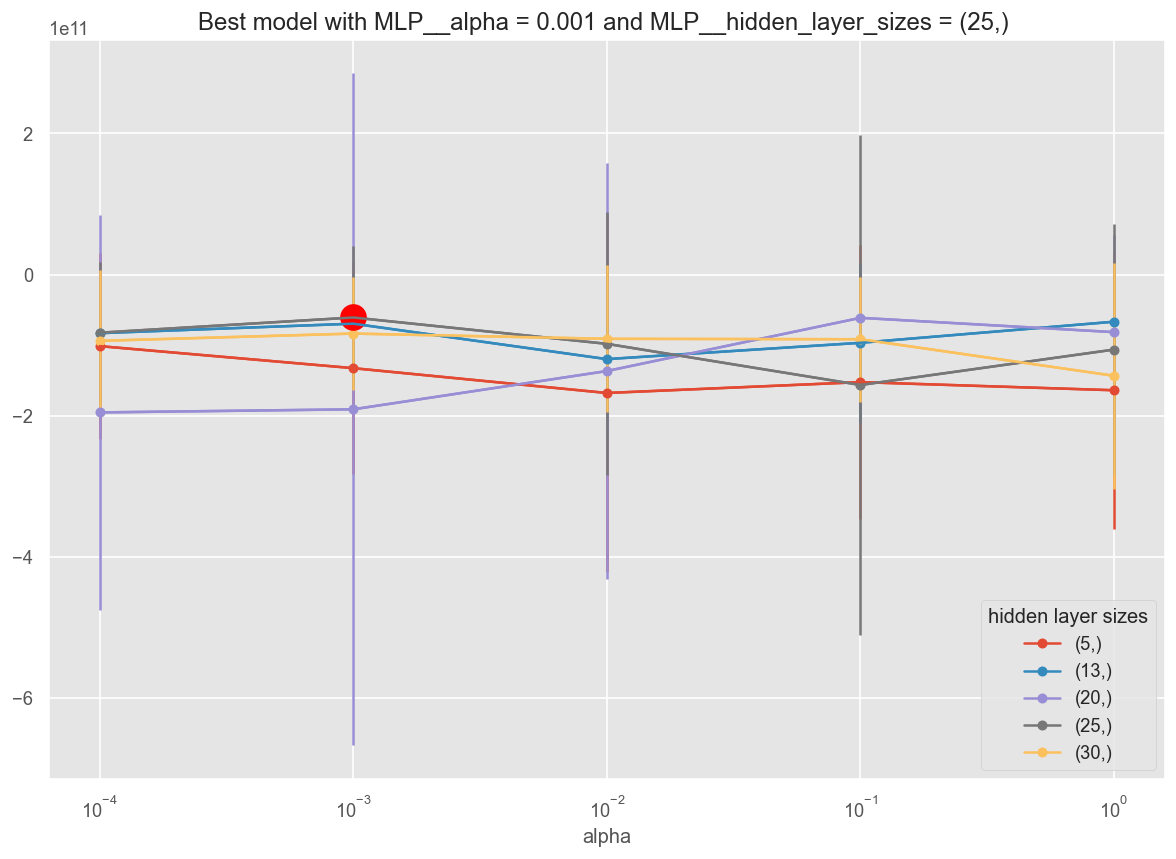

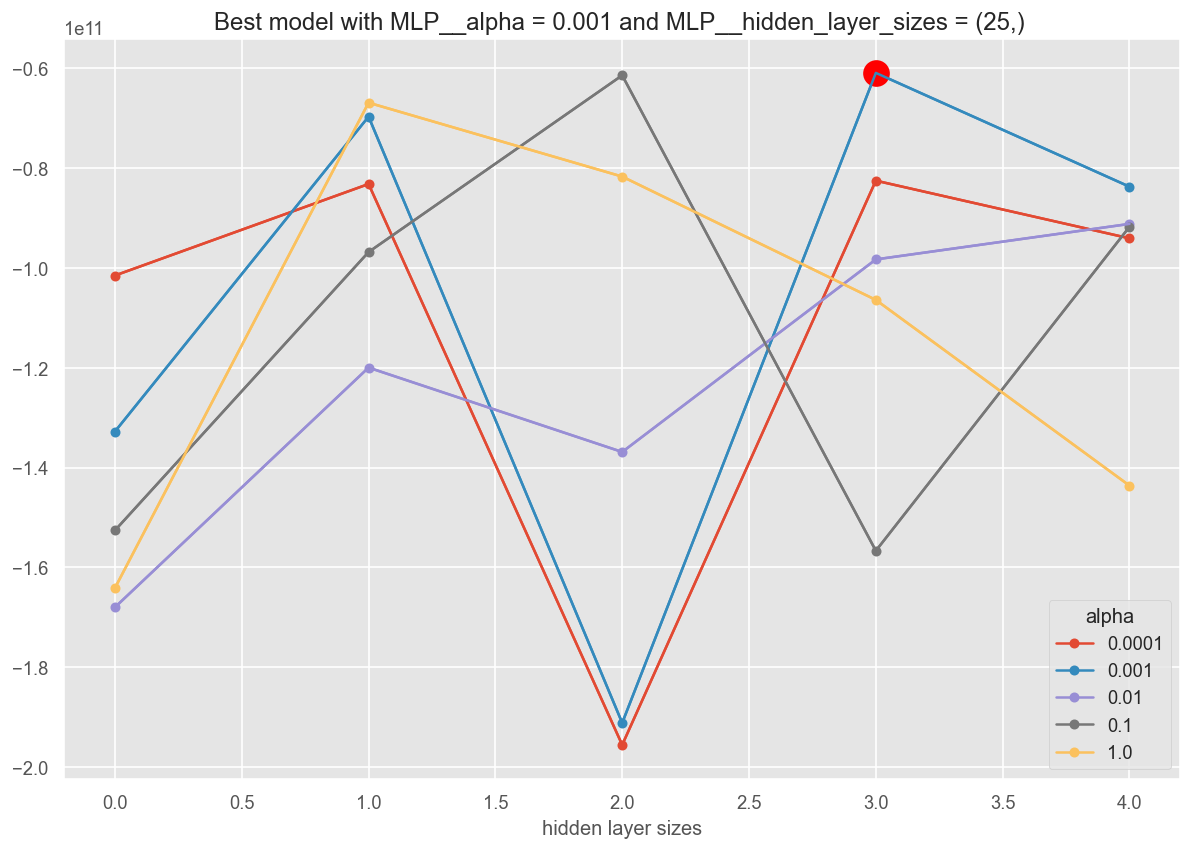

In [138]:
# Plot the cross validation score in the Grid Search
MT.plotModelGridError(MLP_fit, xscale="log")

In [144]:
# SENSITIVITY ANALYSIS
mlp = MLP_fit.best_estimator_['MLP']
wts = mlp.coefs_
bias = mlp.intercepts_
actfunc = ['identity',MLP_fit.best_estimator_['MLP'].get_params()['activation'],mlp.out_activation_]
X = MLP_fit.best_estimator_['preprocessor'].transform(X_train) # Preprocess the variables
coefnames = MLP_fit.best_estimator_['preprocessor'].get_feature_names_out(INPUTS_MLP)

X = pd.DataFrame(X, columns=coefnames)
y = pd.DataFrame(y_train, columns=['TOTAL'])
sens_end_layer = 'last'
sens_end_input = False
sens_origin_layer = 0
sens_origin_input = True

#Compute sensitivities
sensmlp = ns.jacobian_mlp(wts, bias, actfunc, X, y)
sensmlp.summary()
#sensmlp.info()

Sensitivity analysis of [4, 25, 1] MLP network.

Sensitivity measures of each output:

$TOTAL 

                     mean       std  mean_squared
num__TOTAL_lag1 -0.000020  0.000259      0.000260
num__TOTAL_lag2 -0.000020  0.000259      0.000260
num__TOTAL_lag3 -0.000020  0.000258      0.000259
num__TOTAL_lag4 -0.000019  0.000252      0.000252


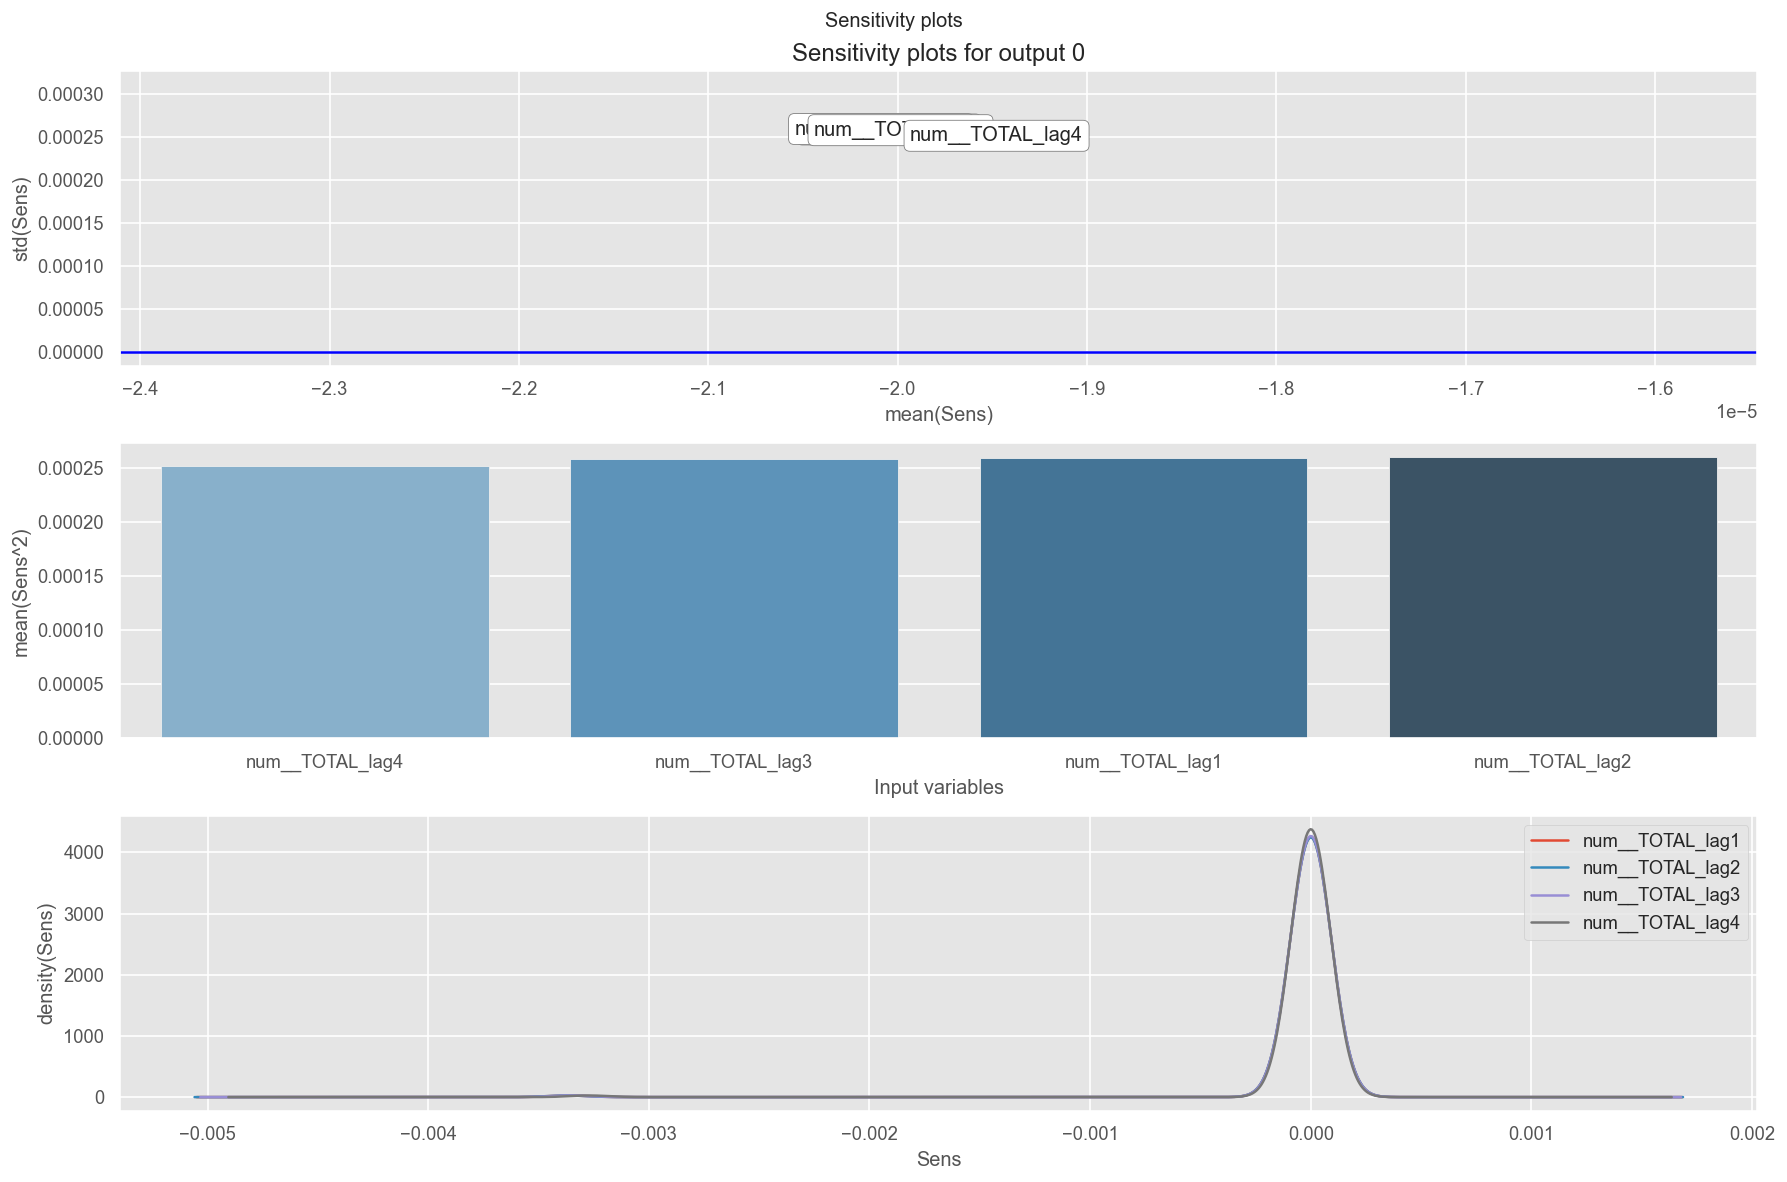

In [145]:
sensmlp.plot()

In [146]:
## Obtain a report of the model based on predictions ---------------------------------------------
dfTR_eval['MLP_pred'] = MLP_fit.predict(X_train)
### Scale test using preprocess in training
dfTS_eval['MLP_pred'] = MLP_fit.predict(X_test)

#Training and test MAE - Mean Absolute error
print('Training MAE:',mean_absolute_error(dfTR_eval['TOTAL'], dfTR_eval['MLP_pred']))
print('Test MAE:',mean_absolute_error(dfTS_eval['TOTAL'], dfTS_eval['MLP_pred']))
#Training and test RMSE - Root Mean Square Error
print('Training RMSE:',math.sqrt(mean_squared_error(dfTR_eval['TOTAL'], dfTR_eval['MLP_pred'])))
print('Test RMSE:',math.sqrt(mean_squared_error(dfTS_eval['TOTAL'], dfTS_eval['MLP_pred'])))
#Training and test r^2 
print('Training R2:',r2_score(dfTR_eval['TOTAL'], dfTR_eval['MLP_pred']))
print('Test R2:',r2_score(dfTS_eval['TOTAL'], dfTS_eval['MLP_pred']))

Training MAE: 185200.70203368063
Test MAE: 873260.9458020647
Training RMSE: 262829.309964448
Test RMSE: 915368.1025975066
Training R2: 0.947352322548676
Test R2: -9.59093619977167


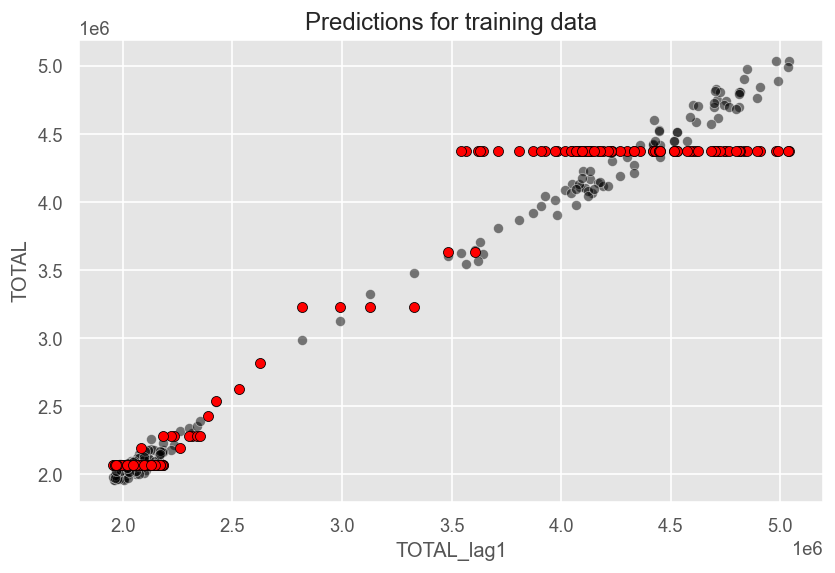

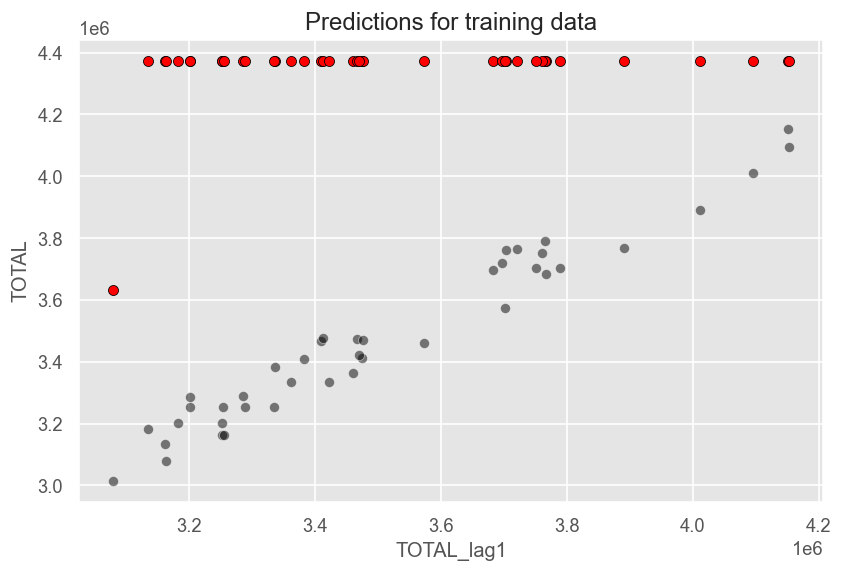

In [147]:
### Plot predictions of the model
sns.scatterplot(x='TOTAL_lag1', y='TOTAL', data=dfTR_eval, color='black', alpha=0.5)
sns.scatterplot(x='TOTAL_lag1', y='MLP_pred', data=dfTR_eval, color='red', edgecolor='black').set_title('Predictions for training data')
plt.show()
plt.figure() # Needed to plot two separated plots instead of two overlapped
sns.scatterplot(x='TOTAL_lag1', y='TOTAL', data=dfTS_eval, color='black', alpha=0.5)
sns.scatterplot(x='TOTAL_lag1', y='MLP_pred', data=dfTS_eval, color='red', edgecolor='black').set_title('Predictions for training data')
plt.show()

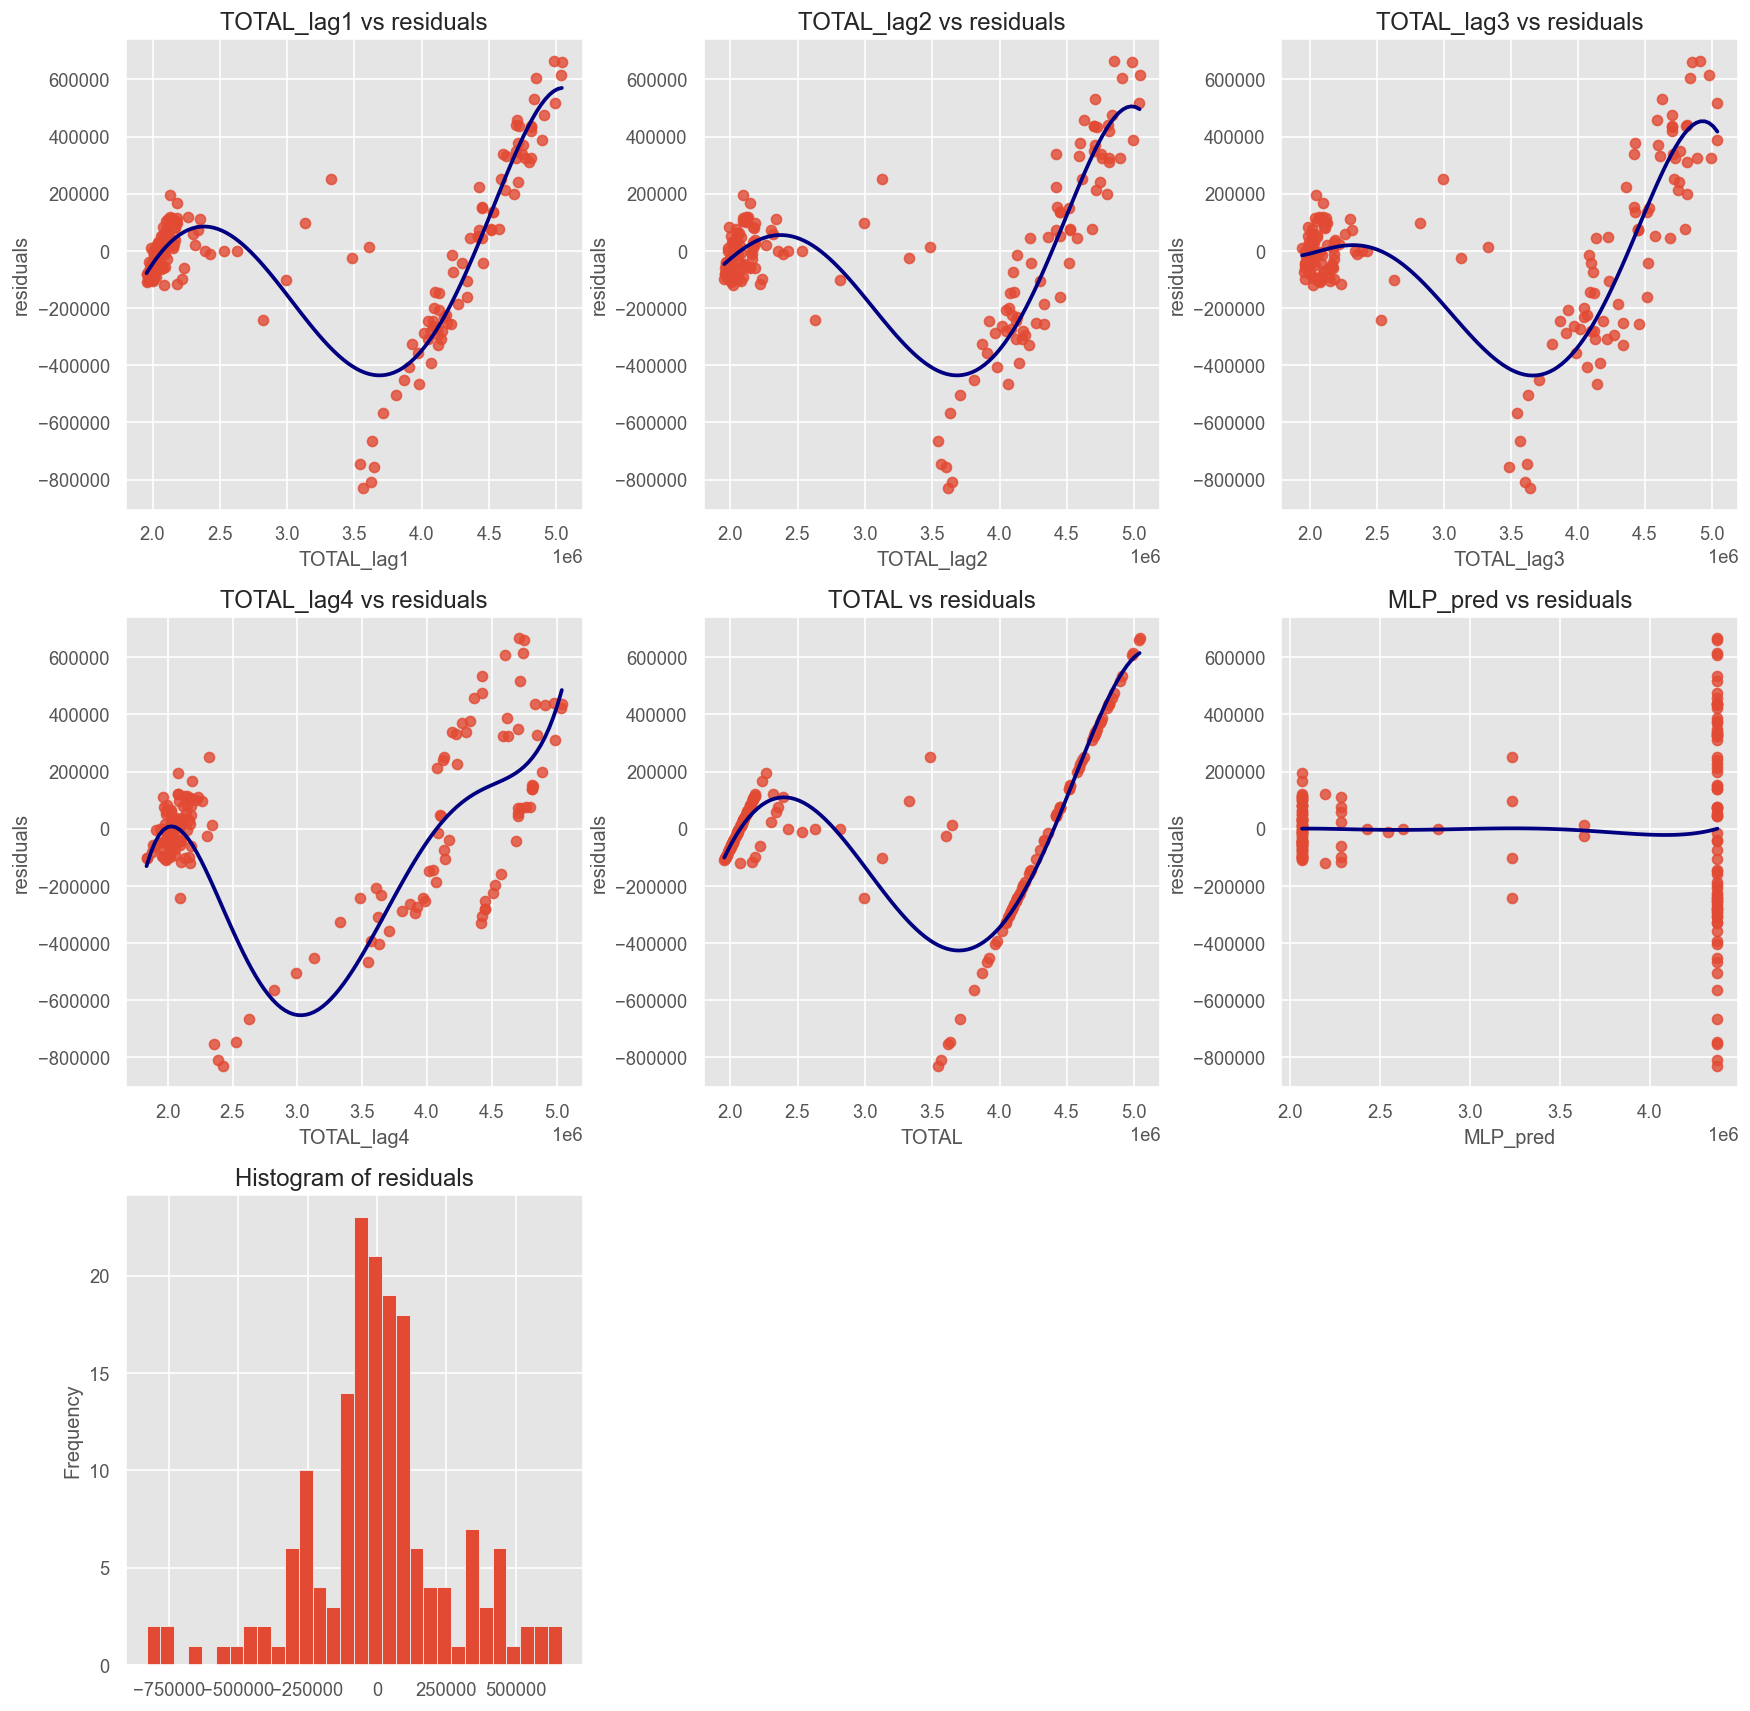

In [148]:
#Analysis of residuals
RT.plotModelDiagnosis(dfTR_eval, 'MLP_pred', 'TOTAL',figsize=[15,15])

# MLP_Con_Covid

In [45]:
###Include lagged variables
dfT = df[['TOTAL','COVID']].copy()
dfT['TOTAL_lag1'] = dfT['TOTAL'].shift()
#dfT['TOTAL_lag2'] = dfT['TOTAL'].shift(2)
#dfT['TOTAL_lag3'] = dfT['TOTAL'].shift(3)
dfT['TOTAL_lag4'] = dfT['TOTAL'].shift(12)
#dfT['TOTAL_lag5'] = dfT['TOTAL'].shift(13)

dfT.head()

TOTAL  COVID  TOTAL_lag1  TOTAL_lag4
DATE                                              
2001-01-01  2017389      0         NaN         NaN
2001-02-01  1993273      0   2017389.0         NaN
2001-03-01  1981006      0   1993273.0         NaN
2001-04-01  1910453      0   1981006.0         NaN
2001-05-01  1898285      0   1910453.0         NaN

In [46]:
# Remove missing
dfT.dropna(inplace=True)
dfT.head()

TOTAL  COVID  TOTAL_lag1  TOTAL_lag4
DATE                                              
2002-01-01  2075022      0   1988716.0   2017389.0
2002-02-01  2149907      0   2075022.0   1993273.0
2002-03-01  2083103      0   2149907.0   1981006.0
2002-04-01  2060069      0   2083103.0   1910453.0
2002-05-01  2002923      0   2060069.0   1898285.0

In [47]:
# Define input and output matrices
INPUTS = ['TOTAL_lag1','TOTAL_lag4','COVID']
OUTPUT = 'TOTAL'

# We have categorical inputs with many classes. We will create dummy variables automatically after
X = dfT[INPUTS]
y = dfT[OUTPUT]

## Divide the data into training and test sets SEQUENTIALY -------------------------------------
# Create random 80/20 % split
X_train2 = X.iloc[0:round(prop_train*X.shape[0])]
X_test2 = X.iloc[round(prop_train*X.shape[0])+1:X.shape[0]]
y_train2 = y.iloc[0:round(prop_train*X.shape[0])]#Esto creo que está hecho arriba, luego lo cambio
y_test2 = y.iloc[round(prop_train*X.shape[0])+1:X.shape[0]]

## Create dataset to store model predictions
dfTR_eval = X_train2.copy()
dfTR_eval['TOTAL'] = y_train2 # We will call Y as output variable for simplicity
dfTS_eval = X_test2.copy()
dfTS_eval['TOTAL'] = y_test2 # We will call Y as output variable for simplicity

X_train2.head()

TOTAL_lag1  TOTAL_lag4  COVID
DATE                                     
2002-01-01   1988716.0   2017389.0      0
2002-02-01   2075022.0   1993273.0      0
2002-03-01   2149907.0   1981006.0      0
2002-04-01   2083103.0   1910453.0      0
2002-05-01   2060069.0   1898285.0      0

In [60]:
#------------------------------- MLP Regression MODEL -------------------------------------------------
## Inputs of the model. Change accordingly to perform variable selection
INPUTS_MLP_NUM = ['TOTAL_lag1','TOTAL_lag4','COVID']
INPUTS_MLP_CAT = [] #Weekday is numerical in this case - Intervention variables
INPUTS_MLP = INPUTS_MLP_NUM + INPUTS_MLP_CAT

numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

# Create a preprocessor to perform the steps defined above
preprocessor = ColumnTransformer(transformers=[
        ('num', numeric_transformer, INPUTS_MLP_NUM)
        ])

param = {'MLP__alpha': [0.001, 0.01,0.1,1,10], # Initial value of regularization
         'MLP__hidden_layer_sizes':[(3,), (5,),(5,5),(10,)]} # Number of neurons in each hidden layer, enters as tuples

pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('MLP', MLPRegressor(solver='lbfgs', # Update function
                activation='logistic', # Logistic sigmoid activation function
                max_iter=450, # Maximum number of iterations
                tol=1e-4, # Tolerance for the optimization
                random_state=150,
                verbose = True))]) # For replication

# We use Grid Search Cross Validation to find the best parameter for the model in the grid defined 
nFolds = 10
MLP_fit = GridSearchCV(estimator=pipe, # Structure of the model to use
                       param_grid=param, # Defined grid to search in
                       n_jobs=-1, # Number of cores to use (parallelize)
                       scoring='neg_mean_squared_error', # RMSE https://scikit-learn.org/stable/modules/model_evaluation.html
                       cv=nFolds) # Number of Folds 
MLP_fit.fit(X_train2[INPUTS_MLP], y_train2) # Search in grid
print("MLP Trained")

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.41039D+12    |proj g|=  3.44906D+06

At iterate    1    f=  6.41037D+12    |proj g|=  3.44905D+06
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.42315D+12    |proj g|=  3.45521D+06

At iterate    1    f=  6.42313D+12    |proj g|=  3.45521D+06

At iterate    2    f=  6.30902D+12    |proj g|=  3.41954D+06

At iterate    3    f=  4.70633D+12    |proj g|=  2.89861D+06

At iterate    4    f=  2.56122D+11    |proj g|=  1.86629D+05

At iterate    2    f=  6.32123D+12    |proj g|=  3.42559D+06
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           10

At X0         0 variables are exactly at the bounds

At

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


 iterate    0    f=  6.43517D+12    |proj g|=  3.45771D+06

At iterate    3    f=  4.61436D+12    |proj g|=  2.86796D+06

At iterate    4    f=  2.79236D+12    |proj g|=  2.19090D+06

At iterate    1    f=  6.43514D+12    |proj g|=  3.45771D+06

At iterate    5    f=  4.54429D+11    |proj g|=  3.21950D+04

At iterate    6    f=  4.53912D+11    |proj g|=  1.43438D+03

At iterate    7    f=  4.53911D+11    |proj g|=  5.28327D+00

At iterate    2    f=  6.33333D+12    |proj g|=  3.42814D+06

At iterate    5    f=  2.38476D+11    |proj g|=  1.03234D+05

At iterate    3    f=  4.78973D+12    |proj g|=  2.94362D+06

At iterate    4    f=  4.57287D+11    |proj g|=  5.52325D+00

At iterate    6    f=  2.34742D+11    |proj g|=  9.04506D+04

At iterate    7    f=  2.29814D+11    |proj g|=  8.17437D+04

At iterate    8    f=  4.53910D+11    |proj g|=  4.87232D+02

At iterate    9    f=  3.60128D+11    |proj g|=  1.05456D+05

At iterate   10    f=  3.59839D+11    |proj g|=  1.05952D+05

At iterate

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.

 Bad 

+04

At iterate   23    f=  2.89756D+11    |proj g|=  4.37682D+06
  ys=-2.053E+08  -gs= 1.174E+08 BFGS update SKIPPED

At iterate    8    f=  4.18368D+11    |proj g|=  3.05403D+08
  ys=-3.311E+10  -gs= 4.995E+07 BFGS update SKIPPED

At iterate    9    f=  3.11380D+11    |proj g|=  2.08717D+07

At iterate   10    f=  2.83637D+11    |proj g|=  2.40190D+05

At iterate   11    f=  2.62304D+11    |proj g|=  1.27014D+05
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           16     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.50225D+12    |proj g|=  3.17640D+06

At iterate   24    f=  2.89747D+11    |proj g|=  3.43743D+04

At iterate    1    f=  5.50223D+12    |proj g|=  3.17639D+06

At iterate   25    f=  2.89271D+11    |proj g|=  1.30976D+09

At iterate   26    f=  2.87092D+11    |proj g|=  2.38790D+08

At iterate    2    f=  5.49627D+12    |proj g|=  2.57683D+07

At iterate   27    f=  2.86844D+11    |pro

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrain

.609D+10
  F =   36094956147.849480     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             

At iterate   23    f=  6.39489D+10    |proj g|=  1.01834D+04

At iterate   24    f=  6.39292D+10    |proj g|=  9.04935D+03
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           56     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.43516D+12    |proj g|=  3.45771D+06
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
RUNNING THE L-BFGS-B CODE
 N =           26     M =           10

           * * *


At X0         0 variables are exactly at the bounds
Machine precision = 2.220D-16
 N =           26     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.16679D+12    |proj g|=  3.35901D+06

At iterate    0    f=  6.41039D+12    |proj g|=  3.44906D+06

At iterate   25    f=  5.00653D+10    |proj g|=  1.49436D+05
  ys=-8.655E+09  -gs= 1.


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.

 Bad direc

E: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             

At iterate    7    f=  5.32135D+11    |proj g|=  1.27415D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   56      7     71      2     0     0   1.274D+00   5.321D+11
  F =   532134665362.00977     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           51     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.41039D+12    |proj g|=  3.44906D+06

At iterate    1    f=  4.43047D+12    |proj g|=  2.81712D+06

At iterate    2   

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh th


At iterate   15    f=  2.34172D+11    |proj g|=  6.05639D+07

At iterate   16    f=  1.95218D+11    |proj g|=  1.78543D+06

At iterate    5    f=  4.57444D+11    |proj g|=  3.06080D+02

At iterate   17    f=  1.92307D+11    |proj g|=  8.53281D+06

At iterate   18    f=  1.88640D+11    |proj g|=  4.58567D+05

At iterate   19    f=  1.85634D+11    |proj g|=  2.79147D+06

At iterate   20    f=  1.83771D+11    |proj g|=  1.66271D+06

At iterate   55    f=  5.87126D+10    |proj g|=  1.55977D+05

At iterate   21    f=  1.81713D+11    |proj g|=  1.43266D+06

At iterate   22    f=  1.81455D+11    |proj g|=  6.30240D+04

At iterate   56    f=  5.87126D+10    |proj g|=  3.75650D+04

At iterate   57    f=  5.87126D+10    |proj g|=  2.06357D+04

At iterate   58    f=  5.87126D+10    |proj g|=  1.09077D+05

At iterate   59    f=  5.87126D+10    |proj g|=  2.57178D+05

At iterate   60    f=  5.87126D+10    |proj g|=  5.13459D+05

At iterate   61    f=  5.87125D+10    |proj g|=  9.26011D+05

At iter


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.




Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   56     11     60      2     0     0   3.199D-08   5.538D+11
  F =   553794459513.25342     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            

At iterate    2    f=  5.35550D+11    |proj g|=  1.41064D+05

At iterate    3    f=  5.25612D+11    |proj g|=  1.93556D+02

At iterate   16    f=  1.02954D+11    |proj g|=  1.20438D+07

At iterate    4    f=  5.25564D+11    |proj g|=  5.44539D+02

At iterate    5    f=  5.25506D+11    |proj g|=  4.50850D+02

At iterate   10    f=  4.31342D+11    |proj g|=  7.60966D+03

At iterate    6    f=  5.25466D+11    |proj g|=  3.99120D+02

At ite

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 

ate    9    f=  1.77616D+11    |proj g|=  2.16667D+05

At iterate   65    f=  2.36863D+11    |proj g|=  4.45451D+06

At iterate   10    f=  1.72306D+11    |proj g|=  1.99666D+05

At iterate   13    f=  1.50937D+11    |proj g|=  5.94886D+07
  ys=-2.721E+08  -gs= 1.374E+09 BFGS update SKIPPED

At iterate   11    f=  1.68753D+11    |proj g|=  1.74148D+05

At iterate   15    f=  3.68354D+11    |proj g|=  5.00270D+04

At iterate   66    f=  2.36862D+11    |proj g|=  4.54041D+06

At iterate   12    f=  1.66025D+11    |proj g|=  1.35478D+06

At iterate   16    f=  3.68279D+11    |proj g|=  8.62139D+05

At iterate   17    f=  3.68174D+11    |proj g|=  1.08536D+07

At iterate   18    f=  3.59329D+11    |proj g|=  5.47082D+04

At iterate   13    f=  1.56002D+11    |proj g|=  3.08384D+05

At iterate   19    f=  3.57414D+11    |proj g|=  1.76524D+04

At iterate   20    f=  3.56466D+11    |proj g|=  1.50602D+04

At iterate   14    f=  1.55363D+11    |proj g|=  8.68768D+07
  ys=-1.474E+09  -gs= 5.60


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.




At iterate    9    f=  4.62388D+11    |proj g|=  3.46399D+01

At iterate   10    f=  4.62387D+11    |proj g|=  3.79889D-01

At iterate   11    f=  4.62387D+11    |proj g|=  1.26823D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   56     11     59      2     0     0   1.268D-02   4.624D+11
  F =   462386997740.43958     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             

At iterate   34    f=  2.58174D+11    |proj g|=  1.06275D+07

At iterate   35    f=  2.07103D+11    |proj g|=  1.88718D+05

At iterate   19    f=  8.28890D+10    |proj g|=  1.10178D+06

At iterate   36    f=  1.85254D+11    |proj g|=  


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refr

At iterate   24    f=  5.53794D+11    |proj g|=  9.08075D+00

At iterate    9    f=  5.53794D+11    |proj g|=  5.78235D-04

At iterate   25    f=  5.53794D+11    |proj g|=  1.24769D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   51      9     24      1     0     0   5.782D-04   5.538D+11
  F =   553794459513.25403     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             

At iterate   26    f=  5.53794D+11    |proj g|=  1.74672D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = numb

 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and re


At iterate   12    f=  5.26963D+11    |proj g|=  1.15978D+04

At iterate   13    f=  5.26777D+11    |proj g|=  3.32135D+04

At iterate   42    f=  9.63859D+10    |proj g|=  6.75148D+07

At iterate   14    f=  5.26165D+11    |proj g|=  2.68804D+04

At iterate   15    f=  5.25374D+11    |proj g|=  2.55070D+03

At iterate   16    f=  5.25368D+11    |proj g|=  2.13139D+03

At iterate   17    f=  5.25338D+11    |proj g|=  1.10131D+03

At iterate   18    f=  5.25332D+11    |proj g|=  7.85707D+02

At iterate   19    f=  5.25324D+11    |proj g|=  2.25673D+02

At iterate   20    f=  5.25324D+11    |proj g|=  5.75062D+01

At iterate   21    f=  5.25324D+11    |proj g|=  1.43275D+00

At iterate   22    f=  5.25324D+11    |proj g|=  3.76287D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized 

 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.

 Bad direc


At iterate   47    f=  1.30955D+11    |proj g|=  3.58984D+06

At iterate   48    f=  1.30950D+11    |proj g|=  5.54051D+06

At iterate   49    f=  1.30939D+11    |proj g|=  5.88434D+06

At iterate   50    f=  1.30930D+11    |proj g|=  2.67751D+07

At iterate   51    f=  1.30928D+11    |proj g|=  4.04901D+05

At iterate   52    f=  1.30927D+11    |proj g|=  6.47076D+05

At iterate   53    f=  1.30926D+11    |proj g|=  1.29751D+07

At iterate   54    f=  1.30924D+11    |proj g|=  7.41771D+06
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           51     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.95538D+12    |proj g|=  3.28977D+06

At iterate   55    f=  1.30917D+11    |proj g|=  1.00896D+07

At iterate   56    f=  1.30914D+11    |proj g|=  1.20994D+07

At iterate   57    f=  1.30913D+11    |proj g|=  9.66776D+06

At iterate   58    f=  1.30912D+11    |proj g|=  3.96801D+06

At iterate   59    f=  1.3

 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


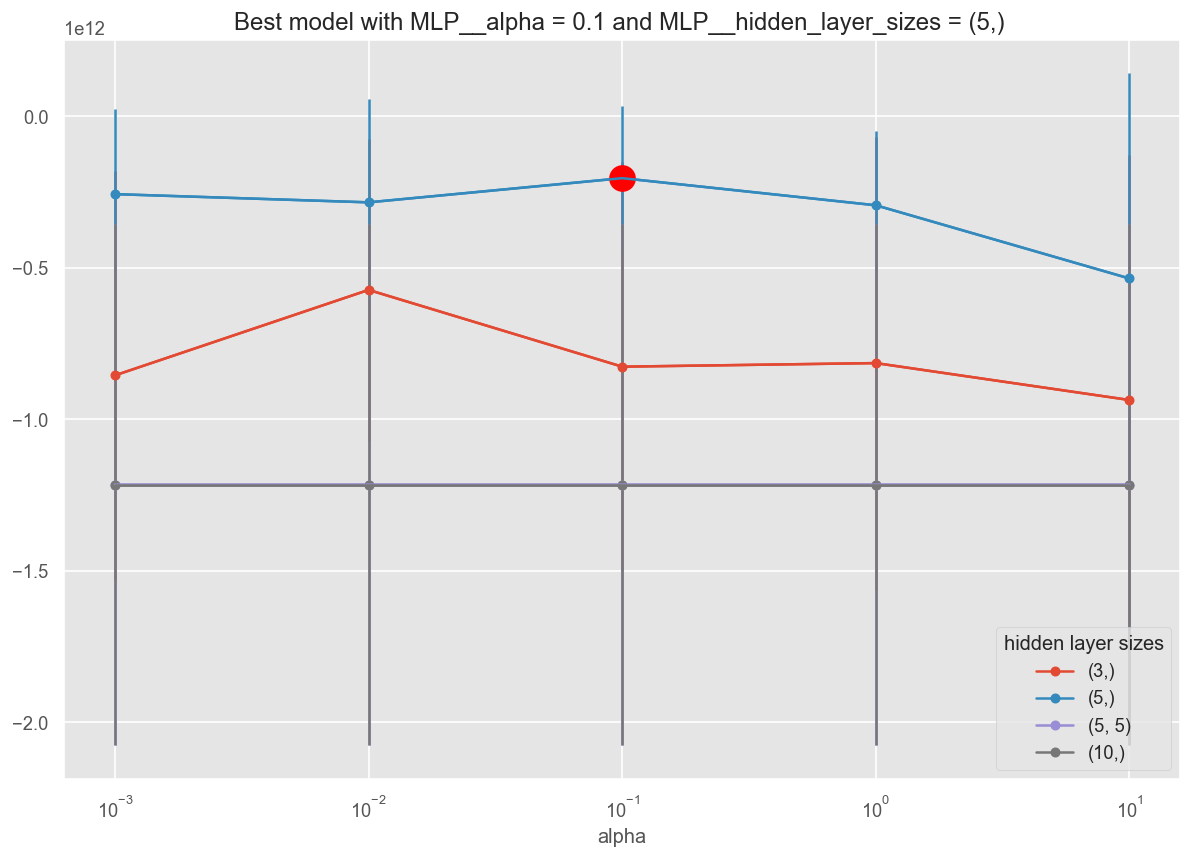

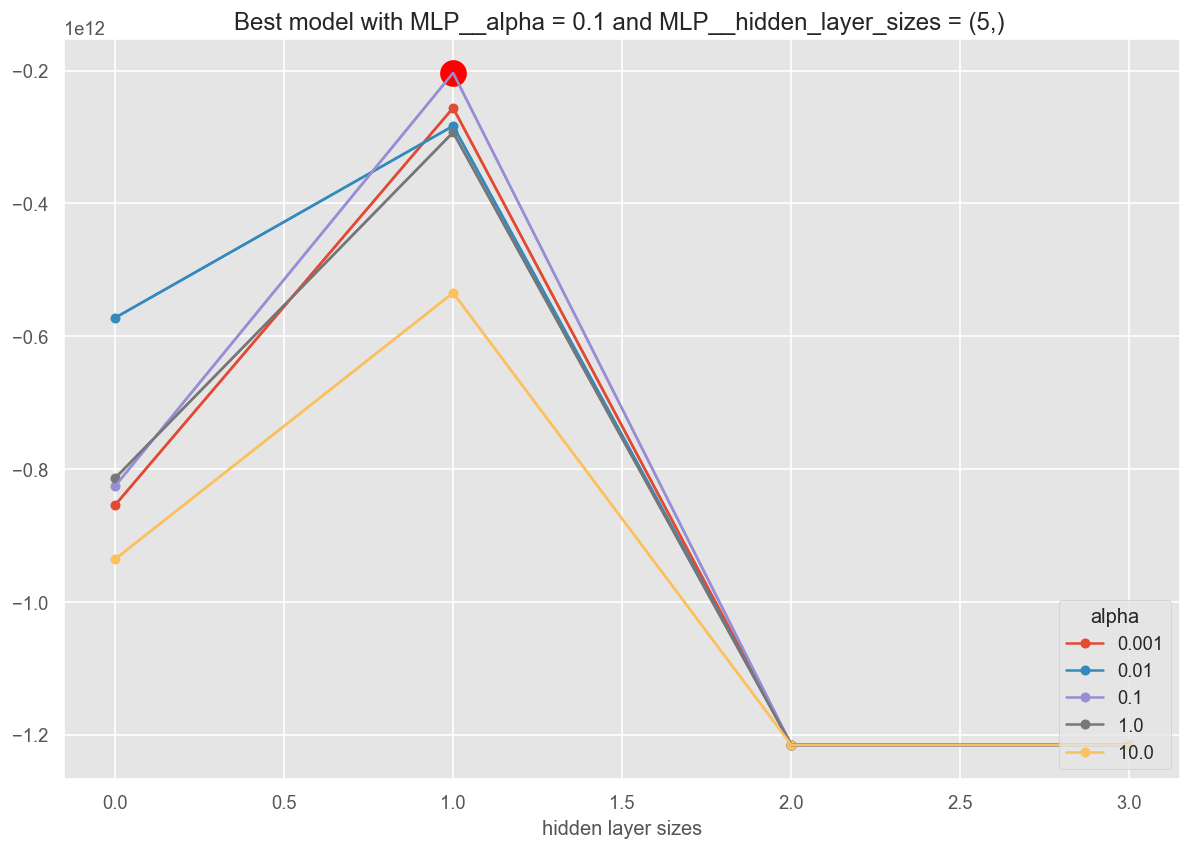

In [61]:
# Plot the cross validation score in the Grid Search
MT.plotModelGridError(MLP_fit, xscale="log")

In [62]:
# SENSITIVITY ANALYSIS
mlp = MLP_fit.best_estimator_['MLP']
wts = mlp.coefs_
bias = mlp.intercepts_
actfunc = ['identity',MLP_fit.best_estimator_['MLP'].get_params()['activation'],mlp.out_activation_]
X = MLP_fit.best_estimator_['preprocessor'].transform(X_train2) # Preprocess the variables
coefnames = MLP_fit.best_estimator_['preprocessor'].get_feature_names_out(INPUTS_MLP)

X = pd.DataFrame(X, columns=coefnames)
y = pd.DataFrame(y_train2, columns=['TOTAL'])
sens_end_layer = 'last'
sens_end_input = False
sens_origin_layer = 0
sens_origin_input = True

#Compute sensitivities
sensmlp = ns.jacobian_mlp(wts, bias, actfunc, X, y)
sensmlp.summary()
#sensmlp.info()

Sensitivity analysis of [3, 5, 1] MLP network.

Sensitivity measures of each output:

$TOTAL 

                         mean           std  mean_squared
num__TOTAL_lag1  5.318558e+07  4.062485e+08  4.097152e+08
num__TOTAL_lag4  3.001267e+07  2.962137e+08  2.977302e+08
num__COVID       1.303425e+07  1.100715e+08  1.108405e+08


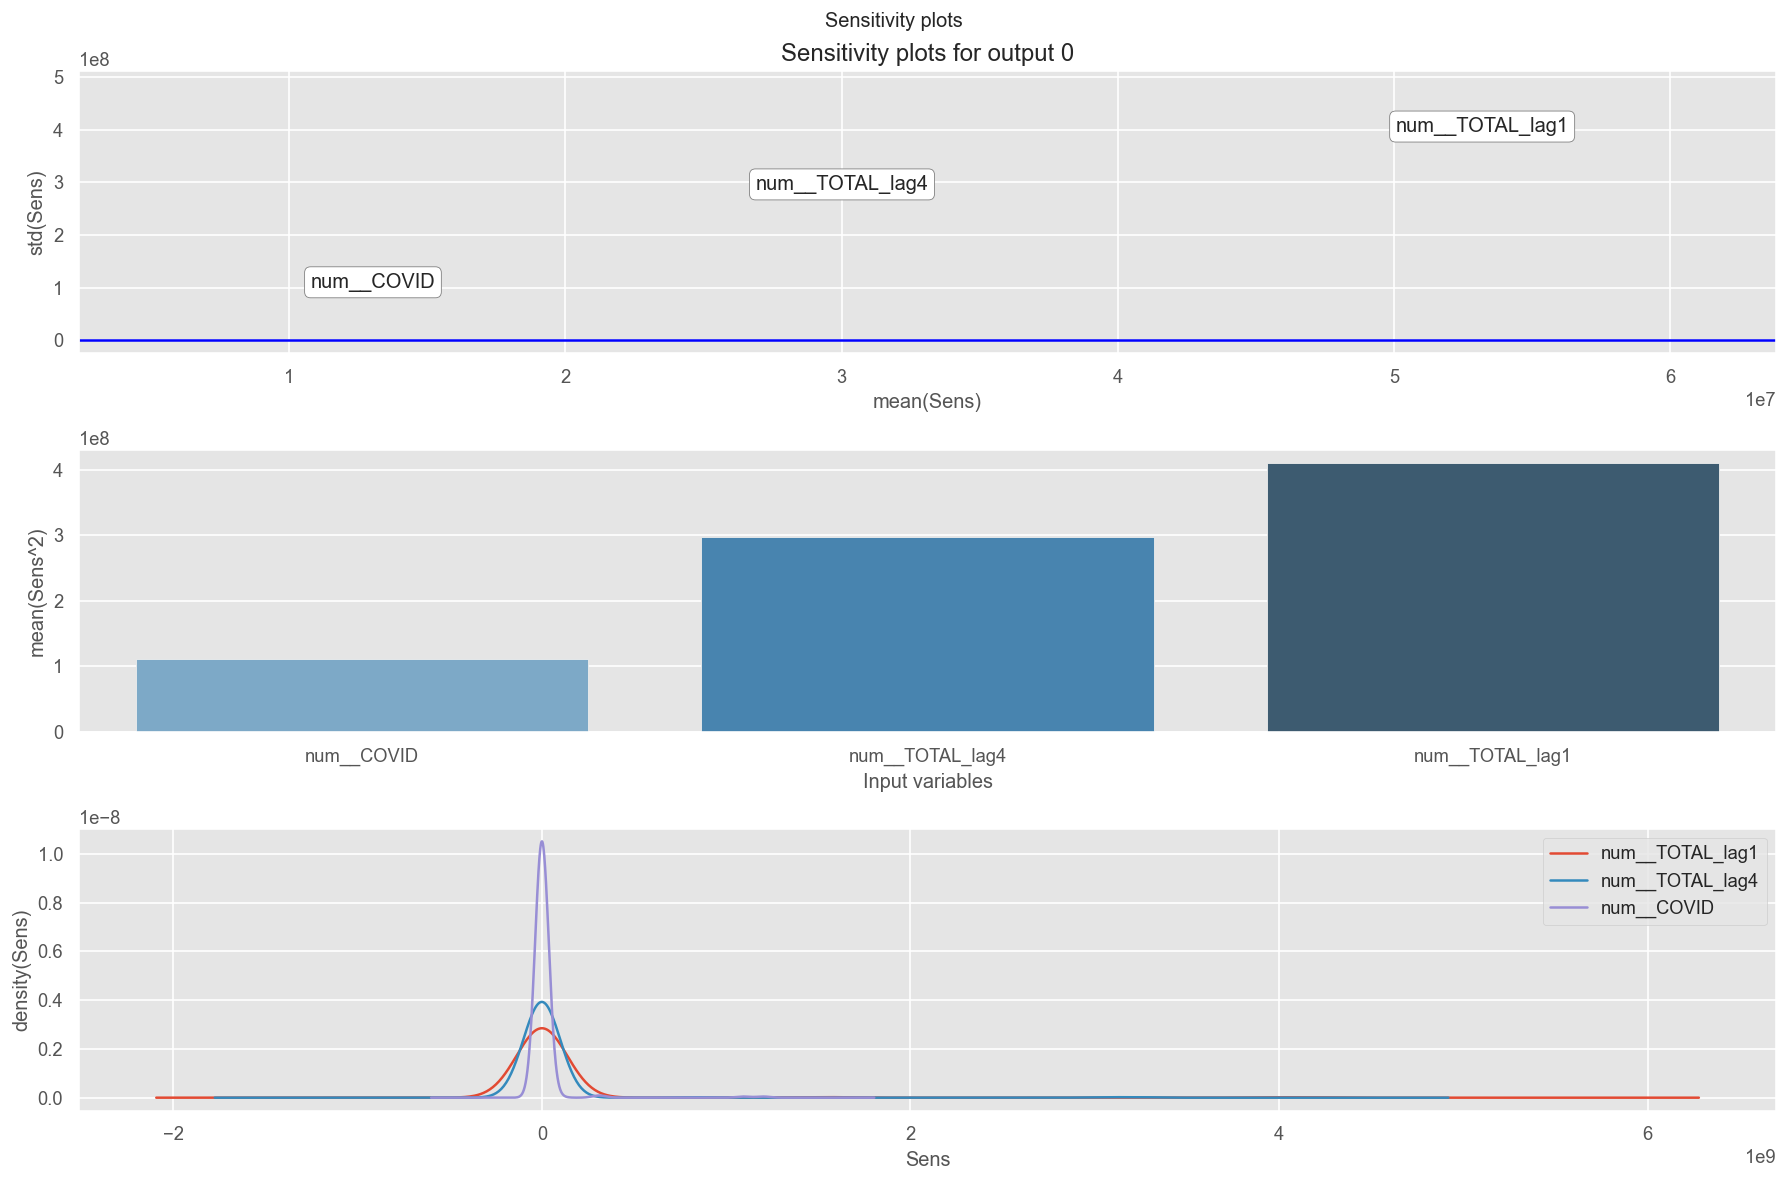

In [63]:
sensmlp.plot()

In [64]:
## Obtain a report of the model based on predictions ---------------------------------------------
dfTR_eval['MLP_pred'] = MLP_fit.predict(X_train2)
### Scale test using preprocess in training
dfTS_eval['MLP_pred'] = MLP_fit.predict(X_test2)

#Training and test MAE - Mean Absolute error
print('Training MAE:',mean_absolute_error(dfTR_eval['TOTAL'], dfTR_eval['MLP_pred']))
print('Test MAE:',mean_absolute_error(dfTS_eval['TOTAL'], dfTS_eval['MLP_pred']))
#Training and test RMSE - Root Mean Square Error
print('Training RMSE:',math.sqrt(mean_squared_error(dfTR_eval['TOTAL'], dfTR_eval['MLP_pred'])))
print('Test RMSE:',math.sqrt(mean_squared_error(dfTS_eval['TOTAL'], dfTS_eval['MLP_pred'])))
#Training and test r^2 
print('Training R2:',r2_score(dfTR_eval['TOTAL'], dfTR_eval['MLP_pred']))
print('Test R2:',r2_score(dfTS_eval['TOTAL'], dfTS_eval['MLP_pred']))

Training MAE: 261913.60936812876
Test MAE: 231015.62387900188
Training RMSE: 374341.3519471216
Test RMSE: 321284.74135538196
Training R2: 0.8596578774395963
Test R2: -0.4403215828679854


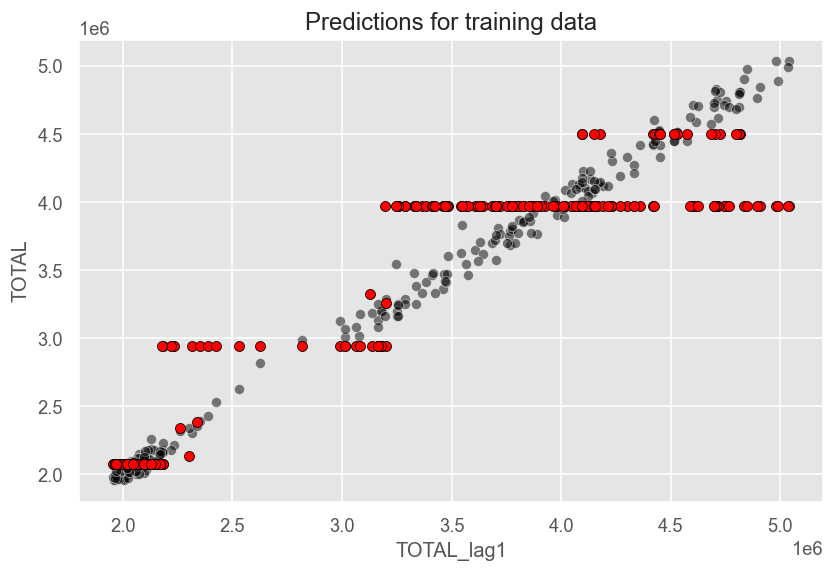

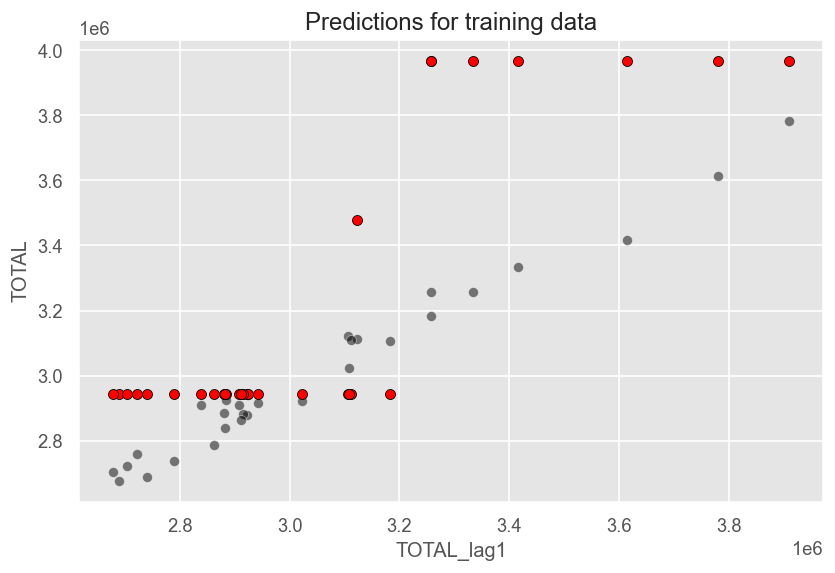

In [65]:
### Plot predictions of the model
sns.scatterplot(x='TOTAL_lag1', y='TOTAL', data=dfTR_eval, color='black', alpha=0.5)
sns.scatterplot(x='TOTAL_lag1', y='MLP_pred', data=dfTR_eval, color='red', edgecolor='black').set_title('Predictions for training data')
plt.show()
plt.figure() # Needed to plot two separated plots instead of two overlapped
sns.scatterplot(x='TOTAL_lag1', y='TOTAL', data=dfTS_eval, color='black', alpha=0.5)
sns.scatterplot(x='TOTAL_lag1', y='MLP_pred', data=dfTS_eval, color='red', edgecolor='black').set_title('Predictions for training data')
plt.show()

/usr/local/Caskroom/miniforge/base/envs/ML/lib/python3.11/site-packages/seaborn/regression.py:251: RankWarning: Polyfit may be poorly conditioned
  return np.polyval(np.polyfit(_x, _y, order), grid)


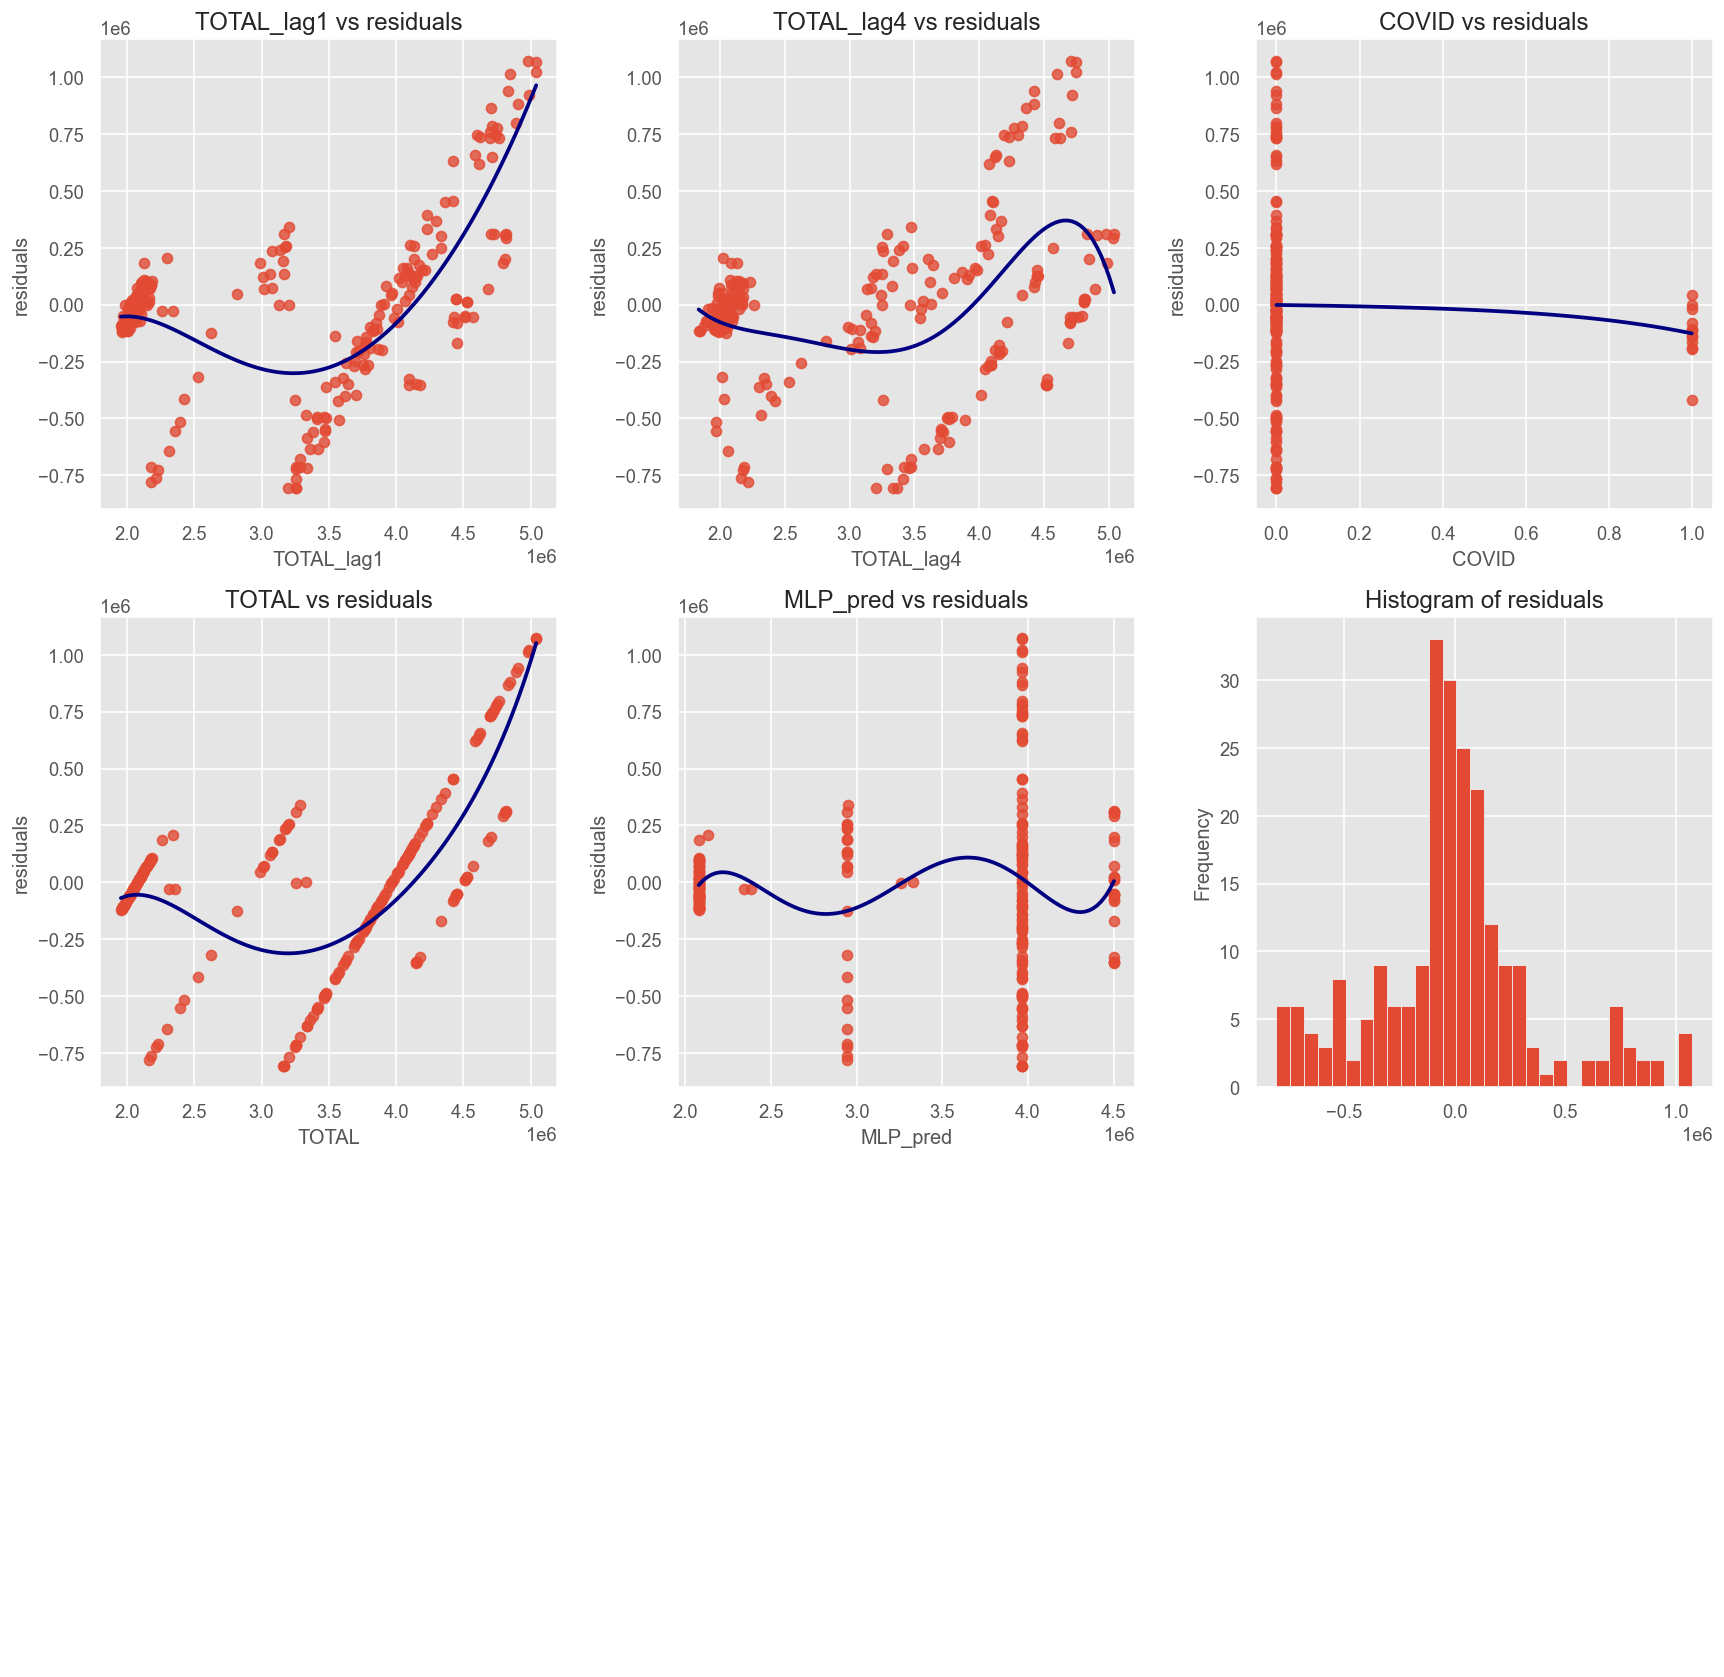

In [66]:
#Analysis of residuals
RT.plotModelDiagnosis(dfTR_eval, 'MLP_pred', 'TOTAL',figsize=[15,15])

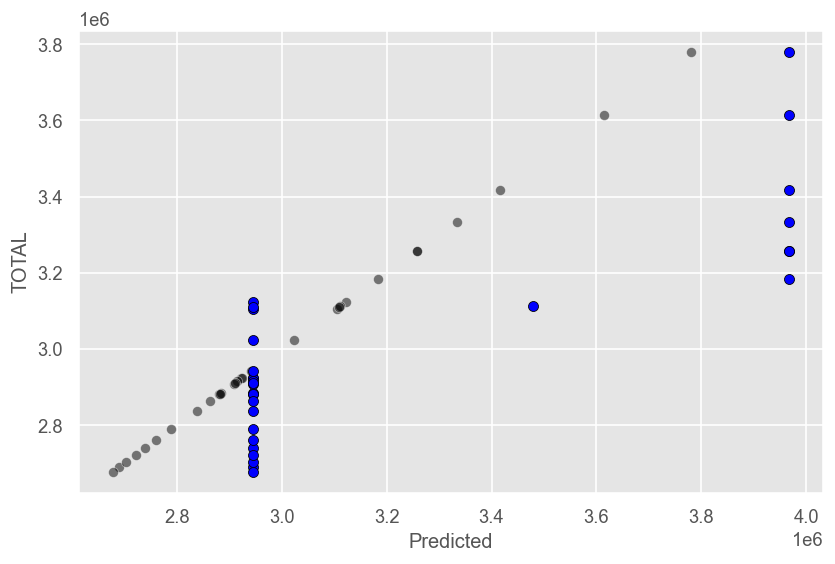

In [55]:
# Visualize prediction with respect to output
sns.scatterplot(data=dfTS_eval, x='TOTAL', y='TOTAL', color='black', alpha=0.5)
sns.scatterplot(data=dfTS_eval, x='MLP_pred', y='TOTAL', color='blue', edgecolor='black')
plt.xlabel('Predicted')
plt.show()

ValueError: Can only compute partial correlations for lags up to 50% of the sample size. The requested nlags 25 must be < 15.

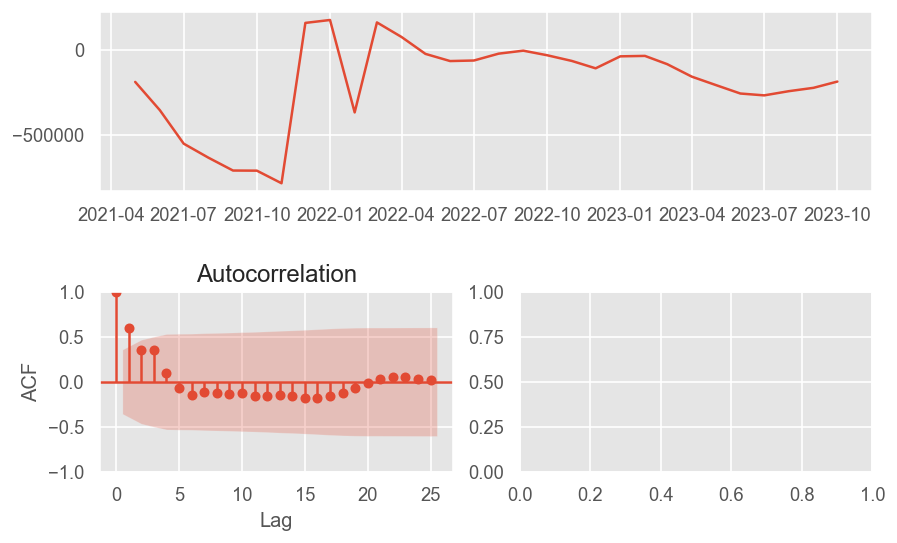

In [56]:
# Check correlation of residuals
FT.ts_display(dfTS_eval['TOTAL'] - dfTS_eval['MLP_pred'])